# Tensor Flow Notebook
## W207 Final Project
### T. P. Goter
### July 6, 2019

This workbook is used to create, fit and analyze various neural networks for facial keypoint detection.

In [ ]:
# Import needed packages
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import pandas as pd
import numpy as np
import time
from tensorflow.keras import models, layers, callbacks
from tensorflow.keras import optimizers, metrics
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
tf.__version__

## Data Loading

- Load in the pickle file that was created as part of the EDA in DataExploration.ipynb. 
- This dataset has the NaNs removed and a few mislabeled images removed as well. 
- As such there is only limited training and development data to use. 
- The image data has already been normalized to [0,1]

In [ ]:
# Initialize Random Seed for reproducibility
np.random.seed(13)

# Load the dataframe from the pickle file
df_nostache_nonan = pd.read_pickle("df_nostache_nonan.pkl")

# Grab the last column - that is our image data for X matrix
X = df_nostache_nonan.iloc[:, -1]

# Convert from a series of arrays to an NDarray
X = np.array([x for x in X])

# Grab the keypoints and stick into our y-variable
y = np.array(df_nostache_nonan.iloc[:,:-1])


## Baseline Neural Net
CNNs are combinations of convolution layers, pooling layers and dropout layers followed by one or two fully connected layers once the number of dimensions has been sufficiently reduced.

1. Let's include just one hidden layer and one output layer
2. The input layer will reduce our flattened 96x96 matrix (i.e., 9216 in length) to a predetermined number of hidden units
3. We will then run sensitivities to # of hidden units, activation, optimizer, and learning rate
4. We will judge our model based on RMSE error and run time.

In [ ]:
def base_model(hidden_units=100, activation='relu'):
    base_model = models.Sequential()
    base_model.add(layers.Dense(hidden_units,activation=activation, kernel_initializer='normal',input_shape=[9216]))
    base_model.add(layers.Dense(30, activation=activation))
    base_model.build()
    print(base_model.summary())
    return base_model
   
class TimeHistory(callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

#### Define our optimizers for our initial study

In [19]:
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
sgd = optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0, nesterov=True)
nadam = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
adagrad = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)

opt_list = {'adam':adam, 'sgd':sgd, 'nadam':nadam, 'adagrad':adagrad}

#### Set up our first DOE

In [ ]:
single_layer_base_df = pd.DataFrame()
for hidden_unit in [50, 100, 150, 200]:
    for act in ['relu', 'sigmoid', 'tanh']:
        for opt_name, opt in opt_list.items():
            model = base_model(hidden_units=hidden_unit, activation=act)
            model.compile(optimizer=opt,
                          loss='mean_squared_error',
                          metrics=['mean_squared_error'])
            time_callback = TimeHistory()
            history = model.fit(X, y, epochs=400, validation_split=0.15, callbacks=[time_callback])
            times = time_callback.times

            # Convert to dataframe
            hist = pd.DataFrame(history.history)
            hist['epoch'] = history.epoch
            hist['RMSE'] = np.sqrt(hist.mean_squared_error)
            hist['val_RMSE'] = np.sqrt(hist.val_mean_squared_error)
            hist['times'] = times
            hist['hunits'] = hidden_unit
            hist['activation'] = act
            hist['optimizer'] = opt_name
            hist['lrate'] = opt.get_config()['learning_rate']

            # Keep concatenating to dataframe
            single_layer_base_df = pd.concat([single_layer_base_df,hist])
            
            # Re-pickle after every model to retain progress
            single_layer_base_df.to_pickle("OutputData/single_layer_df.pkl")

            # Save models.
            filename = "base_model_{}_{}_{}".format(hidden_unit, act, opt_name)
            model.save("Models/"+filename+".h5")


Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_132 (Dense)            (None, 50)                460850    
_________________________________________________________________
dense_133 (Dense)            (None, 30)                1530      
Total params: 462,380
Trainable params: 462,380
Non-trainable params: 0
_________________________________________________________________
None
Train on 1819 samples, validate on 321 samples
Epoch 1/400
1819/1819 [==============================] - 0s 191us/sample - loss: 855.1641 - mean_squared_error: 855.1642 - val_loss: 659.0494 - val_mean_squared_error: 659.0494
Epoch 2/400
1819/1819 [==============================] - 0s 118us/sample - loss: 650.3790 - mean_squared_error: 650.3790 - val_loss: 647.6724 - val_mean_squared_error: 647.6724
Epoch 3/400
1819/1819 [==============================] - 0s 135us/sample - loss: 639.5403 - mean_square

1819/1819 [==============================] - 0s 118us/sample - loss: 332.9102 - mean_squared_error: 332.9102 - val_loss: 348.5560 - val_mean_squared_error: 348.5560
Epoch 44/400
1819/1819 [==============================] - 0s 117us/sample - loss: 332.2447 - mean_squared_error: 332.2448 - val_loss: 349.3753 - val_mean_squared_error: 349.3753
Epoch 45/400
1819/1819 [==============================] - 0s 117us/sample - loss: 331.0791 - mean_squared_error: 331.0791 - val_loss: 350.5196 - val_mean_squared_error: 350.5196
Epoch 46/400
1819/1819 [==============================] - 0s 118us/sample - loss: 330.4888 - mean_squared_error: 330.4887 - val_loss: 348.0614 - val_mean_squared_error: 348.0614
Epoch 47/400
1819/1819 [==============================] - 0s 132us/sample - loss: 329.2538 - mean_squared_error: 329.2538 - val_loss: 348.2779 - val_mean_squared_error: 348.2779
Epoch 48/400
1819/1819 [==============================] - 0s 122us/sample - loss: 328.9788 - mean_squared_error: 328.9788 -

1819/1819 [==============================] - 0s 121us/sample - loss: 287.0583 - mean_squared_error: 287.0583 - val_loss: 311.3409 - val_mean_squared_error: 311.3409
Epoch 90/400
1819/1819 [==============================] - 0s 117us/sample - loss: 287.0829 - mean_squared_error: 287.0829 - val_loss: 313.5579 - val_mean_squared_error: 313.5580
Epoch 91/400
1819/1819 [==============================] - 0s 115us/sample - loss: 288.1818 - mean_squared_error: 288.1818 - val_loss: 313.2028 - val_mean_squared_error: 313.2028
Epoch 92/400
1819/1819 [==============================] - 0s 117us/sample - loss: 287.0771 - mean_squared_error: 287.0771 - val_loss: 310.0630 - val_mean_squared_error: 310.0630
Epoch 93/400
1819/1819 [==============================] - 0s 121us/sample - loss: 285.2642 - mean_squared_error: 285.2642 - val_loss: 310.3700 - val_mean_squared_error: 310.3700
Epoch 94/400
1819/1819 [==============================] - 0s 116us/sample - loss: 285.3662 - mean_squared_error: 285.3662 -

Epoch 135/400
1819/1819 [==============================] - 0s 119us/sample - loss: 280.3673 - mean_squared_error: 280.3672 - val_loss: 303.9981 - val_mean_squared_error: 303.9981
Epoch 136/400
1819/1819 [==============================] - 0s 115us/sample - loss: 279.1825 - mean_squared_error: 279.1825 - val_loss: 303.9832 - val_mean_squared_error: 303.9832
Epoch 137/400
1819/1819 [==============================] - 0s 133us/sample - loss: 279.6291 - mean_squared_error: 279.6291 - val_loss: 310.6765 - val_mean_squared_error: 310.6765
Epoch 138/400
1819/1819 [==============================] - 0s 125us/sample - loss: 279.3720 - mean_squared_error: 279.3721 - val_loss: 306.2243 - val_mean_squared_error: 306.2243
Epoch 139/400
1819/1819 [==============================] - 0s 125us/sample - loss: 279.2901 - mean_squared_error: 279.2902 - val_loss: 304.9643 - val_mean_squared_error: 304.9642
Epoch 140/400
1819/1819 [==============================] - 0s 124us/sample - loss: 279.5637 - mean_square

Epoch 181/400
1819/1819 [==============================] - 0s 131us/sample - loss: 276.0971 - mean_squared_error: 276.0971 - val_loss: 300.2387 - val_mean_squared_error: 300.2388
Epoch 182/400
1819/1819 [==============================] - 0s 125us/sample - loss: 276.5903 - mean_squared_error: 276.5903 - val_loss: 307.9544 - val_mean_squared_error: 307.9543
Epoch 183/400
1819/1819 [==============================] - 0s 135us/sample - loss: 275.3136 - mean_squared_error: 275.3136 - val_loss: 299.8249 - val_mean_squared_error: 299.8249
Epoch 184/400
1819/1819 [==============================] - 0s 128us/sample - loss: 275.1678 - mean_squared_error: 275.1678 - val_loss: 300.2036 - val_mean_squared_error: 300.2036
Epoch 185/400
1819/1819 [==============================] - 0s 149us/sample - loss: 275.1948 - mean_squared_error: 275.1948 - val_loss: 300.9904 - val_mean_squared_error: 300.9904
Epoch 186/400
1819/1819 [==============================] - 0s 219us/sample - loss: 274.9820 - mean_square

Epoch 227/400
1819/1819 [==============================] - 0s 119us/sample - loss: 274.2338 - mean_squared_error: 274.2338 - val_loss: 298.0736 - val_mean_squared_error: 298.0736
Epoch 228/400
1819/1819 [==============================] - 0s 119us/sample - loss: 273.5709 - mean_squared_error: 273.5709 - val_loss: 297.0480 - val_mean_squared_error: 297.0479
Epoch 229/400
1819/1819 [==============================] - 0s 113us/sample - loss: 273.2759 - mean_squared_error: 273.2758 - val_loss: 297.4762 - val_mean_squared_error: 297.4762
Epoch 230/400
1819/1819 [==============================] - 0s 110us/sample - loss: 273.5243 - mean_squared_error: 273.5244 - val_loss: 297.3513 - val_mean_squared_error: 297.3513
Epoch 231/400
1819/1819 [==============================] - 0s 114us/sample - loss: 273.0588 - mean_squared_error: 273.0588 - val_loss: 297.8408 - val_mean_squared_error: 297.8408
Epoch 232/400
1819/1819 [==============================] - 0s 120us/sample - loss: 272.5494 - mean_square

Epoch 273/400
1819/1819 [==============================] - 0s 137us/sample - loss: 271.7306 - mean_squared_error: 271.7305 - val_loss: 295.4215 - val_mean_squared_error: 295.4214
Epoch 274/400
1819/1819 [==============================] - 0s 131us/sample - loss: 271.4315 - mean_squared_error: 271.4315 - val_loss: 295.1784 - val_mean_squared_error: 295.1784
Epoch 275/400
1819/1819 [==============================] - 0s 126us/sample - loss: 271.7696 - mean_squared_error: 271.7696 - val_loss: 295.6246 - val_mean_squared_error: 295.6246
Epoch 276/400
1819/1819 [==============================] - 0s 118us/sample - loss: 272.1377 - mean_squared_error: 272.1377 - val_loss: 294.9352 - val_mean_squared_error: 294.9352
Epoch 277/400
1819/1819 [==============================] - 0s 110us/sample - loss: 271.3264 - mean_squared_error: 271.3265 - val_loss: 294.9559 - val_mean_squared_error: 294.9559
Epoch 278/400
1819/1819 [==============================] - 0s 125us/sample - loss: 271.1360 - mean_square

Epoch 319/400
1819/1819 [==============================] - 0s 127us/sample - loss: 270.8791 - mean_squared_error: 270.8791 - val_loss: 293.8372 - val_mean_squared_error: 293.8372
Epoch 320/400
1819/1819 [==============================] - 0s 121us/sample - loss: 270.8566 - mean_squared_error: 270.8566 - val_loss: 293.9058 - val_mean_squared_error: 293.9058
Epoch 321/400
1819/1819 [==============================] - 0s 122us/sample - loss: 270.9063 - mean_squared_error: 270.9062 - val_loss: 293.8128 - val_mean_squared_error: 293.8128
Epoch 322/400
1819/1819 [==============================] - 0s 126us/sample - loss: 272.3738 - mean_squared_error: 272.3738 - val_loss: 295.4436 - val_mean_squared_error: 295.4436
Epoch 323/400
1819/1819 [==============================] - 0s 122us/sample - loss: 271.8500 - mean_squared_error: 271.8500 - val_loss: 295.1796 - val_mean_squared_error: 295.1796
Epoch 324/400
1819/1819 [==============================] - 0s 127us/sample - loss: 270.9777 - mean_square

Epoch 365/400
1819/1819 [==============================] - 0s 134us/sample - loss: 270.3654 - mean_squared_error: 270.3654 - val_loss: 293.6650 - val_mean_squared_error: 293.6651
Epoch 366/400
1819/1819 [==============================] - 0s 119us/sample - loss: 270.9142 - mean_squared_error: 270.9143 - val_loss: 292.6680 - val_mean_squared_error: 292.6680
Epoch 367/400
1819/1819 [==============================] - 0s 128us/sample - loss: 270.3351 - mean_squared_error: 270.3351 - val_loss: 294.2112 - val_mean_squared_error: 294.2111
Epoch 368/400
1819/1819 [==============================] - 0s 134us/sample - loss: 270.4009 - mean_squared_error: 270.4010 - val_loss: 293.4057 - val_mean_squared_error: 293.4057
Epoch 369/400
1819/1819 [==============================] - 0s 143us/sample - loss: 270.7271 - mean_squared_error: 270.7270 - val_loss: 292.2055 - val_mean_squared_error: 292.2056
Epoch 370/400
1819/1819 [==============================] - 0s 147us/sample - loss: 270.8259 - mean_square

Epoch 7/400
1819/1819 [==============================] - 0s 127us/sample - loss: 2232.5336 - mean_squared_error: 2232.5337 - val_loss: 2225.0330 - val_mean_squared_error: 2225.0330
Epoch 8/400
1819/1819 [==============================] - 0s 128us/sample - loss: 2230.0001 - mean_squared_error: 2230.0002 - val_loss: 2223.3684 - val_mean_squared_error: 2223.3684
Epoch 9/400
1819/1819 [==============================] - 0s 127us/sample - loss: 2228.8733 - mean_squared_error: 2228.8735 - val_loss: 2222.6171 - val_mean_squared_error: 2222.6169
Epoch 10/400
1819/1819 [==============================] - 0s 145us/sample - loss: 2228.3713 - mean_squared_error: 2228.3716 - val_loss: 2222.2795 - val_mean_squared_error: 2222.2795
Epoch 11/400
1819/1819 [==============================] - 0s 137us/sample - loss: 2228.1473 - mean_squared_error: 2228.1472 - val_loss: 2222.1245 - val_mean_squared_error: 2222.1245
Epoch 12/400
1819/1819 [==============================] - 0s 132us/sample - loss: 2228.0471 -

1819/1819 [==============================] - 0s 118us/sample - loss: 2227.9675 - mean_squared_error: 2227.9675 - val_loss: 2221.9877 - val_mean_squared_error: 2221.9875
Epoch 53/400
1819/1819 [==============================] - 0s 115us/sample - loss: 2227.9675 - mean_squared_error: 2227.9675 - val_loss: 2221.9877 - val_mean_squared_error: 2221.9875
Epoch 54/400
1819/1819 [==============================] - 0s 133us/sample - loss: 2227.9675 - mean_squared_error: 2227.9675 - val_loss: 2221.9879 - val_mean_squared_error: 2221.9880
Epoch 55/400
1819/1819 [==============================] - 0s 126us/sample - loss: 2227.9675 - mean_squared_error: 2227.9673 - val_loss: 2221.9878 - val_mean_squared_error: 2221.9875
Epoch 56/400
1819/1819 [==============================] - 0s 119us/sample - loss: 2227.9675 - mean_squared_error: 2227.9675 - val_loss: 2221.9876 - val_mean_squared_error: 2221.9875
Epoch 57/400
1819/1819 [==============================] - 0s 119us/sample - loss: 2227.9675 - mean_squa

1819/1819 [==============================] - 0s 125us/sample - loss: 2227.9675 - mean_squared_error: 2227.9673 - val_loss: 2221.9876 - val_mean_squared_error: 2221.9873
Epoch 98/400
1819/1819 [==============================] - 0s 125us/sample - loss: 2227.9674 - mean_squared_error: 2227.9678 - val_loss: 2221.9877 - val_mean_squared_error: 2221.9878
Epoch 99/400
1819/1819 [==============================] - 0s 122us/sample - loss: 2227.9674 - mean_squared_error: 2227.9670 - val_loss: 2221.9879 - val_mean_squared_error: 2221.9880
Epoch 100/400
1819/1819 [==============================] - 0s 129us/sample - loss: 2227.9674 - mean_squared_error: 2227.9675 - val_loss: 2221.9880 - val_mean_squared_error: 2221.9880
Epoch 101/400
1819/1819 [==============================] - 0s 172us/sample - loss: 2227.9676 - mean_squared_error: 2227.9678 - val_loss: 2221.9879 - val_mean_squared_error: 2221.9880
Epoch 102/400
1819/1819 [==============================] - 0s 137us/sample - loss: 2227.9675 - mean_s

Epoch 142/400
1819/1819 [==============================] - 0s 122us/sample - loss: 2227.9674 - mean_squared_error: 2227.9675 - val_loss: 2221.9878 - val_mean_squared_error: 2221.9880
Epoch 143/400
1819/1819 [==============================] - 0s 122us/sample - loss: 2227.9674 - mean_squared_error: 2227.9675 - val_loss: 2221.9878 - val_mean_squared_error: 2221.9878
Epoch 144/400
1819/1819 [==============================] - 0s 135us/sample - loss: 2227.9677 - mean_squared_error: 2227.9680 - val_loss: 2221.9880 - val_mean_squared_error: 2221.9880
Epoch 145/400
1819/1819 [==============================] - 0s 128us/sample - loss: 2227.9675 - mean_squared_error: 2227.9680 - val_loss: 2221.9877 - val_mean_squared_error: 2221.9878
Epoch 146/400
1819/1819 [==============================] - 0s 156us/sample - loss: 2227.9677 - mean_squared_error: 2227.9675 - val_loss: 2221.9880 - val_mean_squared_error: 2221.9880
Epoch 147/400
1819/1819 [==============================] - 0s 121us/sample - loss: 22

Epoch 187/400
1819/1819 [==============================] - 0s 126us/sample - loss: 2227.9674 - mean_squared_error: 2227.9670 - val_loss: 2221.9878 - val_mean_squared_error: 2221.9875
Epoch 188/400
1819/1819 [==============================] - 0s 126us/sample - loss: 2227.9674 - mean_squared_error: 2227.9675 - val_loss: 2221.9879 - val_mean_squared_error: 2221.9880
Epoch 189/400
1819/1819 [==============================] - 0s 141us/sample - loss: 2227.9675 - mean_squared_error: 2227.9675 - val_loss: 2221.9876 - val_mean_squared_error: 2221.9875
Epoch 190/400
1819/1819 [==============================] - 0s 129us/sample - loss: 2227.9675 - mean_squared_error: 2227.9678 - val_loss: 2221.9878 - val_mean_squared_error: 2221.9878
Epoch 191/400
1819/1819 [==============================] - 0s 143us/sample - loss: 2227.9677 - mean_squared_error: 2227.9675 - val_loss: 2221.9876 - val_mean_squared_error: 2221.9878
Epoch 192/400
1819/1819 [==============================] - 0s 131us/sample - loss: 22

Epoch 232/400
1819/1819 [==============================] - 0s 132us/sample - loss: 2227.9676 - mean_squared_error: 2227.9673 - val_loss: 2221.9878 - val_mean_squared_error: 2221.9880
Epoch 233/400
1819/1819 [==============================] - 0s 127us/sample - loss: 2227.9675 - mean_squared_error: 2227.9678 - val_loss: 2221.9878 - val_mean_squared_error: 2221.9878
Epoch 234/400
1819/1819 [==============================] - 0s 125us/sample - loss: 2227.9676 - mean_squared_error: 2227.9678 - val_loss: 2221.9878 - val_mean_squared_error: 2221.9878
Epoch 235/400
1819/1819 [==============================] - 0s 120us/sample - loss: 2227.9675 - mean_squared_error: 2227.9675 - val_loss: 2221.9876 - val_mean_squared_error: 2221.9878
Epoch 236/400
1819/1819 [==============================] - 0s 125us/sample - loss: 2227.9675 - mean_squared_error: 2227.9678 - val_loss: 2221.9879 - val_mean_squared_error: 2221.9878
Epoch 237/400
1819/1819 [==============================] - 0s 116us/sample - loss: 22

Epoch 277/400
1819/1819 [==============================] - 0s 125us/sample - loss: 2227.9674 - mean_squared_error: 2227.9678 - val_loss: 2221.9875 - val_mean_squared_error: 2221.9875
Epoch 278/400
1819/1819 [==============================] - 0s 128us/sample - loss: 2227.9675 - mean_squared_error: 2227.9673 - val_loss: 2221.9877 - val_mean_squared_error: 2221.9880
Epoch 279/400
1819/1819 [==============================] - 0s 130us/sample - loss: 2227.9676 - mean_squared_error: 2227.9678 - val_loss: 2221.9877 - val_mean_squared_error: 2221.9878
Epoch 280/400
1819/1819 [==============================] - 0s 145us/sample - loss: 2227.9675 - mean_squared_error: 2227.9675 - val_loss: 2221.9878 - val_mean_squared_error: 2221.9878
Epoch 281/400
1819/1819 [==============================] - 0s 142us/sample - loss: 2227.9675 - mean_squared_error: 2227.9675 - val_loss: 2221.9876 - val_mean_squared_error: 2221.9875
Epoch 282/400
1819/1819 [==============================] - 0s 131us/sample - loss: 22

Epoch 322/400
1819/1819 [==============================] - 0s 121us/sample - loss: 2227.9676 - mean_squared_error: 2227.9675 - val_loss: 2221.9880 - val_mean_squared_error: 2221.9880
Epoch 323/400
1819/1819 [==============================] - 0s 116us/sample - loss: 2227.9675 - mean_squared_error: 2227.9670 - val_loss: 2221.9874 - val_mean_squared_error: 2221.9873
Epoch 324/400
1819/1819 [==============================] - 0s 116us/sample - loss: 2227.9674 - mean_squared_error: 2227.9668 - val_loss: 2221.9877 - val_mean_squared_error: 2221.9878
Epoch 325/400
1819/1819 [==============================] - 0s 116us/sample - loss: 2227.9674 - mean_squared_error: 2227.9673 - val_loss: 2221.9876 - val_mean_squared_error: 2221.9878
Epoch 326/400
1819/1819 [==============================] - 0s 116us/sample - loss: 2227.9676 - mean_squared_error: 2227.9675 - val_loss: 2221.9877 - val_mean_squared_error: 2221.9878
Epoch 327/400
1819/1819 [==============================] - 0s 118us/sample - loss: 22

Epoch 367/400
1819/1819 [==============================] - 0s 140us/sample - loss: 2227.9675 - mean_squared_error: 2227.9675 - val_loss: 2221.9879 - val_mean_squared_error: 2221.9878
Epoch 368/400
1819/1819 [==============================] - 0s 125us/sample - loss: 2227.9675 - mean_squared_error: 2227.9678 - val_loss: 2221.9876 - val_mean_squared_error: 2221.9878
Epoch 369/400
1819/1819 [==============================] - 0s 128us/sample - loss: 2227.9674 - mean_squared_error: 2227.9678 - val_loss: 2221.9877 - val_mean_squared_error: 2221.9875
Epoch 370/400
1819/1819 [==============================] - 0s 127us/sample - loss: 2227.9676 - mean_squared_error: 2227.9678 - val_loss: 2221.9879 - val_mean_squared_error: 2221.9880
Epoch 371/400
1819/1819 [==============================] - 0s 119us/sample - loss: 2227.9674 - mean_squared_error: 2227.9670 - val_loss: 2221.9876 - val_mean_squared_error: 2221.9878
Epoch 372/400
1819/1819 [==============================] - 0s 120us/sample - loss: 22

1819/1819 [==============================] - 0s 224us/sample - loss: 333.8609 - mean_squared_error: 333.8610 - val_loss: 253.0366 - val_mean_squared_error: 253.0367
Epoch 9/400
1819/1819 [==============================] - 0s 228us/sample - loss: 243.4132 - mean_squared_error: 243.4132 - val_loss: 247.6994 - val_mean_squared_error: 247.6994
Epoch 10/400
1819/1819 [==============================] - 0s 226us/sample - loss: 238.1753 - mean_squared_error: 238.1753 - val_loss: 247.1047 - val_mean_squared_error: 247.1047
Epoch 11/400
1819/1819 [==============================] - 0s 259us/sample - loss: 236.3744 - mean_squared_error: 236.3744 - val_loss: 243.3109 - val_mean_squared_error: 243.3109
Epoch 12/400
1819/1819 [==============================] - 0s 258us/sample - loss: 232.7289 - mean_squared_error: 232.7289 - val_loss: 240.8277 - val_mean_squared_error: 240.8277
Epoch 13/400
1819/1819 [==============================] - 0s 241us/sample - loss: 229.8708 - mean_squared_error: 229.8708 - 

1819/1819 [==============================] - 1s 293us/sample - loss: 152.5644 - mean_squared_error: 152.5644 - val_loss: 186.0546 - val_mean_squared_error: 186.0546
Epoch 55/400
1819/1819 [==============================] - 0s 263us/sample - loss: 154.9323 - mean_squared_error: 154.9323 - val_loss: 175.8665 - val_mean_squared_error: 175.8665
Epoch 56/400
1819/1819 [==============================] - 0s 255us/sample - loss: 152.9032 - mean_squared_error: 152.9032 - val_loss: 176.7582 - val_mean_squared_error: 176.7582
Epoch 57/400
1819/1819 [==============================] - 0s 232us/sample - loss: 154.0379 - mean_squared_error: 154.0379 - val_loss: 177.8713 - val_mean_squared_error: 177.8713
Epoch 58/400
1819/1819 [==============================] - 0s 242us/sample - loss: 151.1366 - mean_squared_error: 151.1366 - val_loss: 175.9919 - val_mean_squared_error: 175.9919
Epoch 59/400
1819/1819 [==============================] - 0s 232us/sample - loss: 152.0149 - mean_squared_error: 152.0149 -

1819/1819 [==============================] - 1s 294us/sample - loss: 144.8914 - mean_squared_error: 144.8914 - val_loss: 168.7873 - val_mean_squared_error: 168.7873
Epoch 101/400
1819/1819 [==============================] - 0s 246us/sample - loss: 143.6633 - mean_squared_error: 143.6633 - val_loss: 169.5920 - val_mean_squared_error: 169.5920
Epoch 102/400
1819/1819 [==============================] - 0s 255us/sample - loss: 145.0789 - mean_squared_error: 145.0789 - val_loss: 166.9798 - val_mean_squared_error: 166.9798
Epoch 103/400
1819/1819 [==============================] - 1s 291us/sample - loss: 145.1198 - mean_squared_error: 145.1198 - val_loss: 166.0725 - val_mean_squared_error: 166.0725
Epoch 104/400
1819/1819 [==============================] - 1s 287us/sample - loss: 144.9034 - mean_squared_error: 144.9034 - val_loss: 167.8848 - val_mean_squared_error: 167.8848
Epoch 105/400
1819/1819 [==============================] - 0s 249us/sample - loss: 142.4149 - mean_squared_error: 142.4

Epoch 146/400
1819/1819 [==============================] - 0s 241us/sample - loss: 97.3931 - mean_squared_error: 97.3931 - val_loss: 122.5788 - val_mean_squared_error: 122.5788
Epoch 147/400
1819/1819 [==============================] - 0s 242us/sample - loss: 95.8399 - mean_squared_error: 95.8399 - val_loss: 124.2157 - val_mean_squared_error: 124.2157
Epoch 148/400
1819/1819 [==============================] - 0s 232us/sample - loss: 94.7575 - mean_squared_error: 94.7575 - val_loss: 118.7650 - val_mean_squared_error: 118.7650
Epoch 149/400
1819/1819 [==============================] - 0s 239us/sample - loss: 96.6354 - mean_squared_error: 96.6354 - val_loss: 118.2564 - val_mean_squared_error: 118.2564
Epoch 150/400
1819/1819 [==============================] - 0s 243us/sample - loss: 94.3635 - mean_squared_error: 94.3635 - val_loss: 122.0712 - val_mean_squared_error: 122.0712
Epoch 151/400
1819/1819 [==============================] - 0s 237us/sample - loss: 95.6400 - mean_squared_error: 95

1819/1819 [==============================] - 0s 221us/sample - loss: 94.3314 - mean_squared_error: 94.3314 - val_loss: 117.5230 - val_mean_squared_error: 117.5230
Epoch 193/400
1819/1819 [==============================] - 0s 238us/sample - loss: 92.5755 - mean_squared_error: 92.5755 - val_loss: 115.1186 - val_mean_squared_error: 115.1186
Epoch 194/400
1819/1819 [==============================] - 0s 242us/sample - loss: 94.5640 - mean_squared_error: 94.5640 - val_loss: 116.5091 - val_mean_squared_error: 116.5091
Epoch 195/400
1819/1819 [==============================] - 0s 240us/sample - loss: 92.0937 - mean_squared_error: 92.0937 - val_loss: 119.8789 - val_mean_squared_error: 119.8789
Epoch 196/400
1819/1819 [==============================] - 0s 237us/sample - loss: 94.1526 - mean_squared_error: 94.1526 - val_loss: 116.1185 - val_mean_squared_error: 116.1185
Epoch 197/400
1819/1819 [==============================] - 0s 236us/sample - loss: 93.0876 - mean_squared_error: 93.0876 - val_lo

1819/1819 [==============================] - 0s 240us/sample - loss: 91.8415 - mean_squared_error: 91.8416 - val_loss: 128.9523 - val_mean_squared_error: 128.9523
Epoch 239/400
1819/1819 [==============================] - 0s 240us/sample - loss: 93.0855 - mean_squared_error: 93.0855 - val_loss: 118.3338 - val_mean_squared_error: 118.3338
Epoch 240/400
1819/1819 [==============================] - 0s 243us/sample - loss: 90.6526 - mean_squared_error: 90.6526 - val_loss: 117.4399 - val_mean_squared_error: 117.4399
Epoch 241/400
1819/1819 [==============================] - 0s 238us/sample - loss: 91.4162 - mean_squared_error: 91.4162 - val_loss: 116.7565 - val_mean_squared_error: 116.7565
Epoch 242/400
1819/1819 [==============================] - 0s 237us/sample - loss: 95.4466 - mean_squared_error: 95.4466 - val_loss: 113.7193 - val_mean_squared_error: 113.7193
Epoch 243/400
1819/1819 [==============================] - 0s 239us/sample - loss: 90.4049 - mean_squared_error: 90.4049 - val_lo

1819/1819 [==============================] - 0s 239us/sample - loss: 92.2707 - mean_squared_error: 92.2707 - val_loss: 112.2766 - val_mean_squared_error: 112.2766
Epoch 285/400
1819/1819 [==============================] - 0s 238us/sample - loss: 92.1543 - mean_squared_error: 92.1543 - val_loss: 114.3679 - val_mean_squared_error: 114.3679
Epoch 286/400
1819/1819 [==============================] - 0s 237us/sample - loss: 91.3198 - mean_squared_error: 91.3198 - val_loss: 112.1896 - val_mean_squared_error: 112.1896
Epoch 287/400
1819/1819 [==============================] - 0s 239us/sample - loss: 92.3713 - mean_squared_error: 92.3713 - val_loss: 115.1341 - val_mean_squared_error: 115.1341
Epoch 288/400
1819/1819 [==============================] - 0s 238us/sample - loss: 91.2996 - mean_squared_error: 91.2996 - val_loss: 113.8124 - val_mean_squared_error: 113.8124
Epoch 289/400
1819/1819 [==============================] - 0s 250us/sample - loss: 92.8179 - mean_squared_error: 92.8178 - val_lo

1819/1819 [==============================] - 0s 238us/sample - loss: 92.1784 - mean_squared_error: 92.1784 - val_loss: 112.7460 - val_mean_squared_error: 112.7460
Epoch 331/400
1819/1819 [==============================] - 0s 239us/sample - loss: 90.8571 - mean_squared_error: 90.8571 - val_loss: 119.2882 - val_mean_squared_error: 119.2882
Epoch 332/400
1819/1819 [==============================] - 0s 241us/sample - loss: 89.9717 - mean_squared_error: 89.9717 - val_loss: 111.2796 - val_mean_squared_error: 111.2797
Epoch 333/400
1819/1819 [==============================] - 0s 234us/sample - loss: 89.6446 - mean_squared_error: 89.6446 - val_loss: 111.4109 - val_mean_squared_error: 111.4109
Epoch 334/400
1819/1819 [==============================] - 0s 233us/sample - loss: 90.6543 - mean_squared_error: 90.6543 - val_loss: 115.2978 - val_mean_squared_error: 115.2978
Epoch 335/400
1819/1819 [==============================] - 0s 242us/sample - loss: 92.5780 - mean_squared_error: 92.5781 - val_lo

1819/1819 [==============================] - 0s 239us/sample - loss: 90.4869 - mean_squared_error: 90.4868 - val_loss: 112.8900 - val_mean_squared_error: 112.8900
Epoch 377/400
1819/1819 [==============================] - 0s 236us/sample - loss: 89.8258 - mean_squared_error: 89.8258 - val_loss: 110.9211 - val_mean_squared_error: 110.9211
Epoch 378/400
1819/1819 [==============================] - 0s 241us/sample - loss: 91.2063 - mean_squared_error: 91.2063 - val_loss: 111.5653 - val_mean_squared_error: 111.5653
Epoch 379/400
1819/1819 [==============================] - 0s 231us/sample - loss: 90.9875 - mean_squared_error: 90.9876 - val_loss: 111.3327 - val_mean_squared_error: 111.3327
Epoch 380/400
1819/1819 [==============================] - 0s 234us/sample - loss: 89.0771 - mean_squared_error: 89.0771 - val_loss: 110.8195 - val_mean_squared_error: 110.8195
Epoch 381/400
1819/1819 [==============================] - 0s 253us/sample - loss: 93.2536 - mean_squared_error: 93.2536 - val_lo

1819/1819 [==============================] - 0s 190us/sample - loss: 1140.2516 - mean_squared_error: 1140.2517 - val_loss: 1143.5105 - val_mean_squared_error: 1143.5105
Epoch 19/400
1819/1819 [==============================] - 0s 190us/sample - loss: 1139.0882 - mean_squared_error: 1139.0883 - val_loss: 1143.1734 - val_mean_squared_error: 1143.1733
Epoch 20/400
1819/1819 [==============================] - 0s 196us/sample - loss: 1138.7307 - mean_squared_error: 1138.7305 - val_loss: 1145.3895 - val_mean_squared_error: 1145.3896
Epoch 21/400
1819/1819 [==============================] - 0s 198us/sample - loss: 1137.6422 - mean_squared_error: 1137.6423 - val_loss: 1142.3972 - val_mean_squared_error: 1142.3972
Epoch 22/400
1819/1819 [==============================] - 0s 191us/sample - loss: 1136.2907 - mean_squared_error: 1136.2906 - val_loss: 1143.0169 - val_mean_squared_error: 1143.0168
Epoch 23/400
1819/1819 [==============================] - 0s 199us/sample - loss: 1136.3458 - mean_squa

1819/1819 [==============================] - 0s 185us/sample - loss: 278.0103 - mean_squared_error: 278.0103 - val_loss: 285.8768 - val_mean_squared_error: 285.8769
Epoch 64/400
1819/1819 [==============================] - 0s 188us/sample - loss: 276.7817 - mean_squared_error: 276.7817 - val_loss: 285.7777 - val_mean_squared_error: 285.7777
Epoch 65/400
1819/1819 [==============================] - 0s 188us/sample - loss: 276.7742 - mean_squared_error: 276.7742 - val_loss: 285.2105 - val_mean_squared_error: 285.2105
Epoch 66/400
1819/1819 [==============================] - 0s 186us/sample - loss: 275.3610 - mean_squared_error: 275.3610 - val_loss: 283.7585 - val_mean_squared_error: 283.7585
Epoch 67/400
1819/1819 [==============================] - 0s 188us/sample - loss: 274.2747 - mean_squared_error: 274.2746 - val_loss: 284.3922 - val_mean_squared_error: 284.3922
Epoch 68/400
1819/1819 [==============================] - 0s 184us/sample - loss: 273.9721 - mean_squared_error: 273.9721 -

1819/1819 [==============================] - 0s 185us/sample - loss: 259.7016 - mean_squared_error: 259.7016 - val_loss: 272.3212 - val_mean_squared_error: 272.3213
Epoch 110/400
1819/1819 [==============================] - 0s 189us/sample - loss: 259.5444 - mean_squared_error: 259.5444 - val_loss: 271.8090 - val_mean_squared_error: 271.8090
Epoch 111/400
1819/1819 [==============================] - 0s 189us/sample - loss: 259.4732 - mean_squared_error: 259.4732 - val_loss: 275.4513 - val_mean_squared_error: 275.4514
Epoch 112/400
1819/1819 [==============================] - 0s 186us/sample - loss: 259.3533 - mean_squared_error: 259.3533 - val_loss: 271.6311 - val_mean_squared_error: 271.6311
Epoch 113/400
1819/1819 [==============================] - 0s 186us/sample - loss: 259.2519 - mean_squared_error: 259.2519 - val_loss: 271.6318 - val_mean_squared_error: 271.6317
Epoch 114/400
1819/1819 [==============================] - 0s 187us/sample - loss: 259.1550 - mean_squared_error: 259.1

Epoch 155/400
1819/1819 [==============================] - 0s 185us/sample - loss: 252.6347 - mean_squared_error: 252.6347 - val_loss: 267.3477 - val_mean_squared_error: 267.3477
Epoch 156/400
1819/1819 [==============================] - 0s 181us/sample - loss: 252.2221 - mean_squared_error: 252.2221 - val_loss: 270.9682 - val_mean_squared_error: 270.9682
Epoch 157/400
1819/1819 [==============================] - 0s 186us/sample - loss: 252.2176 - mean_squared_error: 252.2175 - val_loss: 268.0572 - val_mean_squared_error: 268.0572
Epoch 158/400
1819/1819 [==============================] - 0s 187us/sample - loss: 251.7643 - mean_squared_error: 251.7643 - val_loss: 267.3328 - val_mean_squared_error: 267.3328
Epoch 159/400
1819/1819 [==============================] - 0s 189us/sample - loss: 251.8954 - mean_squared_error: 251.8955 - val_loss: 267.4575 - val_mean_squared_error: 267.4575
Epoch 160/400
1819/1819 [==============================] - 0s 182us/sample - loss: 251.5762 - mean_square

Epoch 201/400
1819/1819 [==============================] - 0s 190us/sample - loss: 247.9438 - mean_squared_error: 247.9438 - val_loss: 264.5802 - val_mean_squared_error: 264.5802
Epoch 202/400
1819/1819 [==============================] - 0s 187us/sample - loss: 247.5978 - mean_squared_error: 247.5978 - val_loss: 265.1549 - val_mean_squared_error: 265.1548
Epoch 203/400
1819/1819 [==============================] - 0s 190us/sample - loss: 247.5912 - mean_squared_error: 247.5912 - val_loss: 264.4744 - val_mean_squared_error: 264.4744
Epoch 204/400
1819/1819 [==============================] - 0s 191us/sample - loss: 247.7753 - mean_squared_error: 247.7753 - val_loss: 264.9449 - val_mean_squared_error: 264.9449
Epoch 205/400
1819/1819 [==============================] - 0s 192us/sample - loss: 247.4013 - mean_squared_error: 247.4013 - val_loss: 266.7979 - val_mean_squared_error: 266.7979
Epoch 206/400
1819/1819 [==============================] - 0s 182us/sample - loss: 247.6491 - mean_square

Epoch 247/400
1819/1819 [==============================] - 0s 187us/sample - loss: 168.9455 - mean_squared_error: 168.9455 - val_loss: 188.1582 - val_mean_squared_error: 188.1582
Epoch 248/400
1819/1819 [==============================] - 0s 186us/sample - loss: 168.9848 - mean_squared_error: 168.9849 - val_loss: 188.8326 - val_mean_squared_error: 188.8326
Epoch 249/400
1819/1819 [==============================] - 0s 188us/sample - loss: 168.8805 - mean_squared_error: 168.8806 - val_loss: 188.0619 - val_mean_squared_error: 188.0619
Epoch 250/400
1819/1819 [==============================] - 0s 192us/sample - loss: 168.7705 - mean_squared_error: 168.7705 - val_loss: 188.4240 - val_mean_squared_error: 188.4240
Epoch 251/400
1819/1819 [==============================] - 0s 190us/sample - loss: 168.6538 - mean_squared_error: 168.6538 - val_loss: 188.5880 - val_mean_squared_error: 188.5880
Epoch 252/400
1819/1819 [==============================] - 0s 184us/sample - loss: 168.3963 - mean_square

Epoch 293/400
1819/1819 [==============================] - 0s 192us/sample - loss: 165.8735 - mean_squared_error: 165.8735 - val_loss: 186.4179 - val_mean_squared_error: 186.4179
Epoch 294/400
1819/1819 [==============================] - 0s 187us/sample - loss: 165.7001 - mean_squared_error: 165.7002 - val_loss: 186.1863 - val_mean_squared_error: 186.1863
Epoch 295/400
1819/1819 [==============================] - 0s 183us/sample - loss: 165.6844 - mean_squared_error: 165.6845 - val_loss: 186.1729 - val_mean_squared_error: 186.1729
Epoch 296/400
1819/1819 [==============================] - 0s 188us/sample - loss: 165.6350 - mean_squared_error: 165.6350 - val_loss: 187.5318 - val_mean_squared_error: 187.5318
Epoch 297/400
1819/1819 [==============================] - 0s 191us/sample - loss: 165.7027 - mean_squared_error: 165.7027 - val_loss: 186.9372 - val_mean_squared_error: 186.9373
Epoch 298/400
1819/1819 [==============================] - 0s 182us/sample - loss: 165.4779 - mean_square

Epoch 339/400
1819/1819 [==============================] - 0s 183us/sample - loss: 163.5778 - mean_squared_error: 163.5778 - val_loss: 185.1285 - val_mean_squared_error: 185.1285
Epoch 340/400
1819/1819 [==============================] - 0s 184us/sample - loss: 163.4742 - mean_squared_error: 163.4742 - val_loss: 185.4179 - val_mean_squared_error: 185.4179
Epoch 341/400
1819/1819 [==============================] - 0s 188us/sample - loss: 163.4519 - mean_squared_error: 163.4519 - val_loss: 185.2504 - val_mean_squared_error: 185.2504
Epoch 342/400
1819/1819 [==============================] - 0s 185us/sample - loss: 163.3282 - mean_squared_error: 163.3282 - val_loss: 185.1788 - val_mean_squared_error: 185.1788
Epoch 343/400
1819/1819 [==============================] - 0s 189us/sample - loss: 163.4667 - mean_squared_error: 163.4667 - val_loss: 185.4265 - val_mean_squared_error: 185.4265
Epoch 344/400
1819/1819 [==============================] - 0s 184us/sample - loss: 163.3258 - mean_square

Epoch 385/400
1819/1819 [==============================] - 0s 182us/sample - loss: 161.8052 - mean_squared_error: 161.8053 - val_loss: 184.6789 - val_mean_squared_error: 184.6789
Epoch 386/400
1819/1819 [==============================] - 0s 186us/sample - loss: 161.7638 - mean_squared_error: 161.7638 - val_loss: 184.6655 - val_mean_squared_error: 184.6655
Epoch 387/400
1819/1819 [==============================] - 0s 184us/sample - loss: 161.6298 - mean_squared_error: 161.6298 - val_loss: 184.1927 - val_mean_squared_error: 184.1927
Epoch 388/400
1819/1819 [==============================] - 0s 234us/sample - loss: 161.6248 - mean_squared_error: 161.6248 - val_loss: 184.2666 - val_mean_squared_error: 184.2666
Epoch 389/400
1819/1819 [==============================] - 0s 196us/sample - loss: 161.5385 - mean_squared_error: 161.5385 - val_loss: 184.8045 - val_mean_squared_error: 184.8045
Epoch 390/400
1819/1819 [==============================] - 0s 180us/sample - loss: 161.6999 - mean_square

1819/1819 [==============================] - 0s 148us/sample - loss: 2525.4530 - mean_squared_error: 2525.4526 - val_loss: 2520.7752 - val_mean_squared_error: 2520.7754
Epoch 27/400
1819/1819 [==============================] - 0s 150us/sample - loss: 2525.4508 - mean_squared_error: 2525.4512 - val_loss: 2520.7731 - val_mean_squared_error: 2520.7732
Epoch 28/400
1819/1819 [==============================] - 0s 149us/sample - loss: 2525.4489 - mean_squared_error: 2525.4492 - val_loss: 2520.7711 - val_mean_squared_error: 2520.7712
Epoch 29/400
1819/1819 [==============================] - 0s 148us/sample - loss: 2525.4470 - mean_squared_error: 2525.4473 - val_loss: 2520.7695 - val_mean_squared_error: 2520.7693
Epoch 30/400
1819/1819 [==============================] - 0s 153us/sample - loss: 2525.4453 - mean_squared_error: 2525.4451 - val_loss: 2520.7677 - val_mean_squared_error: 2520.7678
Epoch 31/400
1819/1819 [==============================] - ETA: 0s - loss: 2525.8426 - mean_squared_erro

Epoch 71/400
1819/1819 [==============================] - 0s 141us/sample - loss: 2525.4185 - mean_squared_error: 2525.4180 - val_loss: 2520.7417 - val_mean_squared_error: 2520.7419
Epoch 72/400
1819/1819 [==============================] - 0s 145us/sample - loss: 2525.4183 - mean_squared_error: 2525.4185 - val_loss: 2520.7415 - val_mean_squared_error: 2520.7412
Epoch 73/400
1819/1819 [==============================] - 0s 142us/sample - loss: 2525.4181 - mean_squared_error: 2525.4170 - val_loss: 2520.7413 - val_mean_squared_error: 2520.7412
Epoch 74/400
1819/1819 [==============================] - 0s 145us/sample - loss: 2525.4179 - mean_squared_error: 2525.4177 - val_loss: 2520.7412 - val_mean_squared_error: 2520.7412
Epoch 75/400
1819/1819 [==============================] - 0s 144us/sample - loss: 2525.4176 - mean_squared_error: 2525.4180 - val_loss: 2520.7410 - val_mean_squared_error: 2520.7410
Epoch 76/400
1819/1819 [==============================] - 0s 148us/sample - loss: 2525.417

Epoch 116/400
1819/1819 [==============================] - 0s 141us/sample - loss: 2525.4133 - mean_squared_error: 2525.4136 - val_loss: 2520.7366 - val_mean_squared_error: 2520.7368
Epoch 117/400
1819/1819 [==============================] - 0s 144us/sample - loss: 2525.4132 - mean_squared_error: 2525.4131 - val_loss: 2520.7366 - val_mean_squared_error: 2520.7363
Epoch 118/400
1819/1819 [==============================] - 0s 148us/sample - loss: 2525.4132 - mean_squared_error: 2525.4131 - val_loss: 2520.7365 - val_mean_squared_error: 2520.7363
Epoch 119/400
1819/1819 [==============================] - 0s 151us/sample - loss: 2525.4131 - mean_squared_error: 2525.4141 - val_loss: 2520.7364 - val_mean_squared_error: 2520.7361
Epoch 120/400
1819/1819 [==============================] - 0s 147us/sample - loss: 2525.4131 - mean_squared_error: 2525.4128 - val_loss: 2520.7364 - val_mean_squared_error: 2520.7366
Epoch 121/400
1819/1819 [==============================] - 0s 142us/sample - loss: 25

Epoch 161/400
1819/1819 [==============================] - 0s 151us/sample - loss: 2525.4120 - mean_squared_error: 2525.4121 - val_loss: 2520.7353 - val_mean_squared_error: 2520.7354
Epoch 162/400
1819/1819 [==============================] - 0s 145us/sample - loss: 2525.4120 - mean_squared_error: 2525.4121 - val_loss: 2520.7353 - val_mean_squared_error: 2520.7351
Epoch 163/400
1819/1819 [==============================] - 0s 145us/sample - loss: 2525.4120 - mean_squared_error: 2525.4121 - val_loss: 2520.7353 - val_mean_squared_error: 2520.7351
Epoch 164/400
1819/1819 [==============================] - 0s 142us/sample - loss: 2525.4120 - mean_squared_error: 2525.4119 - val_loss: 2520.7353 - val_mean_squared_error: 2520.7351
Epoch 165/400
1819/1819 [==============================] - ETA: 0s - loss: 2525.1528 - mean_squared_error: 2525.15 - 0s 143us/sample - loss: 2525.4120 - mean_squared_error: 2525.4119 - val_loss: 2520.7353 - val_mean_squared_error: 2520.7351
Epoch 166/400
1819/1819 [==

1819/1819 [==============================] - 0s 143us/sample - loss: 2525.4116 - mean_squared_error: 2525.4121 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7351
Epoch 206/400
1819/1819 [==============================] - 0s 138us/sample - loss: 2525.4116 - mean_squared_error: 2525.4119 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7349
Epoch 207/400
1819/1819 [==============================] - 0s 150us/sample - loss: 2525.4116 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 208/400
1819/1819 [==============================] - 0s 151us/sample - loss: 2525.4116 - mean_squared_error: 2525.4109 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 209/400
1819/1819 [==============================] - 0s 146us/sample - loss: 2525.4116 - mean_squared_error: 2525.4106 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 210/400
1819/1819 [==============================] - 0s 155us/sample - loss: 2525.4116 - mean

Epoch 250/400
1819/1819 [==============================] - 0s 145us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 251/400
1819/1819 [==============================] - 0s 145us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 252/400
1819/1819 [==============================] - 0s 146us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7351
Epoch 253/400
1819/1819 [==============================] - 0s 144us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7351
Epoch 254/400
1819/1819 [==============================] - 0s 152us/sample - loss: 2525.4116 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7346
Epoch 255/400
1819/1819 [==============================] - 0s 156us/sample - loss: 25

Epoch 295/400
1819/1819 [==============================] - 0s 144us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 296/400
1819/1819 [==============================] - 0s 141us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7351
Epoch 297/400
1819/1819 [==============================] - 0s 144us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7351
Epoch 298/400
1819/1819 [==============================] - 0s 148us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 299/400
1819/1819 [==============================] - 0s 143us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7351
Epoch 300/400
1819/1819 [==============================] - 0s 144us/sample - loss: 25

Epoch 340/400
1819/1819 [==============================] - 0s 146us/sample - loss: 2525.4115 - mean_squared_error: 2525.4109 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7351
Epoch 341/400
1819/1819 [==============================] - 0s 141us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 342/400
1819/1819 [==============================] - 0s 149us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 343/400
1819/1819 [==============================] - 0s 143us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7351
Epoch 344/400
1819/1819 [==============================] - 0s 152us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 345/400
1819/1819 [==============================] - 0s 145us/sample - loss: 25

Epoch 385/400
1819/1819 [==============================] - 0s 143us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 386/400
1819/1819 [==============================] - 0s 140us/sample - loss: 2525.4115 - mean_squared_error: 2525.4124 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 387/400
1819/1819 [==============================] - 0s 145us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 388/400
1819/1819 [==============================] - 0s 144us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 389/400
1819/1819 [==============================] - 0s 145us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7351
Epoch 390/400
1819/1819 [==============================] - 0s 145us/sample - loss: 25

1819/1819 [==============================] - 0s 123us/sample - loss: 2525.4156 - mean_squared_error: 2525.4153 - val_loss: 2520.7388 - val_mean_squared_error: 2520.7390
Epoch 27/400
1819/1819 [==============================] - 0s 123us/sample - loss: 2525.4155 - mean_squared_error: 2525.4153 - val_loss: 2520.7388 - val_mean_squared_error: 2520.7390
Epoch 28/400
1819/1819 [==============================] - 0s 135us/sample - loss: 2525.4154 - mean_squared_error: 2525.4158 - val_loss: 2520.7387 - val_mean_squared_error: 2520.7385
Epoch 29/400
1819/1819 [==============================] - 0s 128us/sample - loss: 2525.4153 - mean_squared_error: 2525.4153 - val_loss: 2520.7386 - val_mean_squared_error: 2520.7388
Epoch 30/400
1819/1819 [==============================] - 0s 128us/sample - loss: 2525.4152 - mean_squared_error: 2525.4150 - val_loss: 2520.7385 - val_mean_squared_error: 2520.7385
Epoch 31/400
1819/1819 [==============================] - 0s 120us/sample - loss: 2525.4151 - mean_squa

1819/1819 [==============================] - 0s 125us/sample - loss: 2525.4133 - mean_squared_error: 2525.4133 - val_loss: 2520.7367 - val_mean_squared_error: 2520.7368
Epoch 72/400
1819/1819 [==============================] - 0s 123us/sample - loss: 2525.4133 - mean_squared_error: 2525.4131 - val_loss: 2520.7366 - val_mean_squared_error: 2520.7368
Epoch 73/400
1819/1819 [==============================] - 0s 122us/sample - loss: 2525.4133 - mean_squared_error: 2525.4133 - val_loss: 2520.7366 - val_mean_squared_error: 2520.7366
Epoch 74/400
1819/1819 [==============================] - 0s 119us/sample - loss: 2525.4132 - mean_squared_error: 2525.4133 - val_loss: 2520.7366 - val_mean_squared_error: 2520.7366
Epoch 75/400
1819/1819 [==============================] - 0s 127us/sample - loss: 2525.4132 - mean_squared_error: 2525.4131 - val_loss: 2520.7366 - val_mean_squared_error: 2520.7363
Epoch 76/400
1819/1819 [==============================] - 0s 122us/sample - loss: 2525.4132 - mean_squa

Epoch 116/400
1819/1819 [==============================] - 0s 121us/sample - loss: 2525.4127 - mean_squared_error: 2525.4124 - val_loss: 2520.7360 - val_mean_squared_error: 2520.7361
Epoch 117/400
1819/1819 [==============================] - 0s 121us/sample - loss: 2525.4127 - mean_squared_error: 2525.4128 - val_loss: 2520.7361 - val_mean_squared_error: 2520.7361
Epoch 118/400
1819/1819 [==============================] - 0s 123us/sample - loss: 2525.4127 - mean_squared_error: 2525.4126 - val_loss: 2520.7360 - val_mean_squared_error: 2520.7361
Epoch 119/400
1819/1819 [==============================] - 0s 122us/sample - loss: 2525.4126 - mean_squared_error: 2525.4131 - val_loss: 2520.7360 - val_mean_squared_error: 2520.7361
Epoch 120/400
1819/1819 [==============================] - 0s 122us/sample - loss: 2525.4127 - mean_squared_error: 2525.4131 - val_loss: 2520.7360 - val_mean_squared_error: 2520.7361
Epoch 121/400
1819/1819 [==============================] - 0s 121us/sample - loss: 25

Epoch 161/400
1819/1819 [==============================] - 0s 125us/sample - loss: 2525.4124 - mean_squared_error: 2525.4126 - val_loss: 2520.7358 - val_mean_squared_error: 2520.7356
Epoch 162/400
1819/1819 [==============================] - 0s 126us/sample - loss: 2525.4124 - mean_squared_error: 2525.4128 - val_loss: 2520.7358 - val_mean_squared_error: 2520.7358
Epoch 163/400
1819/1819 [==============================] - 0s 124us/sample - loss: 2525.4125 - mean_squared_error: 2525.4124 - val_loss: 2520.7358 - val_mean_squared_error: 2520.7358
Epoch 164/400
1819/1819 [==============================] - 0s 123us/sample - loss: 2525.4124 - mean_squared_error: 2525.4126 - val_loss: 2520.7357 - val_mean_squared_error: 2520.7356
Epoch 165/400
1819/1819 [==============================] - 0s 117us/sample - loss: 2525.4124 - mean_squared_error: 2525.4124 - val_loss: 2520.7358 - val_mean_squared_error: 2520.7356
Epoch 166/400
1819/1819 [==============================] - 0s 123us/sample - loss: 25

Epoch 206/400
1819/1819 [==============================] - 0s 120us/sample - loss: 2525.4123 - mean_squared_error: 2525.4121 - val_loss: 2520.7356 - val_mean_squared_error: 2520.7358
Epoch 207/400
1819/1819 [==============================] - 0s 122us/sample - loss: 2525.4122 - mean_squared_error: 2525.4124 - val_loss: 2520.7356 - val_mean_squared_error: 2520.7354
Epoch 208/400
1819/1819 [==============================] - 0s 123us/sample - loss: 2525.4122 - mean_squared_error: 2525.4121 - val_loss: 2520.7356 - val_mean_squared_error: 2520.7356
Epoch 209/400
1819/1819 [==============================] - 0s 123us/sample - loss: 2525.4122 - mean_squared_error: 2525.4126 - val_loss: 2520.7356 - val_mean_squared_error: 2520.7358
Epoch 210/400
1819/1819 [==============================] - 0s 122us/sample - loss: 2525.4122 - mean_squared_error: 2525.4121 - val_loss: 2520.7355 - val_mean_squared_error: 2520.7354
Epoch 211/400
1819/1819 [==============================] - 0s 115us/sample - loss: 25

Epoch 251/400
1819/1819 [==============================] - 0s 118us/sample - loss: 2525.4120 - mean_squared_error: 2525.4121 - val_loss: 2520.7354 - val_mean_squared_error: 2520.7354
Epoch 252/400
1819/1819 [==============================] - 0s 122us/sample - loss: 2525.4120 - mean_squared_error: 2525.4121 - val_loss: 2520.7354 - val_mean_squared_error: 2520.7351
Epoch 253/400
1819/1819 [==============================] - 0s 123us/sample - loss: 2525.4120 - mean_squared_error: 2525.4119 - val_loss: 2520.7354 - val_mean_squared_error: 2520.7354
Epoch 254/400
1819/1819 [==============================] - 0s 122us/sample - loss: 2525.4120 - mean_squared_error: 2525.4126 - val_loss: 2520.7354 - val_mean_squared_error: 2520.7354
Epoch 255/400
1819/1819 [==============================] - 0s 120us/sample - loss: 2525.4120 - mean_squared_error: 2525.4119 - val_loss: 2520.7354 - val_mean_squared_error: 2520.7354
Epoch 256/400
1819/1819 [==============================] - 0s 122us/sample - loss: 25

Epoch 296/400
1819/1819 [==============================] - 0s 119us/sample - loss: 2525.4119 - mean_squared_error: 2525.4121 - val_loss: 2520.7353 - val_mean_squared_error: 2520.7351
Epoch 297/400
1819/1819 [==============================] - 0s 122us/sample - loss: 2525.4119 - mean_squared_error: 2525.4119 - val_loss: 2520.7352 - val_mean_squared_error: 2520.7356
Epoch 298/400
1819/1819 [==============================] - 0s 131us/sample - loss: 2525.4119 - mean_squared_error: 2525.4126 - val_loss: 2520.7352 - val_mean_squared_error: 2520.7351
Epoch 299/400
1819/1819 [==============================] - 0s 120us/sample - loss: 2525.4119 - mean_squared_error: 2525.4121 - val_loss: 2520.7352 - val_mean_squared_error: 2520.7351
Epoch 300/400
1819/1819 [==============================] - 0s 120us/sample - loss: 2525.4119 - mean_squared_error: 2525.4121 - val_loss: 2520.7352 - val_mean_squared_error: 2520.7354
Epoch 301/400
1819/1819 [==============================] - 0s 123us/sample - loss: 25

Epoch 341/400
1819/1819 [==============================] - 0s 116us/sample - loss: 2525.4119 - mean_squared_error: 2525.4111 - val_loss: 2520.7352 - val_mean_squared_error: 2520.7351
Epoch 342/400
1819/1819 [==============================] - 0s 121us/sample - loss: 2525.4119 - mean_squared_error: 2525.4119 - val_loss: 2520.7352 - val_mean_squared_error: 2520.7354
Epoch 343/400
1819/1819 [==============================] - 0s 120us/sample - loss: 2525.4119 - mean_squared_error: 2525.4119 - val_loss: 2520.7352 - val_mean_squared_error: 2520.7351
Epoch 344/400
1819/1819 [==============================] - 0s 120us/sample - loss: 2525.4119 - mean_squared_error: 2525.4119 - val_loss: 2520.7352 - val_mean_squared_error: 2520.7351
Epoch 345/400
1819/1819 [==============================] - 0s 122us/sample - loss: 2525.4118 - mean_squared_error: 2525.4124 - val_loss: 2520.7351 - val_mean_squared_error: 2520.7351
Epoch 346/400
1819/1819 [==============================] - 0s 122us/sample - loss: 25

Epoch 386/400
1819/1819 [==============================] - 0s 123us/sample - loss: 2525.4118 - mean_squared_error: 2525.4124 - val_loss: 2520.7352 - val_mean_squared_error: 2520.7351
Epoch 387/400
1819/1819 [==============================] - 0s 121us/sample - loss: 2525.4118 - mean_squared_error: 2525.4114 - val_loss: 2520.7351 - val_mean_squared_error: 2520.7351
Epoch 388/400
1819/1819 [==============================] - 0s 123us/sample - loss: 2525.4118 - mean_squared_error: 2525.4114 - val_loss: 2520.7352 - val_mean_squared_error: 2520.7349
Epoch 389/400
1819/1819 [==============================] - 0s 123us/sample - loss: 2525.4118 - mean_squared_error: 2525.4121 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7351
Epoch 390/400
1819/1819 [==============================] - 0s 158us/sample - loss: 2525.4118 - mean_squared_error: 2525.4119 - val_loss: 2520.7351 - val_mean_squared_error: 2520.7354
Epoch 391/400
1819/1819 [==============================] - 0s 119us/sample - loss: 25

1819/1819 [==============================] - 0s 237us/sample - loss: 2525.4210 - mean_squared_error: 2525.4211 - val_loss: 2520.7440 - val_mean_squared_error: 2520.7441
Epoch 28/400
1819/1819 [==============================] - 0s 241us/sample - loss: 2525.4205 - mean_squared_error: 2525.4207 - val_loss: 2520.7435 - val_mean_squared_error: 2520.7437
Epoch 29/400
1819/1819 [==============================] - 0s 246us/sample - loss: 2525.4200 - mean_squared_error: 2525.4207 - val_loss: 2520.7432 - val_mean_squared_error: 2520.7434
Epoch 30/400
1819/1819 [==============================] - 0s 237us/sample - loss: 2525.4196 - mean_squared_error: 2525.4199 - val_loss: 2520.7428 - val_mean_squared_error: 2520.7427
Epoch 31/400
1819/1819 [==============================] - 0s 238us/sample - loss: 2525.4193 - mean_squared_error: 2525.4194 - val_loss: 2520.7425 - val_mean_squared_error: 2520.7427
Epoch 32/400
1819/1819 [==============================] - 0s 240us/sample - loss: 2525.4189 - mean_squa

1819/1819 [==============================] - 0s 241us/sample - loss: 2525.4132 - mean_squared_error: 2525.4128 - val_loss: 2520.7365 - val_mean_squared_error: 2520.7363
Epoch 73/400
1819/1819 [==============================] - 0s 238us/sample - loss: 2525.4131 - mean_squared_error: 2525.4128 - val_loss: 2520.7365 - val_mean_squared_error: 2520.7363
Epoch 74/400
1819/1819 [==============================] - 0s 246us/sample - loss: 2525.4131 - mean_squared_error: 2525.4128 - val_loss: 2520.7364 - val_mean_squared_error: 2520.7363
Epoch 75/400
1819/1819 [==============================] - 0s 243us/sample - loss: 2525.4131 - mean_squared_error: 2525.4133 - val_loss: 2520.7363 - val_mean_squared_error: 2520.7366
Epoch 76/400
1819/1819 [==============================] - 0s 243us/sample - loss: 2525.4130 - mean_squared_error: 2525.4131 - val_loss: 2520.7363 - val_mean_squared_error: 2520.7358
Epoch 77/400
1819/1819 [==============================] - 0s 241us/sample - loss: 2525.4129 - mean_squa

Epoch 117/400
1819/1819 [==============================] - 0s 243us/sample - loss: 2525.4119 - mean_squared_error: 2525.4119 - val_loss: 2520.7352 - val_mean_squared_error: 2520.7354
Epoch 118/400
1819/1819 [==============================] - 0s 236us/sample - loss: 2525.4119 - mean_squared_error: 2525.4124 - val_loss: 2520.7352 - val_mean_squared_error: 2520.7351
Epoch 119/400
1819/1819 [==============================] - 0s 234us/sample - loss: 2525.4118 - mean_squared_error: 2525.4121 - val_loss: 2520.7352 - val_mean_squared_error: 2520.7351
Epoch 120/400
1819/1819 [==============================] - 0s 238us/sample - loss: 2525.4118 - mean_squared_error: 2525.4119 - val_loss: 2520.7351 - val_mean_squared_error: 2520.7351
Epoch 121/400
1819/1819 [==============================] - 0s 242us/sample - loss: 2525.4118 - mean_squared_error: 2525.4121 - val_loss: 2520.7351 - val_mean_squared_error: 2520.7351
Epoch 122/400
1819/1819 [==============================] - 0s 253us/sample - loss: 25

Epoch 162/400
1819/1819 [==============================] - 0s 241us/sample - loss: 2525.4116 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 163/400
1819/1819 [==============================] - 0s 243us/sample - loss: 2525.4116 - mean_squared_error: 2525.4121 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 164/400
1819/1819 [==============================] - 0s 237us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 165/400
1819/1819 [==============================] - 0s 233us/sample - loss: 2525.4116 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 166/400
1819/1819 [==============================] - 0s 236us/sample - loss: 2525.4116 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 167/400
1819/1819 [==============================] - 0s 244us/sample - loss: 25

Epoch 207/400
1819/1819 [==============================] - 0s 238us/sample - loss: 2525.4115 - mean_squared_error: 2525.4121 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 208/400
1819/1819 [==============================] - 0s 236us/sample - loss: 2525.4115 - mean_squared_error: 2525.4121 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 209/400
1819/1819 [==============================] - 0s 238us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 210/400
1819/1819 [==============================] - 0s 238us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 211/400
1819/1819 [==============================] - 0s 235us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 212/400
1819/1819 [==============================] - 0s 235us/sample - loss: 25

Epoch 252/400
1819/1819 [==============================] - 0s 234us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7347 - val_mean_squared_error: 2520.7349
Epoch 253/400
1819/1819 [==============================] - 0s 230us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 254/400
1819/1819 [==============================] - 0s 237us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7346
Epoch 255/400
1819/1819 [==============================] - 0s 239us/sample - loss: 2525.4115 - mean_squared_error: 2525.4121 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 256/400
1819/1819 [==============================] - 0s 242us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 257/400
1819/1819 [==============================] - 0s 232us/sample - loss: 25

Epoch 297/400
1819/1819 [==============================] - 0s 244us/sample - loss: 2525.4115 - mean_squared_error: 2525.4109 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 298/400
1819/1819 [==============================] - 0s 236us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7351
Epoch 299/400
1819/1819 [==============================] - 0s 235us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 300/400
1819/1819 [==============================] - 0s 236us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 301/400
1819/1819 [==============================] - 0s 243us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 302/400
1819/1819 [==============================] - 0s 235us/sample - loss: 25

Epoch 342/400
1819/1819 [==============================] - 0s 239us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 343/400
1819/1819 [==============================] - 0s 240us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 344/400
1819/1819 [==============================] - 0s 238us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 345/400
1819/1819 [==============================] - 0s 230us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 346/400
1819/1819 [==============================] - 0s 235us/sample - loss: 2525.4115 - mean_squared_error: 2525.4121 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7351
Epoch 347/400
1819/1819 [==============================] - 0s 235us/sample - loss: 25

Epoch 387/400
1819/1819 [==============================] - 0s 233us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 388/400
1819/1819 [==============================] - 0s 244us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 389/400
1819/1819 [==============================] - 0s 237us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 390/400
1819/1819 [==============================] - 0s 236us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 391/400
1819/1819 [==============================] - 0s 237us/sample - loss: 2525.4115 - mean_squared_error: 2525.4121 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 392/400
1819/1819 [==============================] - 0s 234us/sample - loss: 25

1819/1819 [==============================] - 0s 167us/sample - loss: 2525.5103 - mean_squared_error: 2525.5103 - val_loss: 2520.8318 - val_mean_squared_error: 2520.8320
Epoch 29/400
1819/1819 [==============================] - 0s 174us/sample - loss: 2525.5068 - mean_squared_error: 2525.5073 - val_loss: 2520.8285 - val_mean_squared_error: 2520.8284
Epoch 30/400
1819/1819 [==============================] - 0s 171us/sample - loss: 2525.5036 - mean_squared_error: 2525.5037 - val_loss: 2520.8254 - val_mean_squared_error: 2520.8254
Epoch 31/400
1819/1819 [==============================] - 0s 169us/sample - loss: 2525.5005 - mean_squared_error: 2525.5002 - val_loss: 2520.8223 - val_mean_squared_error: 2520.8223
Epoch 32/400
1819/1819 [==============================] - 0s 171us/sample - loss: 2525.4977 - mean_squared_error: 2525.4978 - val_loss: 2520.8197 - val_mean_squared_error: 2520.8198
Epoch 33/400
1819/1819 [==============================] - 0s 177us/sample - loss: 2525.4951 - mean_squa

1819/1819 [==============================] - 0s 163us/sample - loss: 2525.4490 - mean_squared_error: 2525.4495 - val_loss: 2520.7720 - val_mean_squared_error: 2520.7720
Epoch 74/400
1819/1819 [==============================] - 0s 167us/sample - loss: 2525.4484 - mean_squared_error: 2525.4482 - val_loss: 2520.7716 - val_mean_squared_error: 2520.7717
Epoch 75/400
1819/1819 [==============================] - 0s 157us/sample - loss: 2525.4480 - mean_squared_error: 2525.4480 - val_loss: 2520.7710 - val_mean_squared_error: 2520.7710
Epoch 76/400
1819/1819 [==============================] - 0s 160us/sample - loss: 2525.4475 - mean_squared_error: 2525.4478 - val_loss: 2520.7705 - val_mean_squared_error: 2520.7708
Epoch 77/400
1819/1819 [==============================] - 0s 169us/sample - loss: 2525.4470 - mean_squared_error: 2525.4470 - val_loss: 2520.7701 - val_mean_squared_error: 2520.7703
Epoch 78/400
1819/1819 [==============================] - 0s 163us/sample - loss: 2525.4465 - mean_squa

Epoch 118/400
1819/1819 [==============================] - 0s 164us/sample - loss: 2525.4346 - mean_squared_error: 2525.4346 - val_loss: 2520.7579 - val_mean_squared_error: 2520.7578
Epoch 119/400
1819/1819 [==============================] - 0s 166us/sample - loss: 2525.4344 - mean_squared_error: 2525.4341 - val_loss: 2520.7576 - val_mean_squared_error: 2520.7576
Epoch 120/400
1819/1819 [==============================] - 0s 170us/sample - loss: 2525.4342 - mean_squared_error: 2525.4343 - val_loss: 2520.7575 - val_mean_squared_error: 2520.7576
Epoch 121/400
1819/1819 [==============================] - 0s 164us/sample - loss: 2525.4341 - mean_squared_error: 2525.4341 - val_loss: 2520.7574 - val_mean_squared_error: 2520.7573
Epoch 122/400
1819/1819 [==============================] - 0s 169us/sample - loss: 2525.4339 - mean_squared_error: 2525.4338 - val_loss: 2520.7572 - val_mean_squared_error: 2520.7573
Epoch 123/400
1819/1819 [==============================] - 0s 168us/sample - loss: 25

Epoch 163/400
1819/1819 [==============================] - 0s 166us/sample - loss: 2525.4282 - mean_squared_error: 2525.4282 - val_loss: 2520.7515 - val_mean_squared_error: 2520.7515
Epoch 164/400
1819/1819 [==============================] - 0s 171us/sample - loss: 2525.4281 - mean_squared_error: 2525.4280 - val_loss: 2520.7513 - val_mean_squared_error: 2520.7515
Epoch 165/400
1819/1819 [==============================] - 0s 167us/sample - loss: 2525.4280 - mean_squared_error: 2525.4280 - val_loss: 2520.7513 - val_mean_squared_error: 2520.7512
Epoch 166/400
1819/1819 [==============================] - 0s 165us/sample - loss: 2525.4279 - mean_squared_error: 2525.4280 - val_loss: 2520.7512 - val_mean_squared_error: 2520.7512
Epoch 167/400
1819/1819 [==============================] - 0s 155us/sample - loss: 2525.4278 - mean_squared_error: 2525.4280 - val_loss: 2520.7511 - val_mean_squared_error: 2520.7512
Epoch 168/400
1819/1819 [==============================] - 0s 167us/sample - loss: 25

Epoch 208/400
1819/1819 [==============================] - 0s 161us/sample - loss: 2525.4247 - mean_squared_error: 2525.4248 - val_loss: 2520.7479 - val_mean_squared_error: 2520.7480
Epoch 209/400
1819/1819 [==============================] - 0s 164us/sample - loss: 2525.4245 - mean_squared_error: 2525.4243 - val_loss: 2520.7479 - val_mean_squared_error: 2520.7478
Epoch 210/400
1819/1819 [==============================] - 0s 161us/sample - loss: 2525.4245 - mean_squared_error: 2525.4248 - val_loss: 2520.7478 - val_mean_squared_error: 2520.7478
Epoch 211/400
1819/1819 [==============================] - 0s 165us/sample - loss: 2525.4244 - mean_squared_error: 2525.4243 - val_loss: 2520.7477 - val_mean_squared_error: 2520.7476
Epoch 212/400
1819/1819 [==============================] - 0s 167us/sample - loss: 2525.4243 - mean_squared_error: 2525.4238 - val_loss: 2520.7476 - val_mean_squared_error: 2520.7476
Epoch 213/400
1819/1819 [==============================] - 0s 161us/sample - loss: 25

Epoch 253/400
1819/1819 [==============================] - 0s 166us/sample - loss: 2525.4223 - mean_squared_error: 2525.4219 - val_loss: 2520.7456 - val_mean_squared_error: 2520.7456
Epoch 254/400
1819/1819 [==============================] - 0s 175us/sample - loss: 2525.4222 - mean_squared_error: 2525.4221 - val_loss: 2520.7456 - val_mean_squared_error: 2520.7456
Epoch 255/400
1819/1819 [==============================] - 0s 163us/sample - loss: 2525.4223 - mean_squared_error: 2525.4224 - val_loss: 2520.7455 - val_mean_squared_error: 2520.7456
Epoch 256/400
1819/1819 [==============================] - 0s 162us/sample - loss: 2525.4222 - mean_squared_error: 2525.4221 - val_loss: 2520.7455 - val_mean_squared_error: 2520.7454
Epoch 257/400
1819/1819 [==============================] - 0s 162us/sample - loss: 2525.4221 - mean_squared_error: 2525.4216 - val_loss: 2520.7455 - val_mean_squared_error: 2520.7456
Epoch 258/400
1819/1819 [==============================] - 0s 172us/sample - loss: 25

Epoch 298/400
1819/1819 [==============================] - 0s 166us/sample - loss: 2525.4207 - mean_squared_error: 2525.4207 - val_loss: 2520.7440 - val_mean_squared_error: 2520.7439
Epoch 299/400
1819/1819 [==============================] - 0s 168us/sample - loss: 2525.4206 - mean_squared_error: 2525.4209 - val_loss: 2520.7440 - val_mean_squared_error: 2520.7439
Epoch 300/400
1819/1819 [==============================] - 0s 169us/sample - loss: 2525.4206 - mean_squared_error: 2525.4207 - val_loss: 2520.7440 - val_mean_squared_error: 2520.7439
Epoch 301/400
1819/1819 [==============================] - 0s 169us/sample - loss: 2525.4206 - mean_squared_error: 2525.4209 - val_loss: 2520.7439 - val_mean_squared_error: 2520.7441
Epoch 302/400
1819/1819 [==============================] - 0s 166us/sample - loss: 2525.4205 - mean_squared_error: 2525.4207 - val_loss: 2520.7439 - val_mean_squared_error: 2520.7439
Epoch 303/400
1819/1819 [==============================] - 0s 163us/sample - loss: 25

1819/1819 [==============================] - 0s 175us/sample - loss: 2525.4194 - mean_squared_error: 2525.4194 - val_loss: 2520.7427 - val_mean_squared_error: 2520.7427
Epoch 343/400
1819/1819 [==============================] - 0s 171us/sample - loss: 2525.4194 - mean_squared_error: 2525.4192 - val_loss: 2520.7427 - val_mean_squared_error: 2520.7427
Epoch 344/400
1819/1819 [==============================] - 0s 166us/sample - loss: 2525.4194 - mean_squared_error: 2525.4194 - val_loss: 2520.7427 - val_mean_squared_error: 2520.7427
Epoch 345/400
1819/1819 [==============================] - 0s 166us/sample - loss: 2525.4194 - mean_squared_error: 2525.4199 - val_loss: 2520.7427 - val_mean_squared_error: 2520.7427
Epoch 346/400
1819/1819 [==============================] - 0s 173us/sample - loss: 2525.4194 - mean_squared_error: 2525.4192 - val_loss: 2520.7427 - val_mean_squared_error: 2520.7427
Epoch 347/400
1819/1819 [==============================] - 0s 162us/sample - loss: 2525.4194 - mean

Epoch 387/400
1819/1819 [==============================] - 0s 164us/sample - loss: 2525.4186 - mean_squared_error: 2525.4187 - val_loss: 2520.7419 - val_mean_squared_error: 2520.7417
Epoch 388/400
1819/1819 [==============================] - 0s 163us/sample - loss: 2525.4185 - mean_squared_error: 2525.4185 - val_loss: 2520.7418 - val_mean_squared_error: 2520.7419
Epoch 389/400
1819/1819 [==============================] - 0s 167us/sample - loss: 2525.4185 - mean_squared_error: 2525.4187 - val_loss: 2520.7418 - val_mean_squared_error: 2520.7419
Epoch 390/400
1819/1819 [==============================] - 0s 169us/sample - loss: 2525.4185 - mean_squared_error: 2525.4185 - val_loss: 2520.7418 - val_mean_squared_error: 2520.7419
Epoch 391/400
1819/1819 [==============================] - 0s 173us/sample - loss: 2525.4184 - mean_squared_error: 2525.4189 - val_loss: 2520.7417 - val_mean_squared_error: 2520.7417
Epoch 392/400
1819/1819 [==============================] - 0s 170us/sample - loss: 25

Epoch 28/400
1819/1819 [==============================] - 0s 118us/sample - loss: 2525.4163 - mean_squared_error: 2525.4165 - val_loss: 2520.7396 - val_mean_squared_error: 2520.7397
Epoch 29/400
1819/1819 [==============================] - 0s 116us/sample - loss: 2525.4161 - mean_squared_error: 2525.4165 - val_loss: 2520.7393 - val_mean_squared_error: 2520.7393
Epoch 30/400
1819/1819 [==============================] - 0s 121us/sample - loss: 2525.4159 - mean_squared_error: 2525.4158 - val_loss: 2520.7392 - val_mean_squared_error: 2520.7390
Epoch 31/400
1819/1819 [==============================] - 0s 118us/sample - loss: 2525.4158 - mean_squared_error: 2525.4155 - val_loss: 2520.7390 - val_mean_squared_error: 2520.7390
Epoch 32/400
1819/1819 [==============================] - 0s 124us/sample - loss: 2525.4156 - mean_squared_error: 2525.4155 - val_loss: 2520.7388 - val_mean_squared_error: 2520.7388
Epoch 33/400
1819/1819 [==============================] - 0s 118us/sample - loss: 2525.415

1819/1819 [==============================] - 0s 120us/sample - loss: 2525.4126 - mean_squared_error: 2525.4128 - val_loss: 2520.7359 - val_mean_squared_error: 2520.7361
Epoch 74/400
1819/1819 [==============================] - 0s 118us/sample - loss: 2525.4126 - mean_squared_error: 2525.4124 - val_loss: 2520.7359 - val_mean_squared_error: 2520.7358
Epoch 75/400
1819/1819 [==============================] - 0s 117us/sample - loss: 2525.4125 - mean_squared_error: 2525.4124 - val_loss: 2520.7358 - val_mean_squared_error: 2520.7356
Epoch 76/400
1819/1819 [==============================] - 0s 114us/sample - loss: 2525.4125 - mean_squared_error: 2525.4124 - val_loss: 2520.7358 - val_mean_squared_error: 2520.7361
Epoch 77/400
1819/1819 [==============================] - 0s 118us/sample - loss: 2525.4124 - mean_squared_error: 2525.4128 - val_loss: 2520.7358 - val_mean_squared_error: 2520.7356
Epoch 78/400
1819/1819 [==============================] - 0s 119us/sample - loss: 2525.4124 - mean_squa

Epoch 118/400
1819/1819 [==============================] - 0s 115us/sample - loss: 2525.4117 - mean_squared_error: 2525.4121 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7351
Epoch 119/400
1819/1819 [==============================] - 0s 114us/sample - loss: 2525.4118 - mean_squared_error: 2525.4119 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7351
Epoch 120/400
1819/1819 [==============================] - 0s 114us/sample - loss: 2525.4117 - mean_squared_error: 2525.4114 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7351
Epoch 121/400
1819/1819 [==============================] - 0s 117us/sample - loss: 2525.4117 - mean_squared_error: 2525.4121 - val_loss: 2520.7351 - val_mean_squared_error: 2520.7351
Epoch 122/400
1819/1819 [==============================] - 0s 115us/sample - loss: 2525.4117 - mean_squared_error: 2525.4119 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7351
Epoch 123/400
1819/1819 [==============================] - 0s 116us/sample - loss: 25

Epoch 163/400
1819/1819 [==============================] - 0s 117us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 164/400
1819/1819 [==============================] - 0s 117us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 165/400
1819/1819 [==============================] - 0s 115us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 166/400
1819/1819 [==============================] - 0s 118us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 167/400
1819/1819 [==============================] - 0s 115us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 168/400
1819/1819 [==============================] - 0s 113us/sample - loss: 25

Epoch 208/400
1819/1819 [==============================] - 0s 115us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 209/400
1819/1819 [==============================] - 0s 115us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 210/400
1819/1819 [==============================] - 0s 116us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 211/400
1819/1819 [==============================] - 0s 114us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 212/400
1819/1819 [==============================] - 0s 116us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7351
Epoch 213/400
1819/1819 [==============================] - 0s 115us/sample - loss: 25

Epoch 253/400
1819/1819 [==============================] - 0s 116us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 254/400
1819/1819 [==============================] - 0s 114us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 255/400
1819/1819 [==============================] - 0s 116us/sample - loss: 2525.4116 - mean_squared_error: 2525.4121 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 256/400
1819/1819 [==============================] - 0s 116us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 257/400
1819/1819 [==============================] - 0s 116us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7346
Epoch 258/400
1819/1819 [==============================] - 0s 118us/sample - loss: 25

Epoch 298/400
1819/1819 [==============================] - 0s 116us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 299/400
1819/1819 [==============================] - 0s 113us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 300/400
1819/1819 [==============================] - 0s 117us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 301/400
1819/1819 [==============================] - 0s 114us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 302/400
1819/1819 [==============================] - 0s 117us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 303/400
1819/1819 [==============================] - 0s 119us/sample - loss: 25

Epoch 343/400
1819/1819 [==============================] - 0s 116us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 344/400
1819/1819 [==============================] - 0s 118us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 345/400
1819/1819 [==============================] - 0s 123us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 346/400
1819/1819 [==============================] - 0s 116us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7351
Epoch 347/400
1819/1819 [==============================] - 0s 114us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 348/400
1819/1819 [==============================] - 0s 116us/sample - loss: 25

1819/1819 [==============================] - 0s 114us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 388/400
1819/1819 [==============================] - 0s 116us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 389/400
1819/1819 [==============================] - 0s 114us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 390/400
1819/1819 [==============================] - 0s 114us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 391/400
1819/1819 [==============================] - 0s 113us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 392/400
1819/1819 [==============================] - 0s 115us/sample - loss: 2525.4115 - mean

1819/1819 [==============================] - 0s 132us/sample - loss: 2525.4116 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 29/400
1819/1819 [==============================] - 0s 137us/sample - loss: 2525.4116 - mean_squared_error: 2525.4114 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7351
Epoch 30/400
1819/1819 [==============================] - 0s 130us/sample - loss: 2525.4116 - mean_squared_error: 2525.4111 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7346
Epoch 31/400
1819/1819 [==============================] - 0s 130us/sample - loss: 2525.4116 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 32/400
1819/1819 [==============================] - 0s 131us/sample - loss: 2525.4116 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 33/400
1819/1819 [==============================] - 0s 129us/sample - loss: 2525.4116 - mean_squa

1819/1819 [==============================] - 0s 127us/sample - loss: 2525.4116 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 74/400
1819/1819 [==============================] - 0s 128us/sample - loss: 2525.4116 - mean_squared_error: 2525.4111 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7351
Epoch 75/400
1819/1819 [==============================] - 0s 131us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 76/400
1819/1819 [==============================] - 0s 129us/sample - loss: 2525.4116 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 77/400
1819/1819 [==============================] - 0s 132us/sample - loss: 2525.4116 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 78/400
1819/1819 [==============================] - 0s 129us/sample - loss: 2525.4115 - mean_squa

Epoch 118/400
1819/1819 [==============================] - 0s 137us/sample - loss: 2525.4116 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 119/400
1819/1819 [==============================] - 0s 128us/sample - loss: 2525.4116 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 120/400
1819/1819 [==============================] - 0s 125us/sample - loss: 2525.4116 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 121/400
1819/1819 [==============================] - 0s 133us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 122/400
1819/1819 [==============================] - 0s 127us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 123/400
1819/1819 [==============================] - 0s 128us/sample - loss: 25

Epoch 163/400
1819/1819 [==============================] - 0s 128us/sample - loss: 2525.4116 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 164/400
1819/1819 [==============================] - 0s 127us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 165/400
1819/1819 [==============================] - 0s 131us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 166/400
1819/1819 [==============================] - 0s 125us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7346
Epoch 167/400
1819/1819 [==============================] - 0s 132us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 168/400
1819/1819 [==============================] - 0s 128us/sample - loss: 25

Epoch 208/400
1819/1819 [==============================] - 0s 129us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 209/400
1819/1819 [==============================] - 0s 134us/sample - loss: 2525.4116 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 210/400
1819/1819 [==============================] - 0s 134us/sample - loss: 2525.4116 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 211/400
1819/1819 [==============================] - 0s 134us/sample - loss: 2525.4116 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7346
Epoch 212/400
1819/1819 [==============================] - 0s 134us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 213/400
1819/1819 [==============================] - 0s 129us/sample - loss: 25

Epoch 253/400
1819/1819 [==============================] - 0s 128us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 254/400
1819/1819 [==============================] - 0s 127us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 255/400
1819/1819 [==============================] - 0s 133us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 256/400
1819/1819 [==============================] - 0s 129us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 257/400
1819/1819 [==============================] - 0s 127us/sample - loss: 2525.4116 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 258/400
1819/1819 [==============================] - 0s 130us/sample - loss: 25

Epoch 298/400
1819/1819 [==============================] - 0s 129us/sample - loss: 2525.4115 - mean_squared_error: 2525.4121 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 299/400
1819/1819 [==============================] - 0s 129us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7346
Epoch 300/400
1819/1819 [==============================] - 0s 135us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 301/400
1819/1819 [==============================] - 0s 131us/sample - loss: 2525.4116 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 302/400
1819/1819 [==============================] - 0s 129us/sample - loss: 2525.4115 - mean_squared_error: 2525.4121 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7346
Epoch 303/400
1819/1819 [==============================] - 0s 135us/sample - loss: 25

Epoch 343/400
1819/1819 [==============================] - 0s 138us/sample - loss: 2525.4115 - mean_squared_error: 2525.4121 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 344/400
1819/1819 [==============================] - 0s 134us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 345/400
1819/1819 [==============================] - 0s 131us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 346/400
1819/1819 [==============================] - 0s 126us/sample - loss: 2525.4115 - mean_squared_error: 2525.4121 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 347/400
1819/1819 [==============================] - 0s 125us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 348/400
1819/1819 [==============================] - 0s 133us/sample - loss: 25

Epoch 388/400
1819/1819 [==============================] - 0s 129us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 389/400
1819/1819 [==============================] - 0s 134us/sample - loss: 2525.4115 - mean_squared_error: 2525.4121 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7351
Epoch 390/400
1819/1819 [==============================] - 0s 133us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 391/400
1819/1819 [==============================] - 0s 126us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7346
Epoch 392/400
1819/1819 [==============================] - 0s 135us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7351
Epoch 393/400
1819/1819 [==============================] - 0s 144us/sample - loss: 25

1819/1819 [==============================] - 0s 225us/sample - loss: 2525.4125 - mean_squared_error: 2525.4124 - val_loss: 2520.7358 - val_mean_squared_error: 2520.7358
Epoch 30/400
1819/1819 [==============================] - 0s 231us/sample - loss: 2525.4125 - mean_squared_error: 2525.4126 - val_loss: 2520.7358 - val_mean_squared_error: 2520.7358
Epoch 31/400
1819/1819 [==============================] - 0s 225us/sample - loss: 2525.4125 - mean_squared_error: 2525.4124 - val_loss: 2520.7358 - val_mean_squared_error: 2520.7361
Epoch 32/400
1819/1819 [==============================] - 0s 230us/sample - loss: 2525.4125 - mean_squared_error: 2525.4124 - val_loss: 2520.7358 - val_mean_squared_error: 2520.7356
Epoch 33/400
1819/1819 [==============================] - 0s 232us/sample - loss: 2525.4125 - mean_squared_error: 2525.4128 - val_loss: 2520.7358 - val_mean_squared_error: 2520.7358
Epoch 34/400
1819/1819 [==============================] - 0s 227us/sample - loss: 2525.4125 - mean_squa

1819/1819 [==============================] - 0s 223us/sample - loss: 2525.4118 - mean_squared_error: 2525.4119 - val_loss: 2520.7352 - val_mean_squared_error: 2520.7354
Epoch 75/400
1819/1819 [==============================] - 0s 229us/sample - loss: 2525.4118 - mean_squared_error: 2525.4121 - val_loss: 2520.7351 - val_mean_squared_error: 2520.7351
Epoch 76/400
1819/1819 [==============================] - 0s 224us/sample - loss: 2525.4118 - mean_squared_error: 2525.4124 - val_loss: 2520.7351 - val_mean_squared_error: 2520.7351
Epoch 77/400
1819/1819 [==============================] - 0s 225us/sample - loss: 2525.4118 - mean_squared_error: 2525.4119 - val_loss: 2520.7352 - val_mean_squared_error: 2520.7351
Epoch 78/400
1819/1819 [==============================] - 0s 227us/sample - loss: 2525.4118 - mean_squared_error: 2525.4121 - val_loss: 2520.7351 - val_mean_squared_error: 2520.7354
Epoch 79/400
1819/1819 [==============================] - 0s 224us/sample - loss: 2525.4118 - mean_squa

Epoch 119/400
1819/1819 [==============================] - 0s 230us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 120/400
1819/1819 [==============================] - 0s 221us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 121/400
1819/1819 [==============================] - 0s 238us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 122/400
1819/1819 [==============================] - 0s 228us/sample - loss: 2525.4116 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 123/400
1819/1819 [==============================] - 0s 222us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 124/400
1819/1819 [==============================] - 0s 226us/sample - loss: 25

Epoch 164/400
1819/1819 [==============================] - 0s 219us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 165/400
1819/1819 [==============================] - 0s 219us/sample - loss: 2525.4116 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 166/400
1819/1819 [==============================] - 0s 219us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 167/400
1819/1819 [==============================] - 0s 215us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 168/400
1819/1819 [==============================] - 0s 220us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 169/400
1819/1819 [==============================] - 0s 216us/sample - loss: 25

Epoch 209/400
1819/1819 [==============================] - 0s 221us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7346
Epoch 210/400
1819/1819 [==============================] - 0s 221us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 211/400
1819/1819 [==============================] - 0s 219us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 212/400
1819/1819 [==============================] - 0s 219us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 213/400
1819/1819 [==============================] - 0s 225us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 214/400
1819/1819 [==============================] - 0s 218us/sample - loss: 25

Epoch 254/400
1819/1819 [==============================] - 0s 223us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 255/400
1819/1819 [==============================] - 0s 217us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 256/400
1819/1819 [==============================] - 0s 224us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 257/400
1819/1819 [==============================] - 0s 218us/sample - loss: 2525.4116 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 258/400
1819/1819 [==============================] - 0s 229us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 259/400
1819/1819 [==============================] - 0s 217us/sample - loss: 25

Epoch 299/400
1819/1819 [==============================] - 0s 220us/sample - loss: 2525.4115 - mean_squared_error: 2525.4121 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7351
Epoch 300/400
1819/1819 [==============================] - 0s 221us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 301/400
1819/1819 [==============================] - 0s 218us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7346
Epoch 302/400
1819/1819 [==============================] - 0s 219us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7351
Epoch 303/400
1819/1819 [==============================] - 0s 221us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 304/400
1819/1819 [==============================] - 0s 219us/sample - loss: 25

Epoch 344/400
1819/1819 [==============================] - 0s 223us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 345/400
1819/1819 [==============================] - 0s 218us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 346/400
1819/1819 [==============================] - 0s 216us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 347/400
1819/1819 [==============================] - 0s 220us/sample - loss: 2525.4115 - mean_squared_error: 2525.4121 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 348/400
1819/1819 [==============================] - 0s 217us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 349/400
1819/1819 [==============================] - 0s 219us/sample - loss: 25

Epoch 389/400
1819/1819 [==============================] - 0s 222us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 390/400
1819/1819 [==============================] - 0s 223us/sample - loss: 2525.4115 - mean_squared_error: 2525.4109 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7351
Epoch 391/400
1819/1819 [==============================] - 0s 235us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 392/400
1819/1819 [==============================] - 0s 221us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7351
Epoch 393/400
1819/1819 [==============================] - 0s 219us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 394/400
1819/1819 [==============================] - 0s 220us/sample - loss: 25

1819/1819 [==============================] - 0s 176us/sample - loss: 2525.4394 - mean_squared_error: 2525.4390 - val_loss: 2520.7623 - val_mean_squared_error: 2520.7622
Epoch 31/400
1819/1819 [==============================] - 0s 171us/sample - loss: 2525.4384 - mean_squared_error: 2525.4385 - val_loss: 2520.7614 - val_mean_squared_error: 2520.7615
Epoch 32/400
1819/1819 [==============================] - 0s 171us/sample - loss: 2525.4376 - mean_squared_error: 2525.4373 - val_loss: 2520.7605 - val_mean_squared_error: 2520.7603
Epoch 33/400
1819/1819 [==============================] - 0s 173us/sample - loss: 2525.4368 - mean_squared_error: 2525.4368 - val_loss: 2520.7598 - val_mean_squared_error: 2520.7595
Epoch 34/400
1819/1819 [==============================] - 0s 171us/sample - loss: 2525.4361 - mean_squared_error: 2525.4363 - val_loss: 2520.7590 - val_mean_squared_error: 2520.7590
Epoch 35/400
1819/1819 [==============================] - 0s 171us/sample - loss: 2525.4353 - mean_squa

Epoch 75/400
1819/1819 [==============================] - 0s 166us/sample - loss: 2525.4226 - mean_squared_error: 2525.4229 - val_loss: 2520.7459 - val_mean_squared_error: 2520.7458
Epoch 76/400
1819/1819 [==============================] - 0s 166us/sample - loss: 2525.4224 - mean_squared_error: 2525.4224 - val_loss: 2520.7457 - val_mean_squared_error: 2520.7456
Epoch 77/400
1819/1819 [==============================] - 0s 163us/sample - loss: 2525.4223 - mean_squared_error: 2525.4229 - val_loss: 2520.7455 - val_mean_squared_error: 2520.7456
Epoch 78/400
1819/1819 [==============================] - 0s 168us/sample - loss: 2525.4221 - mean_squared_error: 2525.4219 - val_loss: 2520.7454 - val_mean_squared_error: 2520.7456
Epoch 79/400
1819/1819 [==============================] - 0s 158us/sample - loss: 2525.4220 - mean_squared_error: 2525.4221 - val_loss: 2520.7453 - val_mean_squared_error: 2520.7451
Epoch 80/400
1819/1819 [==============================] - 0s 170us/sample - loss: 2525.421

Epoch 120/400
1819/1819 [==============================] - 0s 171us/sample - loss: 2525.4184 - mean_squared_error: 2525.4187 - val_loss: 2520.7418 - val_mean_squared_error: 2520.7419
Epoch 121/400
1819/1819 [==============================] - 0s 162us/sample - loss: 2525.4183 - mean_squared_error: 2525.4187 - val_loss: 2520.7416 - val_mean_squared_error: 2520.7417
Epoch 122/400
1819/1819 [==============================] - 0s 160us/sample - loss: 2525.4183 - mean_squared_error: 2525.4175 - val_loss: 2520.7417 - val_mean_squared_error: 2520.7417
Epoch 123/400
1819/1819 [==============================] - 0s 167us/sample - loss: 2525.4183 - mean_squared_error: 2525.4185 - val_loss: 2520.7416 - val_mean_squared_error: 2520.7417
Epoch 124/400
1819/1819 [==============================] - 0s 163us/sample - loss: 2525.4182 - mean_squared_error: 2525.4180 - val_loss: 2520.7415 - val_mean_squared_error: 2520.7415
Epoch 125/400
1819/1819 [==============================] - 0s 164us/sample - loss: 25

Epoch 165/400
1819/1819 [==============================] - 0s 172us/sample - loss: 2525.4166 - mean_squared_error: 2525.4167 - val_loss: 2520.7398 - val_mean_squared_error: 2520.7400
Epoch 166/400
1819/1819 [==============================] - 0s 208us/sample - loss: 2525.4165 - mean_squared_error: 2525.4167 - val_loss: 2520.7398 - val_mean_squared_error: 2520.7397
Epoch 167/400
1819/1819 [==============================] - 0s 177us/sample - loss: 2525.4165 - mean_squared_error: 2525.4163 - val_loss: 2520.7398 - val_mean_squared_error: 2520.7400
Epoch 168/400
1819/1819 [==============================] - 0s 167us/sample - loss: 2525.4165 - mean_squared_error: 2525.4165 - val_loss: 2520.7398 - val_mean_squared_error: 2520.7397
Epoch 169/400
1819/1819 [==============================] - 0s 173us/sample - loss: 2525.4164 - mean_squared_error: 2525.4167 - val_loss: 2520.7396 - val_mean_squared_error: 2520.7397
Epoch 170/400
1819/1819 [==============================] - 0s 180us/sample - loss: 25

Epoch 210/400
1819/1819 [==============================] - 0s 158us/sample - loss: 2525.4155 - mean_squared_error: 2525.4158 - val_loss: 2520.7388 - val_mean_squared_error: 2520.7388
Epoch 211/400
1819/1819 [==============================] - 0s 155us/sample - loss: 2525.4154 - mean_squared_error: 2525.4155 - val_loss: 2520.7388 - val_mean_squared_error: 2520.7388
Epoch 212/400
1819/1819 [==============================] - 0s 161us/sample - loss: 2525.4154 - mean_squared_error: 2525.4150 - val_loss: 2520.7388 - val_mean_squared_error: 2520.7388
Epoch 213/400
1819/1819 [==============================] - 0s 181us/sample - loss: 2525.4154 - mean_squared_error: 2525.4163 - val_loss: 2520.7387 - val_mean_squared_error: 2520.7388
Epoch 214/400
1819/1819 [==============================] - 0s 178us/sample - loss: 2525.4154 - mean_squared_error: 2525.4153 - val_loss: 2520.7387 - val_mean_squared_error: 2520.7385
Epoch 215/400
1819/1819 [==============================] - 0s 166us/sample - loss: 25

Epoch 255/400
1819/1819 [==============================] - 0s 167us/sample - loss: 2525.4148 - mean_squared_error: 2525.4148 - val_loss: 2520.7381 - val_mean_squared_error: 2520.7380
Epoch 256/400
1819/1819 [==============================] - 0s 165us/sample - loss: 2525.4147 - mean_squared_error: 2525.4146 - val_loss: 2520.7380 - val_mean_squared_error: 2520.7380
Epoch 257/400
1819/1819 [==============================] - 0s 160us/sample - loss: 2525.4148 - mean_squared_error: 2525.4150 - val_loss: 2520.7380 - val_mean_squared_error: 2520.7380
Epoch 258/400
1819/1819 [==============================] - 0s 166us/sample - loss: 2525.4147 - mean_squared_error: 2525.4146 - val_loss: 2520.7381 - val_mean_squared_error: 2520.7380
Epoch 259/400
1819/1819 [==============================] - 0s 164us/sample - loss: 2525.4147 - mean_squared_error: 2525.4148 - val_loss: 2520.7380 - val_mean_squared_error: 2520.7378
Epoch 260/400
1819/1819 [==============================] - 0s 164us/sample - loss: 25

1819/1819 [==============================] - 0s 181us/sample - loss: 2525.4143 - mean_squared_error: 2525.4141 - val_loss: 2520.7376 - val_mean_squared_error: 2520.7375
Epoch 300/400
1819/1819 [==============================] - 0s 266us/sample - loss: 2525.4143 - mean_squared_error: 2525.4146 - val_loss: 2520.7376 - val_mean_squared_error: 2520.7378
Epoch 301/400
1819/1819 [==============================] - 0s 154us/sample - loss: 2525.4142 - mean_squared_error: 2525.4143 - val_loss: 2520.7375 - val_mean_squared_error: 2520.7373
Epoch 302/400
1819/1819 [==============================] - 0s 150us/sample - loss: 2525.4142 - mean_squared_error: 2525.4141 - val_loss: 2520.7375 - val_mean_squared_error: 2520.7378
Epoch 303/400
1819/1819 [==============================] - 0s 150us/sample - loss: 2525.4142 - mean_squared_error: 2525.4146 - val_loss: 2520.7376 - val_mean_squared_error: 2520.7375
Epoch 304/400
1819/1819 [==============================] - 0s 150us/sample - loss: 2525.4142 - mean

Epoch 344/400
1819/1819 [==============================] - 0s 148us/sample - loss: 2525.4140 - mean_squared_error: 2525.4143 - val_loss: 2520.7373 - val_mean_squared_error: 2520.7375
Epoch 345/400
1819/1819 [==============================] - 0s 147us/sample - loss: 2525.4139 - mean_squared_error: 2525.4136 - val_loss: 2520.7373 - val_mean_squared_error: 2520.7373
Epoch 346/400
1819/1819 [==============================] - 0s 147us/sample - loss: 2525.4139 - mean_squared_error: 2525.4143 - val_loss: 2520.7373 - val_mean_squared_error: 2520.7373
Epoch 347/400
1819/1819 [==============================] - 0s 147us/sample - loss: 2525.4139 - mean_squared_error: 2525.4143 - val_loss: 2520.7372 - val_mean_squared_error: 2520.7371
Epoch 348/400
1819/1819 [==============================] - 0s 147us/sample - loss: 2525.4139 - mean_squared_error: 2525.4143 - val_loss: 2520.7373 - val_mean_squared_error: 2520.7371
Epoch 349/400
1819/1819 [==============================] - 0s 148us/sample - loss: 25

Epoch 389/400
1819/1819 [==============================] - 0s 154us/sample - loss: 2525.4136 - mean_squared_error: 2525.4136 - val_loss: 2520.7370 - val_mean_squared_error: 2520.7371
Epoch 390/400
1819/1819 [==============================] - 0s 146us/sample - loss: 2525.4136 - mean_squared_error: 2525.4136 - val_loss: 2520.7369 - val_mean_squared_error: 2520.7368
Epoch 391/400
1819/1819 [==============================] - 0s 147us/sample - loss: 2525.4136 - mean_squared_error: 2525.4136 - val_loss: 2520.7369 - val_mean_squared_error: 2520.7371
Epoch 392/400
1819/1819 [==============================] - 0s 147us/sample - loss: 2525.4136 - mean_squared_error: 2525.4136 - val_loss: 2520.7369 - val_mean_squared_error: 2520.7368
Epoch 393/400
1819/1819 [==============================] - 0s 149us/sample - loss: 2525.4136 - mean_squared_error: 2525.4133 - val_loss: 2520.7370 - val_mean_squared_error: 2520.7371
Epoch 394/400
1819/1819 [==============================] - 0s 148us/sample - loss: 25

Epoch 31/400
1819/1819 [==============================] - 0s 175us/sample - loss: 499.8022 - mean_squared_error: 499.8022 - val_loss: 526.3688 - val_mean_squared_error: 526.3688
Epoch 32/400
1819/1819 [==============================] - 0s 176us/sample - loss: 500.3274 - mean_squared_error: 500.3274 - val_loss: 513.7592 - val_mean_squared_error: 513.7593
Epoch 33/400
1819/1819 [==============================] - 0s 176us/sample - loss: 492.0750 - mean_squared_error: 492.0750 - val_loss: 496.9891 - val_mean_squared_error: 496.9890
Epoch 34/400
1819/1819 [==============================] - 0s 178us/sample - loss: 480.9547 - mean_squared_error: 480.9547 - val_loss: 496.1340 - val_mean_squared_error: 496.1340
Epoch 35/400
1819/1819 [==============================] - 0s 175us/sample - loss: 480.1530 - mean_squared_error: 480.1530 - val_loss: 494.7114 - val_mean_squared_error: 494.7115
Epoch 36/400
1819/1819 [==============================] - 0s 175us/sample - loss: 409.5336 - mean_squared_erro

1819/1819 [==============================] - 0s 169us/sample - loss: 288.4145 - mean_squared_error: 288.4145 - val_loss: 311.8606 - val_mean_squared_error: 311.8606
Epoch 78/400
1819/1819 [==============================] - 0s 170us/sample - loss: 288.7543 - mean_squared_error: 288.7543 - val_loss: 315.0233 - val_mean_squared_error: 315.0233
Epoch 79/400
1819/1819 [==============================] - 0s 173us/sample - loss: 287.3749 - mean_squared_error: 287.3748 - val_loss: 310.9497 - val_mean_squared_error: 310.9497
Epoch 80/400
1819/1819 [==============================] - 0s 171us/sample - loss: 285.9498 - mean_squared_error: 285.9498 - val_loss: 312.1261 - val_mean_squared_error: 312.1261
Epoch 81/400
1819/1819 [==============================] - 0s 177us/sample - loss: 285.8443 - mean_squared_error: 285.8442 - val_loss: 316.3053 - val_mean_squared_error: 316.3054
Epoch 82/400
1819/1819 [==============================] - 0s 182us/sample - loss: 286.1052 - mean_squared_error: 286.1052 -

Epoch 123/400
1819/1819 [==============================] - 0s 174us/sample - loss: 279.8291 - mean_squared_error: 279.8291 - val_loss: 306.7475 - val_mean_squared_error: 306.7476
Epoch 124/400
1819/1819 [==============================] - 0s 174us/sample - loss: 279.8071 - mean_squared_error: 279.8071 - val_loss: 308.6972 - val_mean_squared_error: 308.6972
Epoch 125/400
1819/1819 [==============================] - 0s 169us/sample - loss: 279.0368 - mean_squared_error: 279.0367 - val_loss: 307.1444 - val_mean_squared_error: 307.1444
Epoch 126/400
1819/1819 [==============================] - 0s 176us/sample - loss: 279.8566 - mean_squared_error: 279.8566 - val_loss: 306.1043 - val_mean_squared_error: 306.1042
Epoch 127/400
1819/1819 [==============================] - 0s 169us/sample - loss: 279.5962 - mean_squared_error: 279.5962 - val_loss: 307.1788 - val_mean_squared_error: 307.1788
Epoch 128/400
1819/1819 [==============================] - 0s 170us/sample - loss: 278.3805 - mean_square

Epoch 169/400
1819/1819 [==============================] - 0s 173us/sample - loss: 276.8461 - mean_squared_error: 276.8461 - val_loss: 306.1731 - val_mean_squared_error: 306.1731
Epoch 170/400
1819/1819 [==============================] - 0s 172us/sample - loss: 276.1307 - mean_squared_error: 276.1307 - val_loss: 303.6300 - val_mean_squared_error: 303.6300
Epoch 171/400
1819/1819 [==============================] - 0s 169us/sample - loss: 275.8643 - mean_squared_error: 275.8644 - val_loss: 304.4259 - val_mean_squared_error: 304.4259
Epoch 172/400
1819/1819 [==============================] - 0s 174us/sample - loss: 275.9774 - mean_squared_error: 275.9774 - val_loss: 305.7533 - val_mean_squared_error: 305.7533
Epoch 173/400
1819/1819 [==============================] - 0s 168us/sample - loss: 275.6284 - mean_squared_error: 275.6284 - val_loss: 302.8940 - val_mean_squared_error: 302.8940
Epoch 174/400
1819/1819 [==============================] - 0s 171us/sample - loss: 275.9598 - mean_square

Epoch 215/400
1819/1819 [==============================] - 0s 169us/sample - loss: 275.0088 - mean_squared_error: 275.0088 - val_loss: 301.7437 - val_mean_squared_error: 301.7437
Epoch 216/400
1819/1819 [==============================] - 0s 173us/sample - loss: 274.8130 - mean_squared_error: 274.8130 - val_loss: 301.8118 - val_mean_squared_error: 301.8118
Epoch 217/400
1819/1819 [==============================] - 0s 173us/sample - loss: 274.3255 - mean_squared_error: 274.3254 - val_loss: 302.0736 - val_mean_squared_error: 302.0737
Epoch 218/400
1819/1819 [==============================] - 0s 169us/sample - loss: 274.2772 - mean_squared_error: 274.2772 - val_loss: 302.0165 - val_mean_squared_error: 302.0164
Epoch 219/400
1819/1819 [==============================] - 0s 170us/sample - loss: 273.9138 - mean_squared_error: 273.9138 - val_loss: 301.4722 - val_mean_squared_error: 301.4722
Epoch 220/400
1819/1819 [==============================] - 0s 171us/sample - loss: 274.3506 - mean_square

Epoch 261/400
1819/1819 [==============================] - 0s 171us/sample - loss: 273.8360 - mean_squared_error: 273.8360 - val_loss: 301.4312 - val_mean_squared_error: 301.4312
Epoch 262/400
1819/1819 [==============================] - 0s 171us/sample - loss: 273.5989 - mean_squared_error: 273.5989 - val_loss: 301.4043 - val_mean_squared_error: 301.4044
Epoch 263/400
1819/1819 [==============================] - 0s 170us/sample - loss: 273.4262 - mean_squared_error: 273.4261 - val_loss: 300.3060 - val_mean_squared_error: 300.3060
Epoch 264/400
1819/1819 [==============================] - 0s 171us/sample - loss: 273.3682 - mean_squared_error: 273.3682 - val_loss: 301.0240 - val_mean_squared_error: 301.0240
Epoch 265/400
1819/1819 [==============================] - 0s 171us/sample - loss: 273.6600 - mean_squared_error: 273.6600 - val_loss: 300.8887 - val_mean_squared_error: 300.8888
Epoch 266/400
1819/1819 [==============================] - 0s 171us/sample - loss: 273.6758 - mean_square

Epoch 307/400
1819/1819 [==============================] - 0s 172us/sample - loss: 273.7354 - mean_squared_error: 273.7354 - val_loss: 300.2601 - val_mean_squared_error: 300.2601
Epoch 308/400
1819/1819 [==============================] - 0s 170us/sample - loss: 273.6976 - mean_squared_error: 273.6977 - val_loss: 300.2691 - val_mean_squared_error: 300.2690
Epoch 309/400
1819/1819 [==============================] - 0s 171us/sample - loss: 272.9845 - mean_squared_error: 272.9845 - val_loss: 300.2813 - val_mean_squared_error: 300.2813
Epoch 310/400
1819/1819 [==============================] - 0s 170us/sample - loss: 273.0486 - mean_squared_error: 273.0486 - val_loss: 300.0485 - val_mean_squared_error: 300.0485
Epoch 311/400
1819/1819 [==============================] - 0s 173us/sample - loss: 272.8220 - mean_squared_error: 272.8220 - val_loss: 300.4013 - val_mean_squared_error: 300.4013
Epoch 312/400
1819/1819 [==============================] - 0s 171us/sample - loss: 272.9330 - mean_square

Epoch 353/400
1819/1819 [==============================] - 0s 170us/sample - loss: 272.9783 - mean_squared_error: 272.9783 - val_loss: 300.8998 - val_mean_squared_error: 300.8998
Epoch 354/400
1819/1819 [==============================] - 0s 172us/sample - loss: 272.9137 - mean_squared_error: 272.9138 - val_loss: 299.8838 - val_mean_squared_error: 299.8838
Epoch 355/400
1819/1819 [==============================] - 0s 170us/sample - loss: 273.0448 - mean_squared_error: 273.0448 - val_loss: 300.5400 - val_mean_squared_error: 300.5400
Epoch 356/400
1819/1819 [==============================] - 0s 171us/sample - loss: 274.3118 - mean_squared_error: 274.3117 - val_loss: 300.2860 - val_mean_squared_error: 300.2860
Epoch 357/400
1819/1819 [==============================] - 0s 169us/sample - loss: 272.7795 - mean_squared_error: 272.7795 - val_loss: 299.5256 - val_mean_squared_error: 299.5256
Epoch 358/400
1819/1819 [==============================] - 0s 172us/sample - loss: 272.4965 - mean_square

Epoch 399/400
1819/1819 [==============================] - 0s 176us/sample - loss: 272.3257 - mean_squared_error: 272.3257 - val_loss: 299.4896 - val_mean_squared_error: 299.4896
Epoch 400/400
1819/1819 [==============================] - 0s 188us/sample - loss: 272.2868 - mean_squared_error: 272.2869 - val_loss: 300.4097 - val_mean_squared_error: 300.4097
Model: "sequential_79"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_158 (Dense)            (None, 100)               921700    
_________________________________________________________________
dense_159 (Dense)            (None, 30)                3030      
Total params: 924,730
Trainable params: 924,730
Non-trainable params: 0
_________________________________________________________________
None
Train on 1819 samples, validate on 321 samples
Epoch 1/400
1819/1819 [==============================] - 0s 228us/sample - loss: 15262.3122 - mean_

1819/1819 [==============================] - 0s 156us/sample - loss: 2619.5892 - mean_squared_error: 2619.5891 - val_loss: 2614.8703 - val_mean_squared_error: 2614.8701
Epoch 41/400
1819/1819 [==============================] - 0s 157us/sample - loss: 2619.5892 - mean_squared_error: 2619.5896 - val_loss: 2614.8703 - val_mean_squared_error: 2614.8706
Epoch 42/400
1819/1819 [==============================] - 0s 157us/sample - loss: 2619.5892 - mean_squared_error: 2619.5898 - val_loss: 2614.8703 - val_mean_squared_error: 2614.8704
Epoch 43/400
1819/1819 [==============================] - 0s 156us/sample - loss: 2619.5892 - mean_squared_error: 2619.5894 - val_loss: 2614.8702 - val_mean_squared_error: 2614.8704
Epoch 44/400
1819/1819 [==============================] - 0s 164us/sample - loss: 2619.5892 - mean_squared_error: 2619.5886 - val_loss: 2614.8703 - val_mean_squared_error: 2614.8704
Epoch 45/400
1819/1819 [==============================] - 0s 155us/sample - loss: 2619.5892 - mean_squa

1819/1819 [==============================] - 0s 156us/sample - loss: 2619.5892 - mean_squared_error: 2619.5896 - val_loss: 2614.8703 - val_mean_squared_error: 2614.8704
Epoch 86/400
1819/1819 [==============================] - 0s 156us/sample - loss: 2619.5892 - mean_squared_error: 2619.5894 - val_loss: 2614.8703 - val_mean_squared_error: 2614.8701
Epoch 87/400
1819/1819 [==============================] - 0s 154us/sample - loss: 2619.5892 - mean_squared_error: 2619.5891 - val_loss: 2614.8703 - val_mean_squared_error: 2614.8701
Epoch 88/400
1819/1819 [==============================] - 0s 158us/sample - loss: 2619.5892 - mean_squared_error: 2619.5894 - val_loss: 2614.8703 - val_mean_squared_error: 2614.8701
Epoch 89/400
1819/1819 [==============================] - 0s 153us/sample - loss: 2619.5892 - mean_squared_error: 2619.5891 - val_loss: 2614.8702 - val_mean_squared_error: 2614.8706
Epoch 90/400
1819/1819 [==============================] - 0s 153us/sample - loss: 2619.5892 - mean_squa

Epoch 130/400
1819/1819 [==============================] - 0s 153us/sample - loss: 2619.5892 - mean_squared_error: 2619.5896 - val_loss: 2614.8704 - val_mean_squared_error: 2614.8704
Epoch 131/400
1819/1819 [==============================] - 0s 157us/sample - loss: 2619.5892 - mean_squared_error: 2619.5889 - val_loss: 2614.8703 - val_mean_squared_error: 2614.8704
Epoch 132/400
1819/1819 [==============================] - 0s 155us/sample - loss: 2619.5892 - mean_squared_error: 2619.5891 - val_loss: 2614.8703 - val_mean_squared_error: 2614.8706
Epoch 133/400
1819/1819 [==============================] - 0s 155us/sample - loss: 2619.5892 - mean_squared_error: 2619.5896 - val_loss: 2614.8703 - val_mean_squared_error: 2614.8704
Epoch 134/400
1819/1819 [==============================] - 0s 162us/sample - loss: 2619.5892 - mean_squared_error: 2619.5896 - val_loss: 2614.8702 - val_mean_squared_error: 2614.8704
Epoch 135/400
1819/1819 [==============================] - 0s 164us/sample - loss: 26

Epoch 175/400
1819/1819 [==============================] - 0s 156us/sample - loss: 2619.5892 - mean_squared_error: 2619.5894 - val_loss: 2614.8703 - val_mean_squared_error: 2614.8704
Epoch 176/400
1819/1819 [==============================] - 0s 158us/sample - loss: 2619.5892 - mean_squared_error: 2619.5894 - val_loss: 2614.8703 - val_mean_squared_error: 2614.8704
Epoch 177/400
1819/1819 [==============================] - 0s 153us/sample - loss: 2619.5892 - mean_squared_error: 2619.5896 - val_loss: 2614.8703 - val_mean_squared_error: 2614.8706
Epoch 178/400
1819/1819 [==============================] - 0s 154us/sample - loss: 2619.5892 - mean_squared_error: 2619.5896 - val_loss: 2614.8703 - val_mean_squared_error: 2614.8701
Epoch 179/400
1819/1819 [==============================] - 0s 153us/sample - loss: 2619.5892 - mean_squared_error: 2619.5894 - val_loss: 2614.8703 - val_mean_squared_error: 2614.8704
Epoch 180/400
1819/1819 [==============================] - 0s 157us/sample - loss: 26

1819/1819 [==============================] - 0s 158us/sample - loss: 2619.5892 - mean_squared_error: 2619.5891 - val_loss: 2614.8703 - val_mean_squared_error: 2614.8701
Epoch 220/400
1819/1819 [==============================] - 0s 156us/sample - loss: 2619.5892 - mean_squared_error: 2619.5889 - val_loss: 2614.8702 - val_mean_squared_error: 2614.8701
Epoch 221/400
1819/1819 [==============================] - 0s 156us/sample - loss: 2619.5892 - mean_squared_error: 2619.5891 - val_loss: 2614.8703 - val_mean_squared_error: 2614.8704
Epoch 222/400
1819/1819 [==============================] - 0s 156us/sample - loss: 2619.5892 - mean_squared_error: 2619.5896 - val_loss: 2614.8702 - val_mean_squared_error: 2614.8704
Epoch 223/400
1819/1819 [==============================] - 0s 156us/sample - loss: 2619.5892 - mean_squared_error: 2619.5889 - val_loss: 2614.8703 - val_mean_squared_error: 2614.8701
Epoch 224/400
1819/1819 [==============================] - 0s 156us/sample - loss: 2619.5893 - mean

Epoch 264/400
1819/1819 [==============================] - 0s 157us/sample - loss: 2619.5892 - mean_squared_error: 2619.5894 - val_loss: 2614.8702 - val_mean_squared_error: 2614.8701
Epoch 265/400
1819/1819 [==============================] - 0s 155us/sample - loss: 2619.5892 - mean_squared_error: 2619.5894 - val_loss: 2614.8703 - val_mean_squared_error: 2614.8704
Epoch 266/400
1819/1819 [==============================] - 0s 157us/sample - loss: 2619.5892 - mean_squared_error: 2619.5896 - val_loss: 2614.8703 - val_mean_squared_error: 2614.8701
Epoch 267/400
1819/1819 [==============================] - 0s 157us/sample - loss: 2619.5893 - mean_squared_error: 2619.5896 - val_loss: 2614.8703 - val_mean_squared_error: 2614.8706
Epoch 268/400
1819/1819 [==============================] - 0s 154us/sample - loss: 2619.5892 - mean_squared_error: 2619.5896 - val_loss: 2614.8703 - val_mean_squared_error: 2614.8701
Epoch 269/400
1819/1819 [==============================] - 0s 159us/sample - loss: 26

Epoch 309/400
1819/1819 [==============================] - 0s 156us/sample - loss: 2619.5892 - mean_squared_error: 2619.5886 - val_loss: 2614.8703 - val_mean_squared_error: 2614.8706
Epoch 310/400
1819/1819 [==============================] - 0s 158us/sample - loss: 2619.5892 - mean_squared_error: 2619.5891 - val_loss: 2614.8703 - val_mean_squared_error: 2614.8701
Epoch 311/400
1819/1819 [==============================] - 0s 155us/sample - loss: 2619.5892 - mean_squared_error: 2619.5896 - val_loss: 2614.8704 - val_mean_squared_error: 2614.8706
Epoch 312/400
1819/1819 [==============================] - 0s 157us/sample - loss: 2619.5892 - mean_squared_error: 2619.5896 - val_loss: 2614.8703 - val_mean_squared_error: 2614.8704
Epoch 313/400
1819/1819 [==============================] - 0s 166us/sample - loss: 2619.5892 - mean_squared_error: 2619.5898 - val_loss: 2614.8703 - val_mean_squared_error: 2614.8701
Epoch 314/400
1819/1819 [==============================] - 0s 166us/sample - loss: 26

Epoch 354/400
1819/1819 [==============================] - 0s 155us/sample - loss: 2619.5893 - mean_squared_error: 2619.5891 - val_loss: 2614.8703 - val_mean_squared_error: 2614.8701
Epoch 355/400
1819/1819 [==============================] - 0s 156us/sample - loss: 2619.5892 - mean_squared_error: 2619.5896 - val_loss: 2614.8703 - val_mean_squared_error: 2614.8704
Epoch 356/400
1819/1819 [==============================] - 0s 163us/sample - loss: 2619.5892 - mean_squared_error: 2619.5898 - val_loss: 2614.8703 - val_mean_squared_error: 2614.8704
Epoch 357/400
1819/1819 [==============================] - 0s 155us/sample - loss: 2619.5892 - mean_squared_error: 2619.5889 - val_loss: 2614.8703 - val_mean_squared_error: 2614.8701
Epoch 358/400
1819/1819 [==============================] - 0s 157us/sample - loss: 2619.5892 - mean_squared_error: 2619.5891 - val_loss: 2614.8703 - val_mean_squared_error: 2614.8706
Epoch 359/400
1819/1819 [==============================] - 0s 157us/sample - loss: 26

Epoch 399/400
1819/1819 [==============================] - 0s 161us/sample - loss: 2619.5892 - mean_squared_error: 2619.5889 - val_loss: 2614.8703 - val_mean_squared_error: 2614.8706
Epoch 400/400
1819/1819 [==============================] - 0s 155us/sample - loss: 2619.5892 - mean_squared_error: 2619.5894 - val_loss: 2614.8703 - val_mean_squared_error: 2614.8704
Model: "sequential_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_160 (Dense)            (None, 100)               921700    
_________________________________________________________________
dense_161 (Dense)            (None, 30)                3030      
Total params: 924,730
Trainable params: 924,730
Non-trainable params: 0
_________________________________________________________________
None
Train on 1819 samples, validate on 321 samples
Epoch 1/400
1819/1819 [==============================] - 1s 550us/sample - loss: 647.0012 -

1819/1819 [==============================] - 1s 400us/sample - loss: 170.7965 - mean_squared_error: 170.7965 - val_loss: 195.0001 - val_mean_squared_error: 195.0002
Epoch 42/400
1819/1819 [==============================] - 1s 404us/sample - loss: 169.8609 - mean_squared_error: 169.8609 - val_loss: 194.3139 - val_mean_squared_error: 194.3139
Epoch 43/400
1819/1819 [==============================] - 1s 402us/sample - loss: 168.6438 - mean_squared_error: 168.6438 - val_loss: 193.7800 - val_mean_squared_error: 193.7800
Epoch 44/400
1819/1819 [==============================] - 1s 399us/sample - loss: 169.1173 - mean_squared_error: 169.1173 - val_loss: 196.2402 - val_mean_squared_error: 196.2402
Epoch 45/400
1819/1819 [==============================] - 1s 402us/sample - loss: 168.3852 - mean_squared_error: 168.3852 - val_loss: 194.0516 - val_mean_squared_error: 194.0515
Epoch 46/400
1819/1819 [==============================] - 1s 411us/sample - loss: 168.1823 - mean_squared_error: 168.1824 -

1819/1819 [==============================] - 1s 410us/sample - loss: 157.2622 - mean_squared_error: 157.2623 - val_loss: 188.6714 - val_mean_squared_error: 188.6714
Epoch 88/400
1819/1819 [==============================] - 1s 395us/sample - loss: 158.9169 - mean_squared_error: 158.9169 - val_loss: 193.3663 - val_mean_squared_error: 193.3663
Epoch 89/400
1819/1819 [==============================] - 1s 403us/sample - loss: 159.5959 - mean_squared_error: 159.5959 - val_loss: 187.3276 - val_mean_squared_error: 187.3276
Epoch 90/400
1819/1819 [==============================] - 1s 414us/sample - loss: 158.1207 - mean_squared_error: 158.1207 - val_loss: 187.5916 - val_mean_squared_error: 187.5916
Epoch 91/400
1819/1819 [==============================] - 1s 411us/sample - loss: 158.2012 - mean_squared_error: 158.2012 - val_loss: 186.2527 - val_mean_squared_error: 186.2527
Epoch 92/400
1819/1819 [==============================] - 1s 416us/sample - loss: 157.6786 - mean_squared_error: 157.6786 -

Epoch 133/400
1819/1819 [==============================] - 1s 406us/sample - loss: 155.0494 - mean_squared_error: 155.0495 - val_loss: 183.2989 - val_mean_squared_error: 183.2989
Epoch 134/400
1819/1819 [==============================] - 1s 402us/sample - loss: 155.2775 - mean_squared_error: 155.2775 - val_loss: 183.8902 - val_mean_squared_error: 183.8902
Epoch 135/400
1819/1819 [==============================] - 1s 411us/sample - loss: 154.9073 - mean_squared_error: 154.9073 - val_loss: 188.3412 - val_mean_squared_error: 188.3412
Epoch 136/400
1819/1819 [==============================] - 1s 403us/sample - loss: 153.2465 - mean_squared_error: 153.2465 - val_loss: 184.1544 - val_mean_squared_error: 184.1544
Epoch 137/400
1819/1819 [==============================] - 1s 407us/sample - loss: 154.7397 - mean_squared_error: 154.7397 - val_loss: 185.5281 - val_mean_squared_error: 185.5281
Epoch 138/400
1819/1819 [==============================] - 1s 406us/sample - loss: 154.5084 - mean_square

Epoch 179/400
1819/1819 [==============================] - 1s 515us/sample - loss: 151.9302 - mean_squared_error: 151.9301 - val_loss: 187.1206 - val_mean_squared_error: 187.1207
Epoch 180/400
1819/1819 [==============================] - 1s 568us/sample - loss: 150.9907 - mean_squared_error: 150.9907 - val_loss: 181.9663 - val_mean_squared_error: 181.9663
Epoch 181/400
1819/1819 [==============================] - 1s 462us/sample - loss: 154.2848 - mean_squared_error: 154.2848 - val_loss: 182.5386 - val_mean_squared_error: 182.5386
Epoch 182/400
1819/1819 [==============================] - 1s 437us/sample - loss: 152.1047 - mean_squared_error: 152.1047 - val_loss: 181.2904 - val_mean_squared_error: 181.2904
Epoch 183/400
1819/1819 [==============================] - 1s 450us/sample - loss: 152.1221 - mean_squared_error: 152.1221 - val_loss: 183.1169 - val_mean_squared_error: 183.1169
Epoch 184/400
1819/1819 [==============================] - 1s 442us/sample - loss: 152.4665 - mean_square

Epoch 225/400
1819/1819 [==============================] - 1s 441us/sample - loss: 90.6441 - mean_squared_error: 90.6441 - val_loss: 123.3122 - val_mean_squared_error: 123.3122
Epoch 226/400
1819/1819 [==============================] - 1s 419us/sample - loss: 91.7410 - mean_squared_error: 91.7409 - val_loss: 121.2754 - val_mean_squared_error: 121.2754
Epoch 227/400
1819/1819 [==============================] - 1s 407us/sample - loss: 91.5573 - mean_squared_error: 91.5572 - val_loss: 120.1805 - val_mean_squared_error: 120.1805
Epoch 228/400
1819/1819 [==============================] - 1s 416us/sample - loss: 93.8444 - mean_squared_error: 93.8444 - val_loss: 121.3990 - val_mean_squared_error: 121.3990
Epoch 229/400
1819/1819 [==============================] - 1s 411us/sample - loss: 91.9146 - mean_squared_error: 91.9146 - val_loss: 126.6129 - val_mean_squared_error: 126.6130
Epoch 230/400
1819/1819 [==============================] - 1s 435us/sample - loss: 91.6653 - mean_squared_error: 91

1819/1819 [==============================] - 1s 420us/sample - loss: 91.2100 - mean_squared_error: 91.2100 - val_loss: 122.7232 - val_mean_squared_error: 122.7232
Epoch 272/400
1819/1819 [==============================] - 1s 431us/sample - loss: 90.4468 - mean_squared_error: 90.4468 - val_loss: 121.4287 - val_mean_squared_error: 121.4287
Epoch 273/400
1819/1819 [==============================] - 1s 502us/sample - loss: 90.3014 - mean_squared_error: 90.3014 - val_loss: 120.1429 - val_mean_squared_error: 120.1429
Epoch 274/400
1819/1819 [==============================] - 1s 471us/sample - loss: 90.5235 - mean_squared_error: 90.5235 - val_loss: 120.0155 - val_mean_squared_error: 120.0155
Epoch 275/400
1819/1819 [==============================] - 1s 455us/sample - loss: 90.4792 - mean_squared_error: 90.4792 - val_loss: 119.3167 - val_mean_squared_error: 119.3167
Epoch 276/400
1819/1819 [==============================] - 1s 455us/sample - loss: 91.7609 - mean_squared_error: 91.7609 - val_lo

1819/1819 [==============================] - 1s 461us/sample - loss: 92.6285 - mean_squared_error: 92.6285 - val_loss: 118.9574 - val_mean_squared_error: 118.9574
Epoch 318/400
1819/1819 [==============================] - 1s 437us/sample - loss: 89.8334 - mean_squared_error: 89.8334 - val_loss: 119.0919 - val_mean_squared_error: 119.0919
Epoch 319/400
1819/1819 [==============================] - 1s 440us/sample - loss: 91.0818 - mean_squared_error: 91.0818 - val_loss: 117.9301 - val_mean_squared_error: 117.9301
Epoch 320/400
1819/1819 [==============================] - 1s 451us/sample - loss: 89.6907 - mean_squared_error: 89.6907 - val_loss: 118.9490 - val_mean_squared_error: 118.9490
Epoch 321/400
1819/1819 [==============================] - 1s 488us/sample - loss: 91.9485 - mean_squared_error: 91.9486 - val_loss: 131.6502 - val_mean_squared_error: 131.6501
Epoch 322/400
1819/1819 [==============================] - 1s 489us/sample - loss: 89.7076 - mean_squared_error: 89.7076 - val_lo

1819/1819 [==============================] - 1s 437us/sample - loss: 91.5223 - mean_squared_error: 91.5223 - val_loss: 120.5491 - val_mean_squared_error: 120.5491
Epoch 364/400
1819/1819 [==============================] - 1s 432us/sample - loss: 89.7247 - mean_squared_error: 89.7247 - val_loss: 128.2119 - val_mean_squared_error: 128.2119
Epoch 365/400
1819/1819 [==============================] - 1s 430us/sample - loss: 90.7794 - mean_squared_error: 90.7794 - val_loss: 118.2361 - val_mean_squared_error: 118.2361
Epoch 366/400
1819/1819 [==============================] - 1s 432us/sample - loss: 89.3554 - mean_squared_error: 89.3554 - val_loss: 121.3005 - val_mean_squared_error: 121.3005
Epoch 367/400
1819/1819 [==============================] - 1s 429us/sample - loss: 90.9043 - mean_squared_error: 90.9043 - val_loss: 123.8799 - val_mean_squared_error: 123.8799
Epoch 368/400
1819/1819 [==============================] - 1s 435us/sample - loss: 89.8715 - mean_squared_error: 89.8715 - val_lo

1819/1819 [==============================] - 1s 297us/sample - loss: 418.8958 - mean_squared_error: 418.8959 - val_loss: 421.2584 - val_mean_squared_error: 421.2584
Epoch 6/400
1819/1819 [==============================] - 1s 294us/sample - loss: 414.4167 - mean_squared_error: 414.4167 - val_loss: 416.8288 - val_mean_squared_error: 416.8288
Epoch 7/400
1819/1819 [==============================] - 1s 289us/sample - loss: 412.4985 - mean_squared_error: 412.4985 - val_loss: 416.0845 - val_mean_squared_error: 416.0844
Epoch 8/400
1819/1819 [==============================] - 1s 291us/sample - loss: 407.9288 - mean_squared_error: 407.9288 - val_loss: 413.6932 - val_mean_squared_error: 413.6932
Epoch 9/400
1819/1819 [==============================] - 1s 291us/sample - loss: 404.8349 - mean_squared_error: 404.8350 - val_loss: 411.1964 - val_mean_squared_error: 411.1964
Epoch 10/400
1819/1819 [==============================] - 1s 286us/sample - loss: 404.7270 - mean_squared_error: 404.7269 - val

1819/1819 [==============================] - 1s 282us/sample - loss: 317.7146 - mean_squared_error: 317.7146 - val_loss: 334.0215 - val_mean_squared_error: 334.0215
Epoch 52/400
1819/1819 [==============================] - 1s 282us/sample - loss: 319.0602 - mean_squared_error: 319.0602 - val_loss: 328.4266 - val_mean_squared_error: 328.4266
Epoch 53/400
1819/1819 [==============================] - 1s 285us/sample - loss: 316.5248 - mean_squared_error: 316.5248 - val_loss: 327.9480 - val_mean_squared_error: 327.9480
Epoch 54/400
1819/1819 [==============================] - 1s 281us/sample - loss: 316.4066 - mean_squared_error: 316.4066 - val_loss: 333.0156 - val_mean_squared_error: 333.0156
Epoch 55/400
1819/1819 [==============================] - 1s 284us/sample - loss: 317.0070 - mean_squared_error: 317.0070 - val_loss: 327.5941 - val_mean_squared_error: 327.5942
Epoch 56/400
1819/1819 [==============================] - 1s 282us/sample - loss: 316.4051 - mean_squared_error: 316.4051 -

1819/1819 [==============================] - 1s 278us/sample - loss: 303.0240 - mean_squared_error: 303.0240 - val_loss: 316.9091 - val_mean_squared_error: 316.9091
Epoch 98/400
1819/1819 [==============================] - 1s 278us/sample - loss: 303.3988 - mean_squared_error: 303.3987 - val_loss: 316.8461 - val_mean_squared_error: 316.8461
Epoch 99/400
1819/1819 [==============================] - 1s 279us/sample - loss: 302.7613 - mean_squared_error: 302.7614 - val_loss: 317.1669 - val_mean_squared_error: 317.1670
Epoch 100/400
1819/1819 [==============================] - 1s 282us/sample - loss: 302.3133 - mean_squared_error: 302.3134 - val_loss: 319.4419 - val_mean_squared_error: 319.4419
Epoch 101/400
1819/1819 [==============================] - 1s 277us/sample - loss: 302.6227 - mean_squared_error: 302.6227 - val_loss: 316.1122 - val_mean_squared_error: 316.1122
Epoch 102/400
1819/1819 [==============================] - 1s 279us/sample - loss: 302.1514 - mean_squared_error: 302.151

1819/1819 [==============================] - 1s 275us/sample - loss: 74.5445 - mean_squared_error: 74.5445 - val_loss: 92.0501 - val_mean_squared_error: 92.0501
Epoch 144/400
1819/1819 [==============================] - 1s 279us/sample - loss: 74.1606 - mean_squared_error: 74.1606 - val_loss: 92.1190 - val_mean_squared_error: 92.1190
Epoch 145/400
1819/1819 [==============================] - 1s 277us/sample - loss: 74.6327 - mean_squared_error: 74.6327 - val_loss: 92.0408 - val_mean_squared_error: 92.0408
Epoch 146/400
1819/1819 [==============================] - 1s 279us/sample - loss: 73.9049 - mean_squared_error: 73.9049 - val_loss: 91.7061 - val_mean_squared_error: 91.7061
Epoch 147/400
1819/1819 [==============================] - 1s 276us/sample - loss: 73.6417 - mean_squared_error: 73.6417 - val_loss: 92.0553 - val_mean_squared_error: 92.0554
Epoch 148/400
1819/1819 [==============================] - 1s 279us/sample - loss: 73.1460 - mean_squared_error: 73.1460 - val_loss: 91.577

Epoch 190/400
1819/1819 [==============================] - 1s 278us/sample - loss: 67.0880 - mean_squared_error: 67.0880 - val_loss: 88.1890 - val_mean_squared_error: 88.1890
Epoch 191/400
1819/1819 [==============================] - 1s 278us/sample - loss: 67.0858 - mean_squared_error: 67.0858 - val_loss: 89.1293 - val_mean_squared_error: 89.1293
Epoch 192/400
1819/1819 [==============================] - 1s 291us/sample - loss: 67.0548 - mean_squared_error: 67.0548 - val_loss: 88.4874 - val_mean_squared_error: 88.4874
Epoch 193/400
1819/1819 [==============================] - 1s 292us/sample - loss: 67.0753 - mean_squared_error: 67.0753 - val_loss: 87.6838 - val_mean_squared_error: 87.6838
Epoch 194/400
1819/1819 [==============================] - 1s 291us/sample - loss: 66.9813 - mean_squared_error: 66.9813 - val_loss: 89.2238 - val_mean_squared_error: 89.2238
Epoch 195/400
1819/1819 [==============================] - 1s 276us/sample - loss: 66.6376 - mean_squared_error: 66.6376 - va

Epoch 237/400
1819/1819 [==============================] - 1s 281us/sample - loss: 62.7316 - mean_squared_error: 62.7316 - val_loss: 86.3054 - val_mean_squared_error: 86.3054
Epoch 238/400
1819/1819 [==============================] - 1s 285us/sample - loss: 62.8046 - mean_squared_error: 62.8045 - val_loss: 85.8209 - val_mean_squared_error: 85.8210
Epoch 239/400
1819/1819 [==============================] - 1s 277us/sample - loss: 62.7653 - mean_squared_error: 62.7653 - val_loss: 88.0711 - val_mean_squared_error: 88.0711
Epoch 240/400
1819/1819 [==============================] - 1s 276us/sample - loss: 62.3063 - mean_squared_error: 62.3063 - val_loss: 86.2967 - val_mean_squared_error: 86.2967
Epoch 241/400
1819/1819 [==============================] - 1s 279us/sample - loss: 62.8942 - mean_squared_error: 62.8942 - val_loss: 85.3691 - val_mean_squared_error: 85.3691
Epoch 242/400
1819/1819 [==============================] - 1s 280us/sample - loss: 62.2497 - mean_squared_error: 62.2497 - va

Epoch 284/400
1819/1819 [==============================] - 1s 287us/sample - loss: 59.1829 - mean_squared_error: 59.1829 - val_loss: 83.4354 - val_mean_squared_error: 83.4354
Epoch 285/400
1819/1819 [==============================] - 1s 277us/sample - loss: 59.2608 - mean_squared_error: 59.2608 - val_loss: 83.7638 - val_mean_squared_error: 83.7638
Epoch 286/400
1819/1819 [==============================] - 1s 284us/sample - loss: 59.1429 - mean_squared_error: 59.1429 - val_loss: 83.6751 - val_mean_squared_error: 83.6751
Epoch 287/400
1819/1819 [==============================] - 1s 277us/sample - loss: 59.0562 - mean_squared_error: 59.0562 - val_loss: 84.1072 - val_mean_squared_error: 84.1072
Epoch 288/400
1819/1819 [==============================] - 1s 281us/sample - loss: 58.9042 - mean_squared_error: 58.9042 - val_loss: 83.1567 - val_mean_squared_error: 83.1567
Epoch 289/400
1819/1819 [==============================] - 1s 289us/sample - loss: 58.9796 - mean_squared_error: 58.9796 - va

Epoch 331/400
1819/1819 [==============================] - 1s 278us/sample - loss: 56.6237 - mean_squared_error: 56.6237 - val_loss: 81.9769 - val_mean_squared_error: 81.9769
Epoch 332/400
1819/1819 [==============================] - 1s 284us/sample - loss: 57.0769 - mean_squared_error: 57.0769 - val_loss: 82.5530 - val_mean_squared_error: 82.5530
Epoch 333/400
1819/1819 [==============================] - 1s 278us/sample - loss: 56.5781 - mean_squared_error: 56.5781 - val_loss: 81.7702 - val_mean_squared_error: 81.7702
Epoch 334/400
1819/1819 [==============================] - 1s 280us/sample - loss: 56.4913 - mean_squared_error: 56.4913 - val_loss: 82.0822 - val_mean_squared_error: 82.0822
Epoch 335/400
1819/1819 [==============================] - 1s 278us/sample - loss: 56.5566 - mean_squared_error: 56.5566 - val_loss: 83.3071 - val_mean_squared_error: 83.3071
Epoch 336/400
1819/1819 [==============================] - 1s 278us/sample - loss: 56.4254 - mean_squared_error: 56.4253 - va

Epoch 378/400
1819/1819 [==============================] - 1s 282us/sample - loss: 54.5526 - mean_squared_error: 54.5526 - val_loss: 80.6117 - val_mean_squared_error: 80.6117
Epoch 379/400
1819/1819 [==============================] - 1s 276us/sample - loss: 54.4348 - mean_squared_error: 54.4348 - val_loss: 80.3932 - val_mean_squared_error: 80.3932
Epoch 380/400
1819/1819 [==============================] - 1s 278us/sample - loss: 54.6406 - mean_squared_error: 54.6406 - val_loss: 80.2984 - val_mean_squared_error: 80.2984
Epoch 381/400
1819/1819 [==============================] - 1s 276us/sample - loss: 54.2958 - mean_squared_error: 54.2958 - val_loss: 83.2843 - val_mean_squared_error: 83.2843
Epoch 382/400
1819/1819 [==============================] - 1s 276us/sample - loss: 54.3196 - mean_squared_error: 54.3196 - val_loss: 81.8348 - val_mean_squared_error: 81.8348
Epoch 383/400
1819/1819 [==============================] - 1s 279us/sample - loss: 54.1068 - mean_squared_error: 54.1068 - va

1819/1819 [==============================] - 0s 198us/sample - loss: 2525.4245 - mean_squared_error: 2525.4241 - val_loss: 2520.7473 - val_mean_squared_error: 2520.7473
Epoch 21/400
1819/1819 [==============================] - 0s 203us/sample - loss: 2525.4237 - mean_squared_error: 2525.4236 - val_loss: 2520.7466 - val_mean_squared_error: 2520.7466
Epoch 22/400
1819/1819 [==============================] - 0s 202us/sample - loss: 2525.4230 - mean_squared_error: 2525.4233 - val_loss: 2520.7460 - val_mean_squared_error: 2520.7461
Epoch 23/400
1819/1819 [==============================] - 0s 196us/sample - loss: 2525.4224 - mean_squared_error: 2525.4221 - val_loss: 2520.7454 - val_mean_squared_error: 2520.7454
Epoch 24/400
1819/1819 [==============================] - 0s 204us/sample - loss: 2525.4219 - mean_squared_error: 2525.4214 - val_loss: 2520.7448 - val_mean_squared_error: 2520.7446
Epoch 25/400
1819/1819 [==============================] - 0s 209us/sample - loss: 2525.4212 - mean_squa

1819/1819 [==============================] - 0s 200us/sample - loss: 2525.4135 - mean_squared_error: 2525.4136 - val_loss: 2520.7368 - val_mean_squared_error: 2520.7371
Epoch 66/400
1819/1819 [==============================] - 0s 193us/sample - loss: 2525.4134 - mean_squared_error: 2525.4133 - val_loss: 2520.7367 - val_mean_squared_error: 2520.7366
Epoch 67/400
1819/1819 [==============================] - 0s 192us/sample - loss: 2525.4134 - mean_squared_error: 2525.4133 - val_loss: 2520.7367 - val_mean_squared_error: 2520.7371
Epoch 68/400
1819/1819 [==============================] - 0s 191us/sample - loss: 2525.4133 - mean_squared_error: 2525.4133 - val_loss: 2520.7366 - val_mean_squared_error: 2520.7368
Epoch 69/400
1819/1819 [==============================] - 0s 189us/sample - loss: 2525.4132 - mean_squared_error: 2525.4131 - val_loss: 2520.7365 - val_mean_squared_error: 2520.7366
Epoch 70/400
1819/1819 [==============================] - 0s 198us/sample - loss: 2525.4132 - mean_squa

1819/1819 [==============================] - 0s 188us/sample - loss: 2525.4120 - mean_squared_error: 2525.4124 - val_loss: 2520.7353 - val_mean_squared_error: 2520.7354
Epoch 111/400
1819/1819 [==============================] - 0s 194us/sample - loss: 2525.4120 - mean_squared_error: 2525.4119 - val_loss: 2520.7354 - val_mean_squared_error: 2520.7351
Epoch 112/400
1819/1819 [==============================] - 0s 193us/sample - loss: 2525.4120 - mean_squared_error: 2525.4114 - val_loss: 2520.7353 - val_mean_squared_error: 2520.7354
Epoch 113/400
1819/1819 [==============================] - 0s 193us/sample - loss: 2525.4119 - mean_squared_error: 2525.4119 - val_loss: 2520.7352 - val_mean_squared_error: 2520.7351
Epoch 114/400
1819/1819 [==============================] - 0s 195us/sample - loss: 2525.4119 - mean_squared_error: 2525.4124 - val_loss: 2520.7353 - val_mean_squared_error: 2520.7354
Epoch 115/400
1819/1819 [==============================] - 0s 195us/sample - loss: 2525.4119 - mean

Epoch 155/400
1819/1819 [==============================] - 0s 197us/sample - loss: 2525.4116 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7346
Epoch 156/400
1819/1819 [==============================] - 0s 191us/sample - loss: 2525.4116 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 157/400
1819/1819 [==============================] - 0s 192us/sample - loss: 2525.4116 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 158/400
1819/1819 [==============================] - 0s 192us/sample - loss: 2525.4116 - mean_squared_error: 2525.4119 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7349
Epoch 159/400
1819/1819 [==============================] - 0s 189us/sample - loss: 2525.4116 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 160/400
1819/1819 [==============================] - 0s 195us/sample - loss: 25

Epoch 200/400
1819/1819 [==============================] - 0s 195us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 201/400
1819/1819 [==============================] - 0s 197us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 202/400
1819/1819 [==============================] - 0s 194us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 203/400
1819/1819 [==============================] - 0s 194us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7351
Epoch 204/400
1819/1819 [==============================] - 0s 193us/sample - loss: 2525.4116 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 205/400
1819/1819 [==============================] - 0s 214us/sample - loss: 25

Epoch 245/400
1819/1819 [==============================] - 0s 195us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 246/400
1819/1819 [==============================] - 0s 191us/sample - loss: 2525.4115 - mean_squared_error: 2525.4109 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 247/400
1819/1819 [==============================] - 0s 192us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 248/400
1819/1819 [==============================] - 0s 184us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 249/400
1819/1819 [==============================] - 0s 196us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 250/400
1819/1819 [==============================] - 0s 187us/sample - loss: 25

Epoch 290/400
1819/1819 [==============================] - 0s 195us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 291/400
1819/1819 [==============================] - 0s 189us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7351
Epoch 292/400
1819/1819 [==============================] - 0s 194us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 293/400
1819/1819 [==============================] - 0s 191us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7351
Epoch 294/400
1819/1819 [==============================] - 0s 195us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 295/400
1819/1819 [==============================] - 0s 193us/sample - loss: 25

Epoch 335/400
1819/1819 [==============================] - 0s 196us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 336/400
1819/1819 [==============================] - 0s 197us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 337/400
1819/1819 [==============================] - 0s 192us/sample - loss: 2525.4115 - mean_squared_error: 2525.4109 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 338/400
1819/1819 [==============================] - 0s 193us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 339/400
1819/1819 [==============================] - 0s 194us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7344
Epoch 340/400
1819/1819 [==============================] - 0s 191us/sample - loss: 25

Epoch 380/400
1819/1819 [==============================] - 0s 194us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 381/400
1819/1819 [==============================] - 0s 196us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 382/400
1819/1819 [==============================] - 0s 190us/sample - loss: 2525.4115 - mean_squared_error: 2525.4124 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 383/400
1819/1819 [==============================] - 0s 194us/sample - loss: 2525.4115 - mean_squared_error: 2525.4109 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 384/400
1819/1819 [==============================] - 0s 192us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 385/400
1819/1819 [==============================] - 0s 195us/sample - loss: 25

1819/1819 [==============================] - 0s 176us/sample - loss: 2525.4133 - mean_squared_error: 2525.4133 - val_loss: 2520.7367 - val_mean_squared_error: 2520.7371
Epoch 22/400
1819/1819 [==============================] - 0s 173us/sample - loss: 2525.4133 - mean_squared_error: 2525.4128 - val_loss: 2520.7366 - val_mean_squared_error: 2520.7366
Epoch 23/400
1819/1819 [==============================] - 0s 182us/sample - loss: 2525.4132 - mean_squared_error: 2525.4133 - val_loss: 2520.7365 - val_mean_squared_error: 2520.7366
Epoch 24/400
1819/1819 [==============================] - 0s 177us/sample - loss: 2525.4132 - mean_squared_error: 2525.4131 - val_loss: 2520.7365 - val_mean_squared_error: 2520.7368
Epoch 25/400
1819/1819 [==============================] - 0s 175us/sample - loss: 2525.4131 - mean_squared_error: 2525.4131 - val_loss: 2520.7365 - val_mean_squared_error: 2520.7366
Epoch 26/400
1819/1819 [==============================] - 0s 175us/sample - loss: 2525.4131 - mean_squa

1819/1819 [==============================] - 0s 175us/sample - loss: 2525.4124 - mean_squared_error: 2525.4124 - val_loss: 2520.7357 - val_mean_squared_error: 2520.7356
Epoch 67/400
1819/1819 [==============================] - 0s 174us/sample - loss: 2525.4123 - mean_squared_error: 2525.4124 - val_loss: 2520.7357 - val_mean_squared_error: 2520.7358
Epoch 68/400
1819/1819 [==============================] - 0s 175us/sample - loss: 2525.4123 - mean_squared_error: 2525.4121 - val_loss: 2520.7357 - val_mean_squared_error: 2520.7358
Epoch 69/400
1819/1819 [==============================] - 0s 177us/sample - loss: 2525.4123 - mean_squared_error: 2525.4124 - val_loss: 2520.7356 - val_mean_squared_error: 2520.7356
Epoch 70/400
1819/1819 [==============================] - 0s 168us/sample - loss: 2525.4123 - mean_squared_error: 2525.4128 - val_loss: 2520.7357 - val_mean_squared_error: 2520.7356
Epoch 71/400
1819/1819 [==============================] - 0s 171us/sample - loss: 2525.4123 - mean_squa

1819/1819 [==============================] - 0s 170us/sample - loss: 2525.4121 - mean_squared_error: 2525.4124 - val_loss: 2520.7354 - val_mean_squared_error: 2520.7354
Epoch 112/400
1819/1819 [==============================] - 0s 174us/sample - loss: 2525.4121 - mean_squared_error: 2525.4121 - val_loss: 2520.7354 - val_mean_squared_error: 2520.7356
Epoch 113/400
1819/1819 [==============================] - 0s 176us/sample - loss: 2525.4120 - mean_squared_error: 2525.4119 - val_loss: 2520.7354 - val_mean_squared_error: 2520.7356
Epoch 114/400
1819/1819 [==============================] - 0s 175us/sample - loss: 2525.4120 - mean_squared_error: 2525.4121 - val_loss: 2520.7354 - val_mean_squared_error: 2520.7356
Epoch 115/400
1819/1819 [==============================] - 0s 170us/sample - loss: 2525.4120 - mean_squared_error: 2525.4124 - val_loss: 2520.7354 - val_mean_squared_error: 2520.7351
Epoch 116/400
1819/1819 [==============================] - 0s 187us/sample - loss: 2525.4121 - mean

Epoch 156/400
1819/1819 [==============================] - 0s 174us/sample - loss: 2525.4119 - mean_squared_error: 2525.4121 - val_loss: 2520.7352 - val_mean_squared_error: 2520.7351
Epoch 157/400
1819/1819 [==============================] - 0s 176us/sample - loss: 2525.4119 - mean_squared_error: 2525.4121 - val_loss: 2520.7352 - val_mean_squared_error: 2520.7351
Epoch 158/400
1819/1819 [==============================] - 0s 187us/sample - loss: 2525.4119 - mean_squared_error: 2525.4121 - val_loss: 2520.7353 - val_mean_squared_error: 2520.7351
Epoch 159/400
1819/1819 [==============================] - 0s 177us/sample - loss: 2525.4119 - mean_squared_error: 2525.4114 - val_loss: 2520.7352 - val_mean_squared_error: 2520.7354
Epoch 160/400
1819/1819 [==============================] - 0s 177us/sample - loss: 2525.4119 - mean_squared_error: 2525.4119 - val_loss: 2520.7352 - val_mean_squared_error: 2520.7354
Epoch 161/400
1819/1819 [==============================] - 0s 176us/sample - loss: 25

Epoch 201/400
1819/1819 [==============================] - 0s 175us/sample - loss: 2525.4118 - mean_squared_error: 2525.4119 - val_loss: 2520.7352 - val_mean_squared_error: 2520.7351
Epoch 202/400
1819/1819 [==============================] - 0s 172us/sample - loss: 2525.4118 - mean_squared_error: 2525.4114 - val_loss: 2520.7351 - val_mean_squared_error: 2520.7351
Epoch 203/400
1819/1819 [==============================] - 0s 172us/sample - loss: 2525.4118 - mean_squared_error: 2525.4121 - val_loss: 2520.7351 - val_mean_squared_error: 2520.7351
Epoch 204/400
1819/1819 [==============================] - 0s 173us/sample - loss: 2525.4118 - mean_squared_error: 2525.4114 - val_loss: 2520.7351 - val_mean_squared_error: 2520.7351
Epoch 205/400
1819/1819 [==============================] - 0s 173us/sample - loss: 2525.4118 - mean_squared_error: 2525.4114 - val_loss: 2520.7351 - val_mean_squared_error: 2520.7351
Epoch 206/400
1819/1819 [==============================] - 0s 176us/sample - loss: 25

Epoch 246/400
1819/1819 [==============================] - 0s 174us/sample - loss: 2525.4117 - mean_squared_error: 2525.4121 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7351
Epoch 247/400
1819/1819 [==============================] - 0s 176us/sample - loss: 2525.4118 - mean_squared_error: 2525.4114 - val_loss: 2520.7351 - val_mean_squared_error: 2520.7351
Epoch 248/400
1819/1819 [==============================] - 0s 175us/sample - loss: 2525.4117 - mean_squared_error: 2525.4111 - val_loss: 2520.7352 - val_mean_squared_error: 2520.7351
Epoch 249/400
1819/1819 [==============================] - 0s 177us/sample - loss: 2525.4117 - mean_squared_error: 2525.4111 - val_loss: 2520.7351 - val_mean_squared_error: 2520.7351
Epoch 250/400
1819/1819 [==============================] - 0s 174us/sample - loss: 2525.4118 - mean_squared_error: 2525.4119 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7351
Epoch 251/400
1819/1819 [==============================] - 0s 177us/sample - loss: 25

Epoch 291/400
1819/1819 [==============================] - 0s 175us/sample - loss: 2525.4117 - mean_squared_error: 2525.4111 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7351
Epoch 292/400
1819/1819 [==============================] - 0s 176us/sample - loss: 2525.4117 - mean_squared_error: 2525.4114 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7349
Epoch 293/400
1819/1819 [==============================] - 0s 174us/sample - loss: 2525.4117 - mean_squared_error: 2525.4121 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7351
Epoch 294/400
1819/1819 [==============================] - 0s 174us/sample - loss: 2525.4117 - mean_squared_error: 2525.4121 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7351
Epoch 295/400
1819/1819 [==============================] - 0s 178us/sample - loss: 2525.4117 - mean_squared_error: 2525.4121 - val_loss: 2520.7351 - val_mean_squared_error: 2520.7351
Epoch 296/400
1819/1819 [==============================] - 0s 175us/sample - loss: 25

Epoch 336/400
1819/1819 [==============================] - 0s 177us/sample - loss: 2525.4117 - mean_squared_error: 2525.4119 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7351
Epoch 337/400
1819/1819 [==============================] - 0s 174us/sample - loss: 2525.4117 - mean_squared_error: 2525.4119 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7349
Epoch 338/400
1819/1819 [==============================] - 0s 175us/sample - loss: 2525.4117 - mean_squared_error: 2525.4114 - val_loss: 2520.7351 - val_mean_squared_error: 2520.7349
Epoch 339/400
1819/1819 [==============================] - 0s 175us/sample - loss: 2525.4117 - mean_squared_error: 2525.4114 - val_loss: 2520.7351 - val_mean_squared_error: 2520.7349
Epoch 340/400
1819/1819 [==============================] - 0s 186us/sample - loss: 2525.4117 - mean_squared_error: 2525.4111 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7351
Epoch 341/400
1819/1819 [==============================] - 0s 174us/sample - loss: 25

Epoch 381/400
1819/1819 [==============================] - 0s 170us/sample - loss: 2525.4117 - mean_squared_error: 2525.4119 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7351
Epoch 382/400
1819/1819 [==============================] - 0s 182us/sample - loss: 2525.4117 - mean_squared_error: 2525.4121 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7351
Epoch 383/400
1819/1819 [==============================] - 0s 177us/sample - loss: 2525.4117 - mean_squared_error: 2525.4119 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7351
Epoch 384/400
1819/1819 [==============================] - 0s 177us/sample - loss: 2525.4117 - mean_squared_error: 2525.4121 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7351
Epoch 385/400
1819/1819 [==============================] - 0s 174us/sample - loss: 2525.4117 - mean_squared_error: 2525.4119 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7351
Epoch 386/400
1819/1819 [==============================] - 0s 179us/sample - loss: 25

1819/1819 [==============================] - 1s 435us/sample - loss: 2525.4162 - mean_squared_error: 2525.4165 - val_loss: 2520.7394 - val_mean_squared_error: 2520.7395
Epoch 23/400
1819/1819 [==============================] - 1s 439us/sample - loss: 2525.4160 - mean_squared_error: 2525.4165 - val_loss: 2520.7391 - val_mean_squared_error: 2520.7390
Epoch 24/400
1819/1819 [==============================] - 1s 443us/sample - loss: 2525.4157 - mean_squared_error: 2525.4158 - val_loss: 2520.7390 - val_mean_squared_error: 2520.7388
Epoch 25/400
1819/1819 [==============================] - 1s 455us/sample - loss: 2525.4155 - mean_squared_error: 2525.4158 - val_loss: 2520.7388 - val_mean_squared_error: 2520.7390
Epoch 26/400
1819/1819 [==============================] - 1s 433us/sample - loss: 2525.4153 - mean_squared_error: 2525.4150 - val_loss: 2520.7385 - val_mean_squared_error: 2520.7383
Epoch 27/400
1819/1819 [==============================] - 1s 450us/sample - loss: 2525.4151 - mean_squa

1819/1819 [==============================] - 1s 440us/sample - loss: 2525.4124 - mean_squared_error: 2525.4126 - val_loss: 2520.7357 - val_mean_squared_error: 2520.7354
Epoch 68/400
1819/1819 [==============================] - 1s 440us/sample - loss: 2525.4123 - mean_squared_error: 2525.4124 - val_loss: 2520.7357 - val_mean_squared_error: 2520.7354
Epoch 69/400
1819/1819 [==============================] - 1s 437us/sample - loss: 2525.4123 - mean_squared_error: 2525.4121 - val_loss: 2520.7357 - val_mean_squared_error: 2520.7356
Epoch 70/400
1819/1819 [==============================] - 1s 439us/sample - loss: 2525.4123 - mean_squared_error: 2525.4114 - val_loss: 2520.7356 - val_mean_squared_error: 2520.7358
Epoch 71/400
1819/1819 [==============================] - 1s 440us/sample - loss: 2525.4123 - mean_squared_error: 2525.4126 - val_loss: 2520.7356 - val_mean_squared_error: 2520.7356
Epoch 72/400
1819/1819 [==============================] - 1s 440us/sample - loss: 2525.4122 - mean_squa

1819/1819 [==============================] - 1s 432us/sample - loss: 2525.4117 - mean_squared_error: 2525.4111 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7351
Epoch 113/400
1819/1819 [==============================] - 1s 432us/sample - loss: 2525.4116 - mean_squared_error: 2525.4114 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7351
Epoch 114/400
1819/1819 [==============================] - 1s 432us/sample - loss: 2525.4116 - mean_squared_error: 2525.4109 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 115/400
1819/1819 [==============================] - 1s 434us/sample - loss: 2525.4116 - mean_squared_error: 2525.4114 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7351
Epoch 116/400
1819/1819 [==============================] - 1s 436us/sample - loss: 2525.4116 - mean_squared_error: 2525.4114 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7349
Epoch 117/400
1819/1819 [==============================] - 1s 434us/sample - loss: 2525.4116 - mean

Epoch 157/400
1819/1819 [==============================] - 1s 431us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 158/400
1819/1819 [==============================] - 1s 435us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 159/400
1819/1819 [==============================] - 1s 435us/sample - loss: 2525.4115 - mean_squared_error: 2525.4109 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 160/400
1819/1819 [==============================] - 1s 431us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 161/400
1819/1819 [==============================] - 1s 427us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 162/400
1819/1819 [==============================] - 1s 433us/sample - loss: 25

Epoch 202/400
1819/1819 [==============================] - 1s 421us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 203/400
1819/1819 [==============================] - 1s 417us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 204/400
1819/1819 [==============================] - 1s 421us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7346
Epoch 205/400
1819/1819 [==============================] - 1s 426us/sample - loss: 2525.4115 - mean_squared_error: 2525.4121 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 206/400
1819/1819 [==============================] - 1s 418us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7351
Epoch 207/400
1819/1819 [==============================] - 1s 421us/sample - loss: 25

Epoch 247/400
1819/1819 [==============================] - 1s 421us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 248/400
1819/1819 [==============================] - 1s 419us/sample - loss: 2525.4115 - mean_squared_error: 2525.4106 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 249/400
1819/1819 [==============================] - 1s 424us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7351
Epoch 250/400
1819/1819 [==============================] - 1s 413us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 251/400
1819/1819 [==============================] - 1s 428us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 252/400
1819/1819 [==============================] - 1s 427us/sample - loss: 25

Epoch 292/400
1819/1819 [==============================] - 1s 430us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 293/400
1819/1819 [==============================] - 1s 421us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 294/400
1819/1819 [==============================] - 1s 417us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7346
Epoch 295/400
1819/1819 [==============================] - 1s 444us/sample - loss: 2525.4115 - mean_squared_error: 2525.4109 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7351
Epoch 296/400
1819/1819 [==============================] - 1s 421us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7346
Epoch 297/400
1819/1819 [==============================] - 1s 429us/sample - loss: 25

Epoch 337/400
1819/1819 [==============================] - 1s 421us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 338/400
1819/1819 [==============================] - 1s 422us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 339/400
1819/1819 [==============================] - 1s 423us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 340/400
1819/1819 [==============================] - 1s 419us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 341/400
1819/1819 [==============================] - 1s 441us/sample - loss: 2525.4116 - mean_squared_error: 2525.4119 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7351
Epoch 342/400
1819/1819 [==============================] - 1s 427us/sample - loss: 25

Epoch 382/400
1819/1819 [==============================] - 1s 424us/sample - loss: 2525.4115 - mean_squared_error: 2525.4109 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 383/400
1819/1819 [==============================] - 1s 426us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 384/400
1819/1819 [==============================] - 1s 423us/sample - loss: 2525.4115 - mean_squared_error: 2525.4121 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7346
Epoch 385/400
1819/1819 [==============================] - 1s 424us/sample - loss: 2525.4115 - mean_squared_error: 2525.4121 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 386/400
1819/1819 [==============================] - 1s 456us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 387/400
1819/1819 [==============================] - 1s 436us/sample - loss: 25

1819/1819 [==============================] - 1s 282us/sample - loss: 2525.4451 - mean_squared_error: 2525.4451 - val_loss: 2520.7677 - val_mean_squared_error: 2520.7678
Epoch 24/400
1819/1819 [==============================] - 1s 296us/sample - loss: 2525.4436 - mean_squared_error: 2525.4436 - val_loss: 2520.7662 - val_mean_squared_error: 2520.7664
Epoch 25/400
1819/1819 [==============================] - 1s 294us/sample - loss: 2525.4422 - mean_squared_error: 2525.4426 - val_loss: 2520.7649 - val_mean_squared_error: 2520.7649
Epoch 26/400
1819/1819 [==============================] - 1s 295us/sample - loss: 2525.4410 - mean_squared_error: 2525.4412 - val_loss: 2520.7636 - val_mean_squared_error: 2520.7637
Epoch 27/400
1819/1819 [==============================] - 1s 289us/sample - loss: 2525.4398 - mean_squared_error: 2525.4397 - val_loss: 2520.7625 - val_mean_squared_error: 2520.7627
Epoch 28/400
1819/1819 [==============================] - 1s 283us/sample - loss: 2525.4387 - mean_squa

1819/1819 [==============================] - 1s 282us/sample - loss: 2525.4222 - mean_squared_error: 2525.4224 - val_loss: 2520.7455 - val_mean_squared_error: 2520.7456
Epoch 69/400
1819/1819 [==============================] - 1s 277us/sample - loss: 2525.4221 - mean_squared_error: 2525.4216 - val_loss: 2520.7453 - val_mean_squared_error: 2520.7454
Epoch 70/400
1819/1819 [==============================] - 1s 279us/sample - loss: 2525.4219 - mean_squared_error: 2525.4221 - val_loss: 2520.7452 - val_mean_squared_error: 2520.7454
Epoch 71/400
1819/1819 [==============================] - 1s 279us/sample - loss: 2525.4217 - mean_squared_error: 2525.4219 - val_loss: 2520.7450 - val_mean_squared_error: 2520.7451
Epoch 72/400
1819/1819 [==============================] - 1s 282us/sample - loss: 2525.4216 - mean_squared_error: 2525.4214 - val_loss: 2520.7449 - val_mean_squared_error: 2520.7446
Epoch 73/400
1819/1819 [==============================] - 1s 279us/sample - loss: 2525.4215 - mean_squa

1819/1819 [==============================] - 1s 276us/sample - loss: 2525.4179 - mean_squared_error: 2525.4185 - val_loss: 2520.7412 - val_mean_squared_error: 2520.7410
Epoch 114/400
1819/1819 [==============================] - 0s 275us/sample - loss: 2525.4178 - mean_squared_error: 2525.4185 - val_loss: 2520.7412 - val_mean_squared_error: 2520.7412
Epoch 115/400
1819/1819 [==============================] - 1s 285us/sample - loss: 2525.4178 - mean_squared_error: 2525.4180 - val_loss: 2520.7411 - val_mean_squared_error: 2520.7410
Epoch 116/400
1819/1819 [==============================] - 1s 279us/sample - loss: 2525.4177 - mean_squared_error: 2525.4177 - val_loss: 2520.7410 - val_mean_squared_error: 2520.7410
Epoch 117/400
1819/1819 [==============================] - 1s 279us/sample - loss: 2525.4176 - mean_squared_error: 2525.4175 - val_loss: 2520.7409 - val_mean_squared_error: 2520.7410
Epoch 118/400
1819/1819 [==============================] - 1s 276us/sample - loss: 2525.4176 - mean

Epoch 158/400
1819/1819 [==============================] - 0s 273us/sample - loss: 2525.4160 - mean_squared_error: 2525.4158 - val_loss: 2520.7394 - val_mean_squared_error: 2520.7393
Epoch 159/400
1819/1819 [==============================] - 1s 291us/sample - loss: 2525.4160 - mean_squared_error: 2525.4163 - val_loss: 2520.7394 - val_mean_squared_error: 2520.7395
Epoch 160/400
1819/1819 [==============================] - 1s 285us/sample - loss: 2525.4160 - mean_squared_error: 2525.4165 - val_loss: 2520.7393 - val_mean_squared_error: 2520.7393
Epoch 161/400
1819/1819 [==============================] - 1s 278us/sample - loss: 2525.4160 - mean_squared_error: 2525.4158 - val_loss: 2520.7394 - val_mean_squared_error: 2520.7395
Epoch 162/400
1819/1819 [==============================] - 1s 282us/sample - loss: 2525.4160 - mean_squared_error: 2525.4163 - val_loss: 2520.7393 - val_mean_squared_error: 2520.7393
Epoch 163/400
1819/1819 [==============================] - 1s 279us/sample - loss: 25

Epoch 203/400
1819/1819 [==============================] - 1s 284us/sample - loss: 2525.4150 - mean_squared_error: 2525.4148 - val_loss: 2520.7385 - val_mean_squared_error: 2520.7383
Epoch 204/400
1819/1819 [==============================] - 1s 279us/sample - loss: 2525.4150 - mean_squared_error: 2525.4148 - val_loss: 2520.7384 - val_mean_squared_error: 2520.7383
Epoch 205/400
1819/1819 [==============================] - 1s 282us/sample - loss: 2525.4150 - mean_squared_error: 2525.4150 - val_loss: 2520.7383 - val_mean_squared_error: 2520.7383
Epoch 206/400
1819/1819 [==============================] - 1s 278us/sample - loss: 2525.4150 - mean_squared_error: 2525.4150 - val_loss: 2520.7383 - val_mean_squared_error: 2520.7383
Epoch 207/400
1819/1819 [==============================] - 1s 281us/sample - loss: 2525.4150 - mean_squared_error: 2525.4150 - val_loss: 2520.7383 - val_mean_squared_error: 2520.7380
Epoch 208/400
1819/1819 [==============================] - 1s 285us/sample - loss: 25

Epoch 248/400
1819/1819 [==============================] - 1s 280us/sample - loss: 2525.4143 - mean_squared_error: 2525.4148 - val_loss: 2520.7377 - val_mean_squared_error: 2520.7378
Epoch 249/400
1819/1819 [==============================] - 1s 284us/sample - loss: 2525.4144 - mean_squared_error: 2525.4146 - val_loss: 2520.7377 - val_mean_squared_error: 2520.7375
Epoch 250/400
1819/1819 [==============================] - 1s 286us/sample - loss: 2525.4143 - mean_squared_error: 2525.4146 - val_loss: 2520.7376 - val_mean_squared_error: 2520.7375
Epoch 251/400
1819/1819 [==============================] - 1s 282us/sample - loss: 2525.4143 - mean_squared_error: 2525.4146 - val_loss: 2520.7377 - val_mean_squared_error: 2520.7373
Epoch 252/400
1819/1819 [==============================] - 1s 280us/sample - loss: 2525.4143 - mean_squared_error: 2525.4141 - val_loss: 2520.7377 - val_mean_squared_error: 2520.7378
Epoch 253/400
1819/1819 [==============================] - 1s 283us/sample - loss: 25

Epoch 293/400
1819/1819 [==============================] - 1s 275us/sample - loss: 2525.4140 - mean_squared_error: 2525.4143 - val_loss: 2520.7373 - val_mean_squared_error: 2520.7373
Epoch 294/400
1819/1819 [==============================] - 1s 277us/sample - loss: 2525.4139 - mean_squared_error: 2525.4146 - val_loss: 2520.7374 - val_mean_squared_error: 2520.7373
Epoch 295/400
1819/1819 [==============================] - 1s 289us/sample - loss: 2525.4140 - mean_squared_error: 2525.4136 - val_loss: 2520.7373 - val_mean_squared_error: 2520.7371
Epoch 296/400
1819/1819 [==============================] - 1s 284us/sample - loss: 2525.4140 - mean_squared_error: 2525.4143 - val_loss: 2520.7372 - val_mean_squared_error: 2520.7371
Epoch 297/400
1819/1819 [==============================] - 1s 279us/sample - loss: 2525.4139 - mean_squared_error: 2525.4143 - val_loss: 2520.7372 - val_mean_squared_error: 2520.7371
Epoch 298/400
1819/1819 [==============================] - 1s 281us/sample - loss: 25

Epoch 338/400
1819/1819 [==============================] - 1s 284us/sample - loss: 2525.4136 - mean_squared_error: 2525.4136 - val_loss: 2520.7369 - val_mean_squared_error: 2520.7371
Epoch 339/400
1819/1819 [==============================] - 1s 287us/sample - loss: 2525.4136 - mean_squared_error: 2525.4141 - val_loss: 2520.7370 - val_mean_squared_error: 2520.7371
Epoch 340/400
1819/1819 [==============================] - 1s 282us/sample - loss: 2525.4137 - mean_squared_error: 2525.4141 - val_loss: 2520.7369 - val_mean_squared_error: 2520.7366
Epoch 341/400
1819/1819 [==============================] - 1s 284us/sample - loss: 2525.4137 - mean_squared_error: 2525.4133 - val_loss: 2520.7370 - val_mean_squared_error: 2520.7371
Epoch 342/400
1819/1819 [==============================] - 1s 287us/sample - loss: 2525.4136 - mean_squared_error: 2525.4141 - val_loss: 2520.7370 - val_mean_squared_error: 2520.7371
Epoch 343/400
1819/1819 [==============================] - 1s 284us/sample - loss: 25

Epoch 383/400
1819/1819 [==============================] - 1s 280us/sample - loss: 2525.4135 - mean_squared_error: 2525.4133 - val_loss: 2520.7368 - val_mean_squared_error: 2520.7368
Epoch 384/400
1819/1819 [==============================] - 1s 283us/sample - loss: 2525.4134 - mean_squared_error: 2525.4136 - val_loss: 2520.7368 - val_mean_squared_error: 2520.7368
Epoch 385/400
1819/1819 [==============================] - 1s 287us/sample - loss: 2525.4134 - mean_squared_error: 2525.4131 - val_loss: 2520.7368 - val_mean_squared_error: 2520.7368
Epoch 386/400
1819/1819 [==============================] - 1s 288us/sample - loss: 2525.4134 - mean_squared_error: 2525.4131 - val_loss: 2520.7368 - val_mean_squared_error: 2520.7368
Epoch 387/400
1819/1819 [==============================] - 1s 284us/sample - loss: 2525.4134 - mean_squared_error: 2525.4133 - val_loss: 2520.7367 - val_mean_squared_error: 2520.7371
Epoch 388/400
1819/1819 [==============================] - 1s 305us/sample - loss: 25

1819/1819 [==============================] - 0s 182us/sample - loss: 2525.4122 - mean_squared_error: 2525.4121 - val_loss: 2520.7355 - val_mean_squared_error: 2520.7354
Epoch 25/400
1819/1819 [==============================] - 0s 184us/sample - loss: 2525.4122 - mean_squared_error: 2525.4121 - val_loss: 2520.7354 - val_mean_squared_error: 2520.7356
Epoch 26/400
1819/1819 [==============================] - 0s 184us/sample - loss: 2525.4122 - mean_squared_error: 2525.4121 - val_loss: 2520.7355 - val_mean_squared_error: 2520.7356
Epoch 27/400
1819/1819 [==============================] - 0s 185us/sample - loss: 2525.4121 - mean_squared_error: 2525.4124 - val_loss: 2520.7355 - val_mean_squared_error: 2520.7354
Epoch 28/400
1819/1819 [==============================] - 0s 185us/sample - loss: 2525.4121 - mean_squared_error: 2525.4121 - val_loss: 2520.7354 - val_mean_squared_error: 2520.7354
Epoch 29/400
1819/1819 [==============================] - 0s 190us/sample - loss: 2525.4121 - mean_squa

1819/1819 [==============================] - 0s 186us/sample - loss: 2525.4117 - mean_squared_error: 2525.4114 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7351
Epoch 70/400
1819/1819 [==============================] - 0s 194us/sample - loss: 2525.4116 - mean_squared_error: 2525.4114 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7349
Epoch 71/400
1819/1819 [==============================] - 0s 194us/sample - loss: 2525.4117 - mean_squared_error: 2525.4119 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7351
Epoch 72/400
1819/1819 [==============================] - 0s 178us/sample - loss: 2525.4116 - mean_squared_error: 2525.4114 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7351
Epoch 73/400
1819/1819 [==============================] - 0s 185us/sample - loss: 2525.4116 - mean_squared_error: 2525.4121 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7351
Epoch 74/400
1819/1819 [==============================] - 0s 189us/sample - loss: 2525.4116 - mean_squa

1819/1819 [==============================] - 0s 184us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 115/400
1819/1819 [==============================] - 0s 181us/sample - loss: 2525.4116 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7344
Epoch 116/400
1819/1819 [==============================] - 0s 182us/sample - loss: 2525.4115 - mean_squared_error: 2525.4109 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7351
Epoch 117/400
1819/1819 [==============================] - 0s 191us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 118/400
1819/1819 [==============================] - 0s 203us/sample - loss: 2525.4116 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7346
Epoch 119/400
1819/1819 [==============================] - 0s 195us/sample - loss: 2525.4115 - mean

Epoch 159/400
1819/1819 [==============================] - 0s 203us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7346
Epoch 160/400
1819/1819 [==============================] - 0s 184us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7346
Epoch 161/400
1819/1819 [==============================] - 0s 183us/sample - loss: 2525.4116 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 162/400
1819/1819 [==============================] - 0s 189us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 163/400
1819/1819 [==============================] - 0s 182us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 164/400
1819/1819 [==============================] - 0s 183us/sample - loss: 25

Epoch 204/400
1819/1819 [==============================] - 0s 184us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 205/400
1819/1819 [==============================] - 0s 185us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 206/400
1819/1819 [==============================] - 0s 193us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 207/400
1819/1819 [==============================] - 0s 185us/sample - loss: 2525.4116 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 208/400
1819/1819 [==============================] - 0s 188us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 209/400
1819/1819 [==============================] - 0s 186us/sample - loss: 25

Epoch 249/400
1819/1819 [==============================] - 0s 184us/sample - loss: 2525.4116 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 250/400
1819/1819 [==============================] - 0s 185us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 251/400
1819/1819 [==============================] - 0s 187us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 252/400
1819/1819 [==============================] - 0s 186us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 253/400
1819/1819 [==============================] - 0s 186us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7351
Epoch 254/400
1819/1819 [==============================] - 0s 189us/sample - loss: 25

Epoch 294/400
1819/1819 [==============================] - 0s 184us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7351
Epoch 295/400
1819/1819 [==============================] - 0s 187us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 296/400
1819/1819 [==============================] - 0s 183us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 297/400
1819/1819 [==============================] - 0s 186us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7351
Epoch 298/400
1819/1819 [==============================] - 0s 188us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 299/400
1819/1819 [==============================] - 0s 185us/sample - loss: 25

Epoch 339/400
1819/1819 [==============================] - 0s 185us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 340/400
1819/1819 [==============================] - 0s 185us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 341/400
1819/1819 [==============================] - 0s 187us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 342/400
1819/1819 [==============================] - 0s 199us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 343/400
1819/1819 [==============================] - 0s 187us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 344/400
1819/1819 [==============================] - 0s 188us/sample - loss: 25

Epoch 384/400
1819/1819 [==============================] - 0s 187us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 385/400
1819/1819 [==============================] - 0s 188us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7344
Epoch 386/400
1819/1819 [==============================] - 0s 198us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 387/400
1819/1819 [==============================] - 0s 185us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 388/400
1819/1819 [==============================] - 0s 186us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 389/400
1819/1819 [==============================] - 0s 184us/sample - loss: 25

1819/1819 [==============================] - 0s 180us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 26/400
1819/1819 [==============================] - 0s 181us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7346
Epoch 27/400
1819/1819 [==============================] - 0s 176us/sample - loss: 2525.4116 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7351
Epoch 28/400
1819/1819 [==============================] - 0s 175us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 29/400
1819/1819 [==============================] - 0s 176us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7351
Epoch 30/400
1819/1819 [==============================] - 0s 177us/sample - loss: 2525.4116 - mean_squa

1819/1819 [==============================] - 0s 175us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 71/400
1819/1819 [==============================] - 0s 169us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 72/400
1819/1819 [==============================] - 0s 194us/sample - loss: 2525.4116 - mean_squared_error: 2525.4119 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 73/400
1819/1819 [==============================] - 0s 193us/sample - loss: 2525.4116 - mean_squared_error: 2525.4119 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 74/400
1819/1819 [==============================] - 0s 183us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7346
Epoch 75/400
1819/1819 [==============================] - 0s 178us/sample - loss: 2525.4115 - mean_squa

1819/1819 [==============================] - 0s 183us/sample - loss: 2525.4115 - mean_squared_error: 2525.4109 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 116/400
1819/1819 [==============================] - 0s 187us/sample - loss: 2525.4115 - mean_squared_error: 2525.4121 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 117/400
1819/1819 [==============================] - 0s 187us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 118/400
1819/1819 [==============================] - 0s 186us/sample - loss: 2525.4116 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 119/400
1819/1819 [==============================] - 0s 179us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 120/400
1819/1819 [==============================] - 0s 190us/sample - loss: 2525.4115 - mean

Epoch 160/400
1819/1819 [==============================] - 0s 193us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 161/400
1819/1819 [==============================] - 0s 186us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 162/400
1819/1819 [==============================] - 0s 182us/sample - loss: 2525.4115 - mean_squared_error: 2525.4121 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 163/400
1819/1819 [==============================] - 0s 195us/sample - loss: 2525.4116 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7346
Epoch 164/400
1819/1819 [==============================] - 0s 193us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 165/400
1819/1819 [==============================] - 0s 177us/sample - loss: 25

Epoch 205/400
1819/1819 [==============================] - 0s 190us/sample - loss: 2525.4116 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 206/400
1819/1819 [==============================] - 0s 192us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 207/400
1819/1819 [==============================] - 0s 193us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 208/400
1819/1819 [==============================] - 0s 191us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7351
Epoch 209/400
1819/1819 [==============================] - 0s 183us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 210/400
1819/1819 [==============================] - 0s 179us/sample - loss: 25

Epoch 250/400
1819/1819 [==============================] - 0s 176us/sample - loss: 2525.4116 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 251/400
1819/1819 [==============================] - 0s 178us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7346
Epoch 252/400
1819/1819 [==============================] - 0s 181us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 253/400
1819/1819 [==============================] - 0s 176us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7351
Epoch 254/400
1819/1819 [==============================] - 0s 173us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 255/400
1819/1819 [==============================] - 0s 178us/sample - loss: 25

Epoch 295/400
1819/1819 [==============================] - 0s 175us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7351
Epoch 296/400
1819/1819 [==============================] - 0s 177us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7351
Epoch 297/400
1819/1819 [==============================] - 0s 181us/sample - loss: 2525.4116 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 298/400
1819/1819 [==============================] - 0s 176us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 299/400
1819/1819 [==============================] - 0s 175us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 300/400
1819/1819 [==============================] - 0s 181us/sample - loss: 25

1819/1819 [==============================] - 0s 177us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 340/400
1819/1819 [==============================] - 0s 179us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 341/400
1819/1819 [==============================] - 0s 173us/sample - loss: 2525.4115 - mean_squared_error: 2525.4124 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 342/400
1819/1819 [==============================] - 0s 178us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 343/400
1819/1819 [==============================] - 0s 179us/sample - loss: 2525.4115 - mean_squared_error: 2525.4121 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 344/400
1819/1819 [==============================] - 0s 178us/sample - loss: 2525.4115 - mean

Epoch 384/400
1819/1819 [==============================] - 0s 173us/sample - loss: 2525.4116 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 385/400
1819/1819 [==============================] - 0s 177us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 386/400
1819/1819 [==============================] - 0s 177us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 387/400
1819/1819 [==============================] - 0s 179us/sample - loss: 2525.4115 - mean_squared_error: 2525.4124 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7346
Epoch 388/400
1819/1819 [==============================] - 0s 178us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7346
Epoch 389/400
1819/1819 [==============================] - 0s 178us/sample - loss: 25

1819/1819 [==============================] - 1s 443us/sample - loss: 2525.4120 - mean_squared_error: 2525.4121 - val_loss: 2520.7353 - val_mean_squared_error: 2520.7351
Epoch 26/400
1819/1819 [==============================] - 1s 437us/sample - loss: 2525.4119 - mean_squared_error: 2525.4124 - val_loss: 2520.7353 - val_mean_squared_error: 2520.7354
Epoch 27/400
1819/1819 [==============================] - 1s 435us/sample - loss: 2525.4119 - mean_squared_error: 2525.4124 - val_loss: 2520.7352 - val_mean_squared_error: 2520.7354
Epoch 28/400
1819/1819 [==============================] - 1s 439us/sample - loss: 2525.4119 - mean_squared_error: 2525.4119 - val_loss: 2520.7353 - val_mean_squared_error: 2520.7354
Epoch 29/400
1819/1819 [==============================] - 1s 434us/sample - loss: 2525.4120 - mean_squared_error: 2525.4124 - val_loss: 2520.7353 - val_mean_squared_error: 2520.7351
Epoch 30/400
1819/1819 [==============================] - 1s 446us/sample - loss: 2525.4119 - mean_squa

1819/1819 [==============================] - 1s 433us/sample - loss: 2525.4116 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 71/400
1819/1819 [==============================] - 1s 433us/sample - loss: 2525.4116 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 72/400
1819/1819 [==============================] - 1s 445us/sample - loss: 2525.4116 - mean_squared_error: 2525.4119 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 73/400
1819/1819 [==============================] - 1s 443us/sample - loss: 2525.4115 - mean_squared_error: 2525.4121 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7346
Epoch 74/400
1819/1819 [==============================] - 1s 436us/sample - loss: 2525.4116 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7351
Epoch 75/400
1819/1819 [==============================] - 1s 429us/sample - loss: 2525.4115 - mean_squa

1819/1819 [==============================] - 1s 433us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 116/400
1819/1819 [==============================] - 1s 432us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 117/400
1819/1819 [==============================] - 1s 455us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7346
Epoch 118/400
1819/1819 [==============================] - 1s 433us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 119/400
1819/1819 [==============================] - 1s 443us/sample - loss: 2525.4115 - mean_squared_error: 2525.4121 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 120/400
1819/1819 [==============================] - 1s 437us/sample - loss: 2525.4115 - mean

Epoch 160/400
1819/1819 [==============================] - 1s 439us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 161/400
1819/1819 [==============================] - 1s 443us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 162/400
1819/1819 [==============================] - 1s 435us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 163/400
1819/1819 [==============================] - 1s 436us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 164/400
1819/1819 [==============================] - 1s 456us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7346
Epoch 165/400
1819/1819 [==============================] - 1s 444us/sample - loss: 25

Epoch 205/400
1819/1819 [==============================] - 1s 424us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 206/400
1819/1819 [==============================] - 1s 420us/sample - loss: 2525.4116 - mean_squared_error: 2525.4119 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 207/400
1819/1819 [==============================] - 1s 428us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 208/400
1819/1819 [==============================] - 1s 419us/sample - loss: 2525.4115 - mean_squared_error: 2525.4109 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7346
Epoch 209/400
1819/1819 [==============================] - 1s 422us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 210/400
1819/1819 [==============================] - 1s 422us/sample - loss: 25

Epoch 250/400
1819/1819 [==============================] - 1s 425us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 251/400
1819/1819 [==============================] - 1s 427us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 252/400
1819/1819 [==============================] - 1s 420us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 253/400
1819/1819 [==============================] - 1s 430us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 254/400
1819/1819 [==============================] - 1s 423us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 255/400
1819/1819 [==============================] - 1s 439us/sample - loss: 25

Epoch 295/400
1819/1819 [==============================] - 1s 428us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 296/400
1819/1819 [==============================] - 1s 421us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 297/400
1819/1819 [==============================] - 1s 421us/sample - loss: 2525.4116 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 298/400
1819/1819 [==============================] - 1s 416us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7346
Epoch 299/400
1819/1819 [==============================] - 1s 422us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 300/400
1819/1819 [==============================] - 1s 432us/sample - loss: 25

Epoch 340/400
1819/1819 [==============================] - 1s 422us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 341/400
1819/1819 [==============================] - 1s 419us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7351
Epoch 342/400
1819/1819 [==============================] - 1s 426us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 343/400
1819/1819 [==============================] - 1s 425us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 344/400
1819/1819 [==============================] - 1s 427us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 345/400
1819/1819 [==============================] - 1s 435us/sample - loss: 25

Epoch 385/400
1819/1819 [==============================] - 1s 420us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7346
Epoch 386/400
1819/1819 [==============================] - 1s 419us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 387/400
1819/1819 [==============================] - 1s 423us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 388/400
1819/1819 [==============================] - 1s 449us/sample - loss: 2525.4115 - mean_squared_error: 2525.4121 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7351
Epoch 389/400
1819/1819 [==============================] - 1s 426us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 390/400
1819/1819 [==============================] - 1s 417us/sample - loss: 25

1819/1819 [==============================] - 1s 303us/sample - loss: 2525.4200 - mean_squared_error: 2525.4194 - val_loss: 2520.7432 - val_mean_squared_error: 2520.7434
Epoch 27/400
1819/1819 [==============================] - 1s 278us/sample - loss: 2525.4197 - mean_squared_error: 2525.4194 - val_loss: 2520.7429 - val_mean_squared_error: 2520.7427
Epoch 28/400
1819/1819 [==============================] - 0s 251us/sample - loss: 2525.4194 - mean_squared_error: 2525.4189 - val_loss: 2520.7426 - val_mean_squared_error: 2520.7427
Epoch 29/400
1819/1819 [==============================] - 1s 277us/sample - loss: 2525.4191 - mean_squared_error: 2525.4192 - val_loss: 2520.7424 - val_mean_squared_error: 2520.7424
Epoch 30/400
1819/1819 [==============================] - 1s 280us/sample - loss: 2525.4189 - mean_squared_error: 2525.4192 - val_loss: 2520.7421 - val_mean_squared_error: 2520.7419
Epoch 31/400
1819/1819 [==============================] - 1s 284us/sample - loss: 2525.4187 - mean_squa

1819/1819 [==============================] - 1s 281us/sample - loss: 2525.4147 - mean_squared_error: 2525.4148 - val_loss: 2520.7380 - val_mean_squared_error: 2520.7380
Epoch 72/400
1819/1819 [==============================] - 1s 283us/sample - loss: 2525.4146 - mean_squared_error: 2525.4148 - val_loss: 2520.7379 - val_mean_squared_error: 2520.7380
Epoch 73/400
1819/1819 [==============================] - 1s 280us/sample - loss: 2525.4146 - mean_squared_error: 2525.4143 - val_loss: 2520.7379 - val_mean_squared_error: 2520.7380
Epoch 74/400
1819/1819 [==============================] - 1s 280us/sample - loss: 2525.4145 - mean_squared_error: 2525.4148 - val_loss: 2520.7379 - val_mean_squared_error: 2520.7380
Epoch 75/400
1819/1819 [==============================] - 1s 295us/sample - loss: 2525.4144 - mean_squared_error: 2525.4146 - val_loss: 2520.7377 - val_mean_squared_error: 2520.7380
Epoch 76/400
1819/1819 [==============================] - 1s 279us/sample - loss: 2525.4144 - mean_squa

Epoch 116/400
1819/1819 [==============================] - 1s 279us/sample - loss: 2525.4134 - mean_squared_error: 2525.4131 - val_loss: 2520.7368 - val_mean_squared_error: 2520.7371
Epoch 117/400
1819/1819 [==============================] - 1s 278us/sample - loss: 2525.4134 - mean_squared_error: 2525.4133 - val_loss: 2520.7368 - val_mean_squared_error: 2520.7368
Epoch 118/400
1819/1819 [==============================] - 1s 282us/sample - loss: 2525.4134 - mean_squared_error: 2525.4133 - val_loss: 2520.7368 - val_mean_squared_error: 2520.7368
Epoch 119/400
1819/1819 [==============================] - 1s 280us/sample - loss: 2525.4134 - mean_squared_error: 2525.4131 - val_loss: 2520.7367 - val_mean_squared_error: 2520.7368
Epoch 120/400
1819/1819 [==============================] - 1s 284us/sample - loss: 2525.4134 - mean_squared_error: 2525.4133 - val_loss: 2520.7368 - val_mean_squared_error: 2520.7368
Epoch 121/400
1819/1819 [==============================] - 1s 279us/sample - loss: 25

Epoch 161/400
1819/1819 [==============================] - 0s 272us/sample - loss: 2525.4129 - mean_squared_error: 2525.4136 - val_loss: 2520.7362 - val_mean_squared_error: 2520.7361
Epoch 162/400
1819/1819 [==============================] - 0s 273us/sample - loss: 2525.4128 - mean_squared_error: 2525.4131 - val_loss: 2520.7362 - val_mean_squared_error: 2520.7363
Epoch 163/400
1819/1819 [==============================] - 1s 292us/sample - loss: 2525.4128 - mean_squared_error: 2525.4133 - val_loss: 2520.7362 - val_mean_squared_error: 2520.7361
Epoch 164/400
1819/1819 [==============================] - 1s 289us/sample - loss: 2525.4128 - mean_squared_error: 2525.4131 - val_loss: 2520.7361 - val_mean_squared_error: 2520.7363
Epoch 165/400
1819/1819 [==============================] - 1s 278us/sample - loss: 2525.4128 - mean_squared_error: 2525.4133 - val_loss: 2520.7362 - val_mean_squared_error: 2520.7361
Epoch 166/400
1819/1819 [==============================] - 1s 280us/sample - loss: 25

Epoch 206/400
1819/1819 [==============================] - 1s 281us/sample - loss: 2525.4126 - mean_squared_error: 2525.4124 - val_loss: 2520.7360 - val_mean_squared_error: 2520.7358
Epoch 207/400
1819/1819 [==============================] - 1s 282us/sample - loss: 2525.4126 - mean_squared_error: 2525.4121 - val_loss: 2520.7360 - val_mean_squared_error: 2520.7358
Epoch 208/400
1819/1819 [==============================] - 1s 283us/sample - loss: 2525.4126 - mean_squared_error: 2525.4124 - val_loss: 2520.7359 - val_mean_squared_error: 2520.7361
Epoch 209/400
1819/1819 [==============================] - 1s 285us/sample - loss: 2525.4126 - mean_squared_error: 2525.4126 - val_loss: 2520.7359 - val_mean_squared_error: 2520.7361
Epoch 210/400
1819/1819 [==============================] - 1s 281us/sample - loss: 2525.4126 - mean_squared_error: 2525.4124 - val_loss: 2520.7358 - val_mean_squared_error: 2520.7358
Epoch 211/400
1819/1819 [==============================] - 1s 278us/sample - loss: 25

Epoch 251/400
1819/1819 [==============================] - 1s 278us/sample - loss: 2525.4124 - mean_squared_error: 2525.4126 - val_loss: 2520.7357 - val_mean_squared_error: 2520.7356
Epoch 252/400
1819/1819 [==============================] - 1s 283us/sample - loss: 2525.4124 - mean_squared_error: 2525.4124 - val_loss: 2520.7357 - val_mean_squared_error: 2520.7361
Epoch 253/400
1819/1819 [==============================] - 1s 283us/sample - loss: 2525.4124 - mean_squared_error: 2525.4124 - val_loss: 2520.7357 - val_mean_squared_error: 2520.7358
Epoch 254/400
1819/1819 [==============================] - 1s 282us/sample - loss: 2525.4124 - mean_squared_error: 2525.4126 - val_loss: 2520.7357 - val_mean_squared_error: 2520.7358
Epoch 255/400
1819/1819 [==============================] - 1s 280us/sample - loss: 2525.4124 - mean_squared_error: 2525.4124 - val_loss: 2520.7357 - val_mean_squared_error: 2520.7356
Epoch 256/400
1819/1819 [==============================] - 1s 278us/sample - loss: 25

Epoch 296/400
1819/1819 [==============================] - 1s 295us/sample - loss: 2525.4123 - mean_squared_error: 2525.4124 - val_loss: 2520.7356 - val_mean_squared_error: 2520.7356
Epoch 297/400
1819/1819 [==============================] - 1s 286us/sample - loss: 2525.4123 - mean_squared_error: 2525.4124 - val_loss: 2520.7356 - val_mean_squared_error: 2520.7358
Epoch 298/400
1819/1819 [==============================] - 1s 285us/sample - loss: 2525.4123 - mean_squared_error: 2525.4124 - val_loss: 2520.7357 - val_mean_squared_error: 2520.7361
Epoch 299/400
1819/1819 [==============================] - 1s 288us/sample - loss: 2525.4123 - mean_squared_error: 2525.4124 - val_loss: 2520.7356 - val_mean_squared_error: 2520.7356
Epoch 300/400
1819/1819 [==============================] - 1s 280us/sample - loss: 2525.4123 - mean_squared_error: 2525.4126 - val_loss: 2520.7357 - val_mean_squared_error: 2520.7354
Epoch 301/400
1819/1819 [==============================] - 1s 282us/sample - loss: 25

Epoch 341/400
1819/1819 [==============================] - 1s 279us/sample - loss: 2525.4122 - mean_squared_error: 2525.4124 - val_loss: 2520.7355 - val_mean_squared_error: 2520.7354
Epoch 342/400
1819/1819 [==============================] - 1s 278us/sample - loss: 2525.4122 - mean_squared_error: 2525.4121 - val_loss: 2520.7356 - val_mean_squared_error: 2520.7356
Epoch 343/400
1819/1819 [==============================] - 1s 278us/sample - loss: 2525.4122 - mean_squared_error: 2525.4119 - val_loss: 2520.7356 - val_mean_squared_error: 2520.7356
Epoch 344/400
1819/1819 [==============================] - 1s 280us/sample - loss: 2525.4122 - mean_squared_error: 2525.4126 - val_loss: 2520.7356 - val_mean_squared_error: 2520.7356
Epoch 345/400
1819/1819 [==============================] - 1s 280us/sample - loss: 2525.4122 - mean_squared_error: 2525.4121 - val_loss: 2520.7356 - val_mean_squared_error: 2520.7356
Epoch 346/400
1819/1819 [==============================] - 1s 283us/sample - loss: 25

Epoch 386/400
1819/1819 [==============================] - 1s 290us/sample - loss: 2525.4121 - mean_squared_error: 2525.4119 - val_loss: 2520.7355 - val_mean_squared_error: 2520.7356
Epoch 387/400
1819/1819 [==============================] - 1s 286us/sample - loss: 2525.4121 - mean_squared_error: 2525.4126 - val_loss: 2520.7355 - val_mean_squared_error: 2520.7354
Epoch 388/400
1819/1819 [==============================] - 1s 278us/sample - loss: 2525.4121 - mean_squared_error: 2525.4124 - val_loss: 2520.7354 - val_mean_squared_error: 2520.7354
Epoch 389/400
1819/1819 [==============================] - 1s 280us/sample - loss: 2525.4121 - mean_squared_error: 2525.4114 - val_loss: 2520.7354 - val_mean_squared_error: 2520.7354
Epoch 390/400
1819/1819 [==============================] - 1s 281us/sample - loss: 2525.4121 - mean_squared_error: 2525.4121 - val_loss: 2520.7354 - val_mean_squared_error: 2520.7354
Epoch 391/400
1819/1819 [==============================] - 1s 284us/sample - loss: 25

1819/1819 [==============================] - 0s 246us/sample - loss: 298.5914 - mean_squared_error: 298.5915 - val_loss: 315.8236 - val_mean_squared_error: 315.8236
Epoch 28/400
1819/1819 [==============================] - 0s 246us/sample - loss: 294.8112 - mean_squared_error: 294.8112 - val_loss: 318.9541 - val_mean_squared_error: 318.9541
Epoch 29/400
1819/1819 [==============================] - 0s 260us/sample - loss: 239.1828 - mean_squared_error: 239.1828 - val_loss: 142.8422 - val_mean_squared_error: 142.8422
Epoch 30/400
1819/1819 [==============================] - 0s 245us/sample - loss: 120.8017 - mean_squared_error: 120.8017 - val_loss: 134.4745 - val_mean_squared_error: 134.4745
Epoch 31/400
1819/1819 [==============================] - 0s 247us/sample - loss: 120.4968 - mean_squared_error: 120.4968 - val_loss: 136.6537 - val_mean_squared_error: 136.6537
Epoch 32/400
1819/1819 [==============================] - 0s 244us/sample - loss: 116.1098 - mean_squared_error: 116.1097 -

1819/1819 [==============================] - 0s 245us/sample - loss: 95.6892 - mean_squared_error: 95.6892 - val_loss: 120.6086 - val_mean_squared_error: 120.6086
Epoch 74/400
1819/1819 [==============================] - 0s 243us/sample - loss: 96.1407 - mean_squared_error: 96.1406 - val_loss: 122.3348 - val_mean_squared_error: 122.3348
Epoch 75/400
1819/1819 [==============================] - 0s 248us/sample - loss: 93.6383 - mean_squared_error: 93.6383 - val_loss: 120.2083 - val_mean_squared_error: 120.2083
Epoch 76/400
1819/1819 [==============================] - 0s 243us/sample - loss: 93.7755 - mean_squared_error: 93.7755 - val_loss: 127.7162 - val_mean_squared_error: 127.7162
Epoch 77/400
1819/1819 [==============================] - 0s 247us/sample - loss: 95.7416 - mean_squared_error: 95.7416 - val_loss: 122.8777 - val_mean_squared_error: 122.8777
Epoch 78/400
1819/1819 [==============================] - 0s 242us/sample - loss: 93.8956 - mean_squared_error: 93.8956 - val_loss: 1

1819/1819 [==============================] - 0s 259us/sample - loss: 86.2223 - mean_squared_error: 86.2223 - val_loss: 117.0643 - val_mean_squared_error: 117.0643
Epoch 120/400
1819/1819 [==============================] - 0s 243us/sample - loss: 86.8807 - mean_squared_error: 86.8807 - val_loss: 116.9051 - val_mean_squared_error: 116.9051
Epoch 121/400
1819/1819 [==============================] - 0s 248us/sample - loss: 84.3919 - mean_squared_error: 84.3920 - val_loss: 116.5486 - val_mean_squared_error: 116.5486
Epoch 122/400
1819/1819 [==============================] - 0s 243us/sample - loss: 85.6385 - mean_squared_error: 85.6385 - val_loss: 116.4126 - val_mean_squared_error: 116.4126
Epoch 123/400
1819/1819 [==============================] - 0s 243us/sample - loss: 86.1447 - mean_squared_error: 86.1447 - val_loss: 118.7261 - val_mean_squared_error: 118.7261
Epoch 124/400
1819/1819 [==============================] - 0s 242us/sample - loss: 85.7741 - mean_squared_error: 85.7741 - val_lo

1819/1819 [==============================] - 0s 252us/sample - loss: 81.0310 - mean_squared_error: 81.0310 - val_loss: 115.8428 - val_mean_squared_error: 115.8428
Epoch 166/400
1819/1819 [==============================] - 0s 240us/sample - loss: 81.0171 - mean_squared_error: 81.0171 - val_loss: 114.5077 - val_mean_squared_error: 114.5077
Epoch 167/400
1819/1819 [==============================] - 0s 244us/sample - loss: 81.4515 - mean_squared_error: 81.4515 - val_loss: 114.8545 - val_mean_squared_error: 114.8545
Epoch 168/400
1819/1819 [==============================] - 0s 245us/sample - loss: 81.3847 - mean_squared_error: 81.3848 - val_loss: 115.9445 - val_mean_squared_error: 115.9445
Epoch 169/400
1819/1819 [==============================] - 0s 244us/sample - loss: 81.6326 - mean_squared_error: 81.6326 - val_loss: 115.8459 - val_mean_squared_error: 115.8459
Epoch 170/400
1819/1819 [==============================] - 0s 248us/sample - loss: 82.2581 - mean_squared_error: 82.2581 - val_lo

1819/1819 [==============================] - 0s 242us/sample - loss: 79.1846 - mean_squared_error: 79.1846 - val_loss: 113.8832 - val_mean_squared_error: 113.8832
Epoch 212/400
1819/1819 [==============================] - 0s 264us/sample - loss: 79.6146 - mean_squared_error: 79.6146 - val_loss: 114.0223 - val_mean_squared_error: 114.0223
Epoch 213/400
1819/1819 [==============================] - 0s 245us/sample - loss: 79.2720 - mean_squared_error: 79.2720 - val_loss: 111.8572 - val_mean_squared_error: 111.8572
Epoch 214/400
1819/1819 [==============================] - 0s 239us/sample - loss: 79.2347 - mean_squared_error: 79.2347 - val_loss: 112.4598 - val_mean_squared_error: 112.4599
Epoch 215/400
1819/1819 [==============================] - 0s 267us/sample - loss: 78.9896 - mean_squared_error: 78.9896 - val_loss: 113.0052 - val_mean_squared_error: 113.0052
Epoch 216/400
1819/1819 [==============================] - 0s 272us/sample - loss: 79.1039 - mean_squared_error: 79.1039 - val_lo

1819/1819 [==============================] - 0s 237us/sample - loss: 78.3861 - mean_squared_error: 78.3861 - val_loss: 111.8733 - val_mean_squared_error: 111.8733
Epoch 258/400
1819/1819 [==============================] - 0s 244us/sample - loss: 78.6507 - mean_squared_error: 78.6507 - val_loss: 111.7217 - val_mean_squared_error: 111.7217
Epoch 259/400
1819/1819 [==============================] - 0s 243us/sample - loss: 78.4930 - mean_squared_error: 78.4930 - val_loss: 112.2701 - val_mean_squared_error: 112.2701
Epoch 260/400
1819/1819 [==============================] - 0s 263us/sample - loss: 78.3711 - mean_squared_error: 78.3711 - val_loss: 111.6064 - val_mean_squared_error: 111.6064
Epoch 261/400
1819/1819 [==============================] - 0s 252us/sample - loss: 78.2193 - mean_squared_error: 78.2193 - val_loss: 110.9200 - val_mean_squared_error: 110.9200
Epoch 262/400
1819/1819 [==============================] - 0s 241us/sample - loss: 78.2620 - mean_squared_error: 78.2620 - val_lo

1819/1819 [==============================] - 0s 242us/sample - loss: 77.7059 - mean_squared_error: 77.7059 - val_loss: 111.4165 - val_mean_squared_error: 111.4165
Epoch 304/400
1819/1819 [==============================] - 0s 242us/sample - loss: 77.8518 - mean_squared_error: 77.8518 - val_loss: 111.0958 - val_mean_squared_error: 111.0958
Epoch 305/400
1819/1819 [==============================] - 0s 236us/sample - loss: 79.2913 - mean_squared_error: 79.2913 - val_loss: 110.4826 - val_mean_squared_error: 110.4826
Epoch 306/400
1819/1819 [==============================] - 0s 237us/sample - loss: 77.7086 - mean_squared_error: 77.7086 - val_loss: 111.1690 - val_mean_squared_error: 111.1690
Epoch 307/400
1819/1819 [==============================] - 0s 242us/sample - loss: 77.6851 - mean_squared_error: 77.6851 - val_loss: 110.4738 - val_mean_squared_error: 110.4738
Epoch 308/400
1819/1819 [==============================] - 0s 237us/sample - loss: 78.4284 - mean_squared_error: 78.4284 - val_lo

1819/1819 [==============================] - 0s 236us/sample - loss: 80.8514 - mean_squared_error: 80.8514 - val_loss: 110.3112 - val_mean_squared_error: 110.3112
Epoch 350/400
1819/1819 [==============================] - 0s 246us/sample - loss: 77.6138 - mean_squared_error: 77.6138 - val_loss: 112.6918 - val_mean_squared_error: 112.6918
Epoch 351/400
1819/1819 [==============================] - 0s 243us/sample - loss: 77.4271 - mean_squared_error: 77.4271 - val_loss: 111.2256 - val_mean_squared_error: 111.2256
Epoch 352/400
1819/1819 [==============================] - 0s 239us/sample - loss: 77.2735 - mean_squared_error: 77.2735 - val_loss: 112.0615 - val_mean_squared_error: 112.0615
Epoch 353/400
1819/1819 [==============================] - 0s 237us/sample - loss: 77.6534 - mean_squared_error: 77.6534 - val_loss: 111.1757 - val_mean_squared_error: 111.1757
Epoch 354/400
1819/1819 [==============================] - 0s 240us/sample - loss: 77.5169 - mean_squared_error: 77.5168 - val_lo

1819/1819 [==============================] - 0s 238us/sample - loss: 78.2627 - mean_squared_error: 78.2627 - val_loss: 112.0056 - val_mean_squared_error: 112.0056
Epoch 396/400
1819/1819 [==============================] - 0s 257us/sample - loss: 77.4095 - mean_squared_error: 77.4095 - val_loss: 110.8703 - val_mean_squared_error: 110.8703
Epoch 397/400
1819/1819 [==============================] - 0s 261us/sample - loss: 77.0491 - mean_squared_error: 77.0491 - val_loss: 111.2005 - val_mean_squared_error: 111.2005
Epoch 398/400
1819/1819 [==============================] - 0s 241us/sample - loss: 77.0769 - mean_squared_error: 77.0769 - val_loss: 111.9481 - val_mean_squared_error: 111.9481
Epoch 399/400
1819/1819 [==============================] - 0s 246us/sample - loss: 77.0505 - mean_squared_error: 77.0505 - val_loss: 111.0170 - val_mean_squared_error: 111.0171
Epoch 400/400
1819/1819 [==============================] - 0s 241us/sample - loss: 76.9764 - mean_squared_error: 76.9764 - val_lo

1819/1819 [==============================] - 0s 229us/sample - loss: 2408.6504 - mean_squared_error: 2408.6504 - val_loss: 2403.4307 - val_mean_squared_error: 2403.4307
Epoch 37/400
1819/1819 [==============================] - 0s 239us/sample - loss: 2408.6505 - mean_squared_error: 2408.6509 - val_loss: 2403.4307 - val_mean_squared_error: 2403.4307
Epoch 38/400
1819/1819 [==============================] - 0s 253us/sample - loss: 2408.6504 - mean_squared_error: 2408.6501 - val_loss: 2403.4305 - val_mean_squared_error: 2403.4307
Epoch 39/400
1819/1819 [==============================] - 0s 238us/sample - loss: 2408.6503 - mean_squared_error: 2408.6511 - val_loss: 2403.4307 - val_mean_squared_error: 2403.4304
Epoch 40/400
1819/1819 [==============================] - 0s 232us/sample - loss: 2408.6505 - mean_squared_error: 2408.6506 - val_loss: 2403.4307 - val_mean_squared_error: 2403.4309
Epoch 41/400
1819/1819 [==============================] - 0s 236us/sample - loss: 2408.6503 - mean_squa

1819/1819 [==============================] - 0s 228us/sample - loss: 2408.6505 - mean_squared_error: 2408.6504 - val_loss: 2403.4307 - val_mean_squared_error: 2403.4307
Epoch 82/400
1819/1819 [==============================] - 0s 235us/sample - loss: 2408.6503 - mean_squared_error: 2408.6506 - val_loss: 2403.4307 - val_mean_squared_error: 2403.4307
Epoch 83/400
1819/1819 [==============================] - 0s 233us/sample - loss: 2408.6504 - mean_squared_error: 2408.6499 - val_loss: 2403.4307 - val_mean_squared_error: 2403.4307
Epoch 84/400
1819/1819 [==============================] - 0s 232us/sample - loss: 2408.6504 - mean_squared_error: 2408.6504 - val_loss: 2403.4308 - val_mean_squared_error: 2403.4309
Epoch 85/400
1819/1819 [==============================] - 0s 245us/sample - loss: 2408.6503 - mean_squared_error: 2408.6501 - val_loss: 2403.4307 - val_mean_squared_error: 2403.4309
Epoch 86/400
1819/1819 [==============================] - 0s 236us/sample - loss: 2408.6504 - mean_squa

Epoch 126/400
1819/1819 [==============================] - 0s 239us/sample - loss: 2408.6505 - mean_squared_error: 2408.6501 - val_loss: 2403.4308 - val_mean_squared_error: 2403.4307
Epoch 127/400
1819/1819 [==============================] - 0s 231us/sample - loss: 2408.6504 - mean_squared_error: 2408.6504 - val_loss: 2403.4307 - val_mean_squared_error: 2403.4307
Epoch 128/400
1819/1819 [==============================] - 0s 232us/sample - loss: 2408.6506 - mean_squared_error: 2408.6506 - val_loss: 2403.4306 - val_mean_squared_error: 2403.4309
Epoch 129/400
1819/1819 [==============================] - 0s 232us/sample - loss: 2408.6504 - mean_squared_error: 2408.6509 - val_loss: 2403.4307 - val_mean_squared_error: 2403.4307
Epoch 130/400
1819/1819 [==============================] - 0s 231us/sample - loss: 2408.6504 - mean_squared_error: 2408.6501 - val_loss: 2403.4309 - val_mean_squared_error: 2403.4309
Epoch 131/400
1819/1819 [==============================] - 0s 246us/sample - loss: 24

Epoch 171/400
1819/1819 [==============================] - 0s 234us/sample - loss: 2408.6504 - mean_squared_error: 2408.6509 - val_loss: 2403.4306 - val_mean_squared_error: 2403.4307
Epoch 172/400
1819/1819 [==============================] - 0s 232us/sample - loss: 2408.6503 - mean_squared_error: 2408.6504 - val_loss: 2403.4306 - val_mean_squared_error: 2403.4307
Epoch 173/400
1819/1819 [==============================] - 0s 232us/sample - loss: 2408.6504 - mean_squared_error: 2408.6506 - val_loss: 2403.4306 - val_mean_squared_error: 2403.4304
Epoch 174/400
1819/1819 [==============================] - 0s 236us/sample - loss: 2408.6504 - mean_squared_error: 2408.6504 - val_loss: 2403.4307 - val_mean_squared_error: 2403.4304
Epoch 175/400
1819/1819 [==============================] - 0s 234us/sample - loss: 2408.6504 - mean_squared_error: 2408.6504 - val_loss: 2403.4307 - val_mean_squared_error: 2403.4307
Epoch 176/400
1819/1819 [==============================] - 0s 234us/sample - loss: 24

Epoch 216/400
1819/1819 [==============================] - 0s 229us/sample - loss: 2408.6503 - mean_squared_error: 2408.6501 - val_loss: 2403.4306 - val_mean_squared_error: 2403.4307
Epoch 217/400
1819/1819 [==============================] - 0s 235us/sample - loss: 2408.6503 - mean_squared_error: 2408.6501 - val_loss: 2403.4307 - val_mean_squared_error: 2403.4307
Epoch 218/400
1819/1819 [==============================] - 0s 234us/sample - loss: 2408.6503 - mean_squared_error: 2408.6506 - val_loss: 2403.4307 - val_mean_squared_error: 2403.4304
Epoch 219/400
1819/1819 [==============================] - 0s 232us/sample - loss: 2408.6504 - mean_squared_error: 2408.6504 - val_loss: 2403.4306 - val_mean_squared_error: 2403.4304
Epoch 220/400
1819/1819 [==============================] - 0s 234us/sample - loss: 2408.6503 - mean_squared_error: 2408.6504 - val_loss: 2403.4306 - val_mean_squared_error: 2403.4307
Epoch 221/400
1819/1819 [==============================] - 0s 234us/sample - loss: 24

Epoch 261/400
1819/1819 [==============================] - 0s 221us/sample - loss: 2408.6505 - mean_squared_error: 2408.6506 - val_loss: 2403.4306 - val_mean_squared_error: 2403.4304
Epoch 262/400
1819/1819 [==============================] - 0s 240us/sample - loss: 2408.6504 - mean_squared_error: 2408.6506 - val_loss: 2403.4307 - val_mean_squared_error: 2403.4307
Epoch 263/400
1819/1819 [==============================] - 0s 225us/sample - loss: 2408.6503 - mean_squared_error: 2408.6504 - val_loss: 2403.4308 - val_mean_squared_error: 2403.4307
Epoch 264/400
1819/1819 [==============================] - 0s 229us/sample - loss: 2408.6504 - mean_squared_error: 2408.6504 - val_loss: 2403.4309 - val_mean_squared_error: 2403.4312
Epoch 265/400
1819/1819 [==============================] - 0s 224us/sample - loss: 2408.6503 - mean_squared_error: 2408.6501 - val_loss: 2403.4306 - val_mean_squared_error: 2403.4304
Epoch 266/400
1819/1819 [==============================] - 0s 230us/sample - loss: 24

Epoch 306/400
1819/1819 [==============================] - 0s 224us/sample - loss: 2408.6503 - mean_squared_error: 2408.6504 - val_loss: 2403.4307 - val_mean_squared_error: 2403.4304
Epoch 307/400
1819/1819 [==============================] - 0s 232us/sample - loss: 2408.6505 - mean_squared_error: 2408.6504 - val_loss: 2403.4307 - val_mean_squared_error: 2403.4307
Epoch 308/400
1819/1819 [==============================] - 0s 225us/sample - loss: 2408.6504 - mean_squared_error: 2408.6504 - val_loss: 2403.4307 - val_mean_squared_error: 2403.4309
Epoch 309/400
1819/1819 [==============================] - 0s 226us/sample - loss: 2408.6504 - mean_squared_error: 2408.6504 - val_loss: 2403.4306 - val_mean_squared_error: 2403.4307
Epoch 310/400
1819/1819 [==============================] - 0s 232us/sample - loss: 2408.6504 - mean_squared_error: 2408.6504 - val_loss: 2403.4307 - val_mean_squared_error: 2403.4304
Epoch 311/400
1819/1819 [==============================] - 0s 240us/sample - loss: 24

Epoch 351/400
1819/1819 [==============================] - 0s 224us/sample - loss: 2408.6504 - mean_squared_error: 2408.6504 - val_loss: 2403.4308 - val_mean_squared_error: 2403.4307
Epoch 352/400
1819/1819 [==============================] - 0s 229us/sample - loss: 2408.6504 - mean_squared_error: 2408.6506 - val_loss: 2403.4306 - val_mean_squared_error: 2403.4304
Epoch 353/400
1819/1819 [==============================] - 0s 229us/sample - loss: 2408.6505 - mean_squared_error: 2408.6504 - val_loss: 2403.4308 - val_mean_squared_error: 2403.4309
Epoch 354/400
1819/1819 [==============================] - 0s 234us/sample - loss: 2408.6505 - mean_squared_error: 2408.6506 - val_loss: 2403.4308 - val_mean_squared_error: 2403.4307
Epoch 355/400
1819/1819 [==============================] - 0s 230us/sample - loss: 2408.6504 - mean_squared_error: 2408.6506 - val_loss: 2403.4308 - val_mean_squared_error: 2403.4307
Epoch 356/400
1819/1819 [==============================] - 0s 224us/sample - loss: 24

Epoch 396/400
1819/1819 [==============================] - 0s 250us/sample - loss: 2408.6504 - mean_squared_error: 2408.6501 - val_loss: 2403.4307 - val_mean_squared_error: 2403.4307
Epoch 397/400
1819/1819 [==============================] - 0s 248us/sample - loss: 2408.6503 - mean_squared_error: 2408.6506 - val_loss: 2403.4306 - val_mean_squared_error: 2403.4307
Epoch 398/400
1819/1819 [==============================] - 0s 236us/sample - loss: 2408.6504 - mean_squared_error: 2408.6499 - val_loss: 2403.4307 - val_mean_squared_error: 2403.4307
Epoch 399/400
1819/1819 [==============================] - 0s 233us/sample - loss: 2408.6504 - mean_squared_error: 2408.6504 - val_loss: 2403.4306 - val_mean_squared_error: 2403.4309
Epoch 400/400
1819/1819 [==============================] - 0s 253us/sample - loss: 2408.6503 - mean_squared_error: 2408.6501 - val_loss: 2403.4307 - val_mean_squared_error: 2403.4307
Model: "sequential_92"
______________________________________________________________

1819/1819 [==============================] - 1s 597us/sample - loss: 630.2163 - mean_squared_error: 630.2163 - val_loss: 648.2377 - val_mean_squared_error: 648.2377
Epoch 39/400
1819/1819 [==============================] - 1s 595us/sample - loss: 629.2181 - mean_squared_error: 629.2183 - val_loss: 644.9644 - val_mean_squared_error: 644.9644
Epoch 40/400
1819/1819 [==============================] - 1s 593us/sample - loss: 627.5711 - mean_squared_error: 627.5710 - val_loss: 656.3108 - val_mean_squared_error: 656.3108
Epoch 41/400
1819/1819 [==============================] - 1s 595us/sample - loss: 627.9028 - mean_squared_error: 627.9028 - val_loss: 646.9257 - val_mean_squared_error: 646.9257
Epoch 42/400
1819/1819 [==============================] - 1s 598us/sample - loss: 628.9228 - mean_squared_error: 628.9227 - val_loss: 646.0479 - val_mean_squared_error: 646.0479
Epoch 43/400
1819/1819 [==============================] - 1s 597us/sample - loss: 627.4004 - mean_squared_error: 627.4002 -

1819/1819 [==============================] - 1s 598us/sample - loss: 616.9300 - mean_squared_error: 616.9301 - val_loss: 638.4238 - val_mean_squared_error: 638.4238
Epoch 85/400
1819/1819 [==============================] - 1s 601us/sample - loss: 618.2235 - mean_squared_error: 618.2236 - val_loss: 638.2818 - val_mean_squared_error: 638.2819
Epoch 86/400
1819/1819 [==============================] - 1s 601us/sample - loss: 617.1394 - mean_squared_error: 617.1393 - val_loss: 639.8459 - val_mean_squared_error: 639.8460
Epoch 87/400
1819/1819 [==============================] - 1s 599us/sample - loss: 616.7309 - mean_squared_error: 616.7309 - val_loss: 639.3631 - val_mean_squared_error: 639.3631
Epoch 88/400
1819/1819 [==============================] - 1s 608us/sample - loss: 618.8189 - mean_squared_error: 618.8188 - val_loss: 638.8303 - val_mean_squared_error: 638.8302
Epoch 89/400
1819/1819 [==============================] - 1s 602us/sample - loss: 616.0771 - mean_squared_error: 616.0771 -

Epoch 130/400
1819/1819 [==============================] - 1s 598us/sample - loss: 614.4985 - mean_squared_error: 614.4985 - val_loss: 636.8866 - val_mean_squared_error: 636.8867
Epoch 131/400
1819/1819 [==============================] - 1s 591us/sample - loss: 614.2001 - mean_squared_error: 614.2000 - val_loss: 638.8401 - val_mean_squared_error: 638.8401
Epoch 132/400
1819/1819 [==============================] - 1s 599us/sample - loss: 613.6763 - mean_squared_error: 613.6763 - val_loss: 638.2388 - val_mean_squared_error: 638.2388
Epoch 133/400
1819/1819 [==============================] - 1s 599us/sample - loss: 614.6115 - mean_squared_error: 614.6115 - val_loss: 637.2880 - val_mean_squared_error: 637.2881
Epoch 134/400
1819/1819 [==============================] - 1s 583us/sample - loss: 614.3024 - mean_squared_error: 614.3024 - val_loss: 636.0330 - val_mean_squared_error: 636.0330
Epoch 135/400
1819/1819 [==============================] - 1s 584us/sample - loss: 613.4702 - mean_square

Epoch 176/400
1819/1819 [==============================] - 1s 587us/sample - loss: 612.5155 - mean_squared_error: 612.5156 - val_loss: 634.4257 - val_mean_squared_error: 634.4258
Epoch 177/400
1819/1819 [==============================] - 1s 588us/sample - loss: 613.0264 - mean_squared_error: 613.0264 - val_loss: 636.0497 - val_mean_squared_error: 636.0498
Epoch 178/400
1819/1819 [==============================] - 1s 581us/sample - loss: 612.5497 - mean_squared_error: 612.5496 - val_loss: 634.7129 - val_mean_squared_error: 634.7129
Epoch 179/400
1819/1819 [==============================] - 1s 588us/sample - loss: 612.1954 - mean_squared_error: 612.1953 - val_loss: 637.0854 - val_mean_squared_error: 637.0853
Epoch 180/400
1819/1819 [==============================] - 1s 588us/sample - loss: 612.4611 - mean_squared_error: 612.4612 - val_loss: 652.9266 - val_mean_squared_error: 652.9265
Epoch 181/400
1819/1819 [==============================] - 1s 587us/sample - loss: 612.9183 - mean_square

Epoch 222/400
1819/1819 [==============================] - 1s 599us/sample - loss: 611.6817 - mean_squared_error: 611.6817 - val_loss: 634.3505 - val_mean_squared_error: 634.3506
Epoch 223/400
1819/1819 [==============================] - 1s 582us/sample - loss: 610.9464 - mean_squared_error: 610.9464 - val_loss: 637.8449 - val_mean_squared_error: 637.8449
Epoch 224/400
1819/1819 [==============================] - 1s 580us/sample - loss: 612.7927 - mean_squared_error: 612.7927 - val_loss: 634.4787 - val_mean_squared_error: 634.4787
Epoch 225/400
1819/1819 [==============================] - 1s 598us/sample - loss: 611.5204 - mean_squared_error: 611.5205 - val_loss: 634.1450 - val_mean_squared_error: 634.1450
Epoch 226/400
1819/1819 [==============================] - 1s 581us/sample - loss: 611.8747 - mean_squared_error: 611.8748 - val_loss: 635.5110 - val_mean_squared_error: 635.5110
Epoch 227/400
1819/1819 [==============================] - 1s 581us/sample - loss: 611.9893 - mean_square

Epoch 268/400
1819/1819 [==============================] - 1s 610us/sample - loss: 611.9475 - mean_squared_error: 611.9475 - val_loss: 633.4111 - val_mean_squared_error: 633.4111
Epoch 269/400
1819/1819 [==============================] - 1s 605us/sample - loss: 610.8520 - mean_squared_error: 610.8519 - val_loss: 633.7801 - val_mean_squared_error: 633.7801
Epoch 270/400
1819/1819 [==============================] - 1s 600us/sample - loss: 610.6454 - mean_squared_error: 610.6455 - val_loss: 636.3622 - val_mean_squared_error: 636.3621
Epoch 271/400
1819/1819 [==============================] - 1s 589us/sample - loss: 611.9007 - mean_squared_error: 611.9007 - val_loss: 633.4135 - val_mean_squared_error: 633.4136
Epoch 272/400
1819/1819 [==============================] - 1s 591us/sample - loss: 611.3955 - mean_squared_error: 611.3956 - val_loss: 633.6222 - val_mean_squared_error: 633.6223
Epoch 273/400
1819/1819 [==============================] - 1s 581us/sample - loss: 611.2642 - mean_square

Epoch 314/400
1819/1819 [==============================] - 1s 590us/sample - loss: 610.3959 - mean_squared_error: 610.3961 - val_loss: 635.6460 - val_mean_squared_error: 635.6460
Epoch 315/400
1819/1819 [==============================] - 1s 581us/sample - loss: 611.0204 - mean_squared_error: 611.0203 - val_loss: 632.7040 - val_mean_squared_error: 632.7040
Epoch 316/400
1819/1819 [==============================] - 1s 583us/sample - loss: 610.3745 - mean_squared_error: 610.3745 - val_loss: 633.1733 - val_mean_squared_error: 633.1733
Epoch 317/400
1819/1819 [==============================] - 1s 585us/sample - loss: 611.0773 - mean_squared_error: 611.0774 - val_loss: 633.8743 - val_mean_squared_error: 633.8744
Epoch 318/400
1819/1819 [==============================] - 1s 584us/sample - loss: 610.7667 - mean_squared_error: 610.7668 - val_loss: 632.7426 - val_mean_squared_error: 632.7426
Epoch 319/400
1819/1819 [==============================] - 1s 583us/sample - loss: 611.8148 - mean_square

Epoch 360/400
1819/1819 [==============================] - 1s 591us/sample - loss: 609.9561 - mean_squared_error: 609.9563 - val_loss: 633.2320 - val_mean_squared_error: 633.2320
Epoch 361/400
1819/1819 [==============================] - 1s 602us/sample - loss: 610.9298 - mean_squared_error: 610.9298 - val_loss: 633.1239 - val_mean_squared_error: 633.1238
Epoch 362/400
1819/1819 [==============================] - 1s 584us/sample - loss: 610.4650 - mean_squared_error: 610.4651 - val_loss: 632.7499 - val_mean_squared_error: 632.7499
Epoch 363/400
1819/1819 [==============================] - 1s 585us/sample - loss: 610.2789 - mean_squared_error: 610.2789 - val_loss: 632.8745 - val_mean_squared_error: 632.8744
Epoch 364/400
1819/1819 [==============================] - 1s 581us/sample - loss: 610.5911 - mean_squared_error: 610.5912 - val_loss: 632.8300 - val_mean_squared_error: 632.8300
Epoch 365/400
1819/1819 [==============================] - 1s 583us/sample - loss: 610.7297 - mean_square

Epoch 2/400
1819/1819 [==============================] - 1s 386us/sample - loss: 520.3361 - mean_squared_error: 520.3361 - val_loss: 514.9968 - val_mean_squared_error: 514.9968
Epoch 3/400
1819/1819 [==============================] - 1s 400us/sample - loss: 508.1631 - mean_squared_error: 508.1631 - val_loss: 507.5073 - val_mean_squared_error: 507.5073
Epoch 4/400
1819/1819 [==============================] - 1s 376us/sample - loss: 501.5739 - mean_squared_error: 501.5739 - val_loss: 503.9191 - val_mean_squared_error: 503.9190
Epoch 5/400
1819/1819 [==============================] - 1s 384us/sample - loss: 501.0830 - mean_squared_error: 501.0830 - val_loss: 499.9003 - val_mean_squared_error: 499.9003
Epoch 6/400
1819/1819 [==============================] - 1s 390us/sample - loss: 491.6402 - mean_squared_error: 491.6402 - val_loss: 530.2688 - val_mean_squared_error: 530.2688
Epoch 7/400
1819/1819 [==============================] - 1s 366us/sample - loss: 489.0912 - mean_squared_error: 489

1819/1819 [==============================] - 1s 370us/sample - loss: 270.8236 - mean_squared_error: 270.8236 - val_loss: 283.2525 - val_mean_squared_error: 283.2525
Epoch 49/400
1819/1819 [==============================] - 1s 363us/sample - loss: 270.3749 - mean_squared_error: 270.3749 - val_loss: 283.1525 - val_mean_squared_error: 283.1525
Epoch 50/400
1819/1819 [==============================] - 1s 371us/sample - loss: 270.0948 - mean_squared_error: 270.0948 - val_loss: 282.0868 - val_mean_squared_error: 282.0868
Epoch 51/400
1819/1819 [==============================] - 1s 369us/sample - loss: 269.6815 - mean_squared_error: 269.6814 - val_loss: 282.4206 - val_mean_squared_error: 282.4206
Epoch 52/400
1819/1819 [==============================] - 1s 371us/sample - loss: 268.7765 - mean_squared_error: 268.7766 - val_loss: 282.2863 - val_mean_squared_error: 282.2863
Epoch 53/400
1819/1819 [==============================] - 1s 376us/sample - loss: 268.4434 - mean_squared_error: 268.4433 -

1819/1819 [==============================] - 1s 371us/sample - loss: 208.3595 - mean_squared_error: 208.3595 - val_loss: 225.8674 - val_mean_squared_error: 225.8674
Epoch 95/400
1819/1819 [==============================] - 1s 364us/sample - loss: 207.8410 - mean_squared_error: 207.8410 - val_loss: 227.8067 - val_mean_squared_error: 227.8067
Epoch 96/400
1819/1819 [==============================] - 1s 370us/sample - loss: 208.1657 - mean_squared_error: 208.1657 - val_loss: 225.3298 - val_mean_squared_error: 225.3298
Epoch 97/400
1819/1819 [==============================] - 1s 366us/sample - loss: 208.1789 - mean_squared_error: 208.1788 - val_loss: 226.2337 - val_mean_squared_error: 226.2337
Epoch 98/400
1819/1819 [==============================] - 1s 378us/sample - loss: 207.7111 - mean_squared_error: 207.7111 - val_loss: 229.1484 - val_mean_squared_error: 229.1484
Epoch 99/400
1819/1819 [==============================] - 1s 366us/sample - loss: 207.7256 - mean_squared_error: 207.7256 -

Epoch 140/400
1819/1819 [==============================] - 1s 377us/sample - loss: 201.1030 - mean_squared_error: 201.1030 - val_loss: 221.3384 - val_mean_squared_error: 221.3384
Epoch 141/400
1819/1819 [==============================] - 1s 367us/sample - loss: 200.7668 - mean_squared_error: 200.7668 - val_loss: 220.7149 - val_mean_squared_error: 220.7149
Epoch 142/400
1819/1819 [==============================] - 1s 373us/sample - loss: 200.6113 - mean_squared_error: 200.6113 - val_loss: 220.4972 - val_mean_squared_error: 220.4972
Epoch 143/400
1819/1819 [==============================] - 1s 369us/sample - loss: 200.6462 - mean_squared_error: 200.6462 - val_loss: 221.6568 - val_mean_squared_error: 221.6568
Epoch 144/400
1819/1819 [==============================] - 1s 366us/sample - loss: 200.1447 - mean_squared_error: 200.1447 - val_loss: 221.1796 - val_mean_squared_error: 221.1796
Epoch 145/400
1819/1819 [==============================] - 1s 368us/sample - loss: 200.1251 - mean_square

Epoch 186/400
1819/1819 [==============================] - 1s 366us/sample - loss: 186.7835 - mean_squared_error: 186.7835 - val_loss: 201.5011 - val_mean_squared_error: 201.5011
Epoch 187/400
1819/1819 [==============================] - 1s 365us/sample - loss: 179.5785 - mean_squared_error: 179.5785 - val_loss: 201.7808 - val_mean_squared_error: 201.7808
Epoch 188/400
1819/1819 [==============================] - 1s 369us/sample - loss: 179.7562 - mean_squared_error: 179.7562 - val_loss: 202.1374 - val_mean_squared_error: 202.1374
Epoch 189/400
1819/1819 [==============================] - 1s 369us/sample - loss: 180.0168 - mean_squared_error: 180.0168 - val_loss: 201.7029 - val_mean_squared_error: 201.7029
Epoch 190/400
1819/1819 [==============================] - 1s 372us/sample - loss: 179.4925 - mean_squared_error: 179.4925 - val_loss: 201.3414 - val_mean_squared_error: 201.3414
Epoch 191/400
1819/1819 [==============================] - 1s 375us/sample - loss: 179.1227 - mean_square

Epoch 232/400
1819/1819 [==============================] - 1s 363us/sample - loss: 176.1441 - mean_squared_error: 176.1441 - val_loss: 199.1004 - val_mean_squared_error: 199.1004
Epoch 233/400
1819/1819 [==============================] - 1s 372us/sample - loss: 176.3445 - mean_squared_error: 176.3445 - val_loss: 199.5056 - val_mean_squared_error: 199.5057
Epoch 234/400
1819/1819 [==============================] - 1s 365us/sample - loss: 176.1537 - mean_squared_error: 176.1537 - val_loss: 204.5214 - val_mean_squared_error: 204.5214
Epoch 235/400
1819/1819 [==============================] - 1s 372us/sample - loss: 176.1924 - mean_squared_error: 176.1924 - val_loss: 199.8130 - val_mean_squared_error: 199.8130
Epoch 236/400
1819/1819 [==============================] - 1s 372us/sample - loss: 176.1520 - mean_squared_error: 176.1521 - val_loss: 199.3491 - val_mean_squared_error: 199.3491
Epoch 237/400
1819/1819 [==============================] - 1s 366us/sample - loss: 176.0524 - mean_square

Epoch 278/400
1819/1819 [==============================] - 1s 374us/sample - loss: 126.4691 - mean_squared_error: 126.4691 - val_loss: 151.6037 - val_mean_squared_error: 151.6037
Epoch 279/400
1819/1819 [==============================] - 1s 364us/sample - loss: 126.3334 - mean_squared_error: 126.3334 - val_loss: 153.8596 - val_mean_squared_error: 153.8596
Epoch 280/400
1819/1819 [==============================] - 1s 367us/sample - loss: 126.5777 - mean_squared_error: 126.5777 - val_loss: 152.2576 - val_mean_squared_error: 152.2577
Epoch 281/400
1819/1819 [==============================] - 1s 367us/sample - loss: 125.9812 - mean_squared_error: 125.9812 - val_loss: 151.8632 - val_mean_squared_error: 151.8632
Epoch 282/400
1819/1819 [==============================] - 1s 379us/sample - loss: 125.9729 - mean_squared_error: 125.9730 - val_loss: 150.8757 - val_mean_squared_error: 150.8757
Epoch 283/400
1819/1819 [==============================] - 1s 366us/sample - loss: 126.0306 - mean_square

Epoch 324/400
1819/1819 [==============================] - 1s 373us/sample - loss: 124.4208 - mean_squared_error: 124.4208 - val_loss: 149.3928 - val_mean_squared_error: 149.3928
Epoch 325/400
1819/1819 [==============================] - 1s 373us/sample - loss: 124.1848 - mean_squared_error: 124.1848 - val_loss: 151.3724 - val_mean_squared_error: 151.3724
Epoch 326/400
1819/1819 [==============================] - 1s 380us/sample - loss: 124.2269 - mean_squared_error: 124.2269 - val_loss: 152.2547 - val_mean_squared_error: 152.2547
Epoch 327/400
1819/1819 [==============================] - 1s 377us/sample - loss: 124.4483 - mean_squared_error: 124.4483 - val_loss: 150.1060 - val_mean_squared_error: 150.1060
Epoch 328/400
1819/1819 [==============================] - 1s 378us/sample - loss: 124.2810 - mean_squared_error: 124.2810 - val_loss: 149.5414 - val_mean_squared_error: 149.5414
Epoch 329/400
1819/1819 [==============================] - 1s 365us/sample - loss: 124.2193 - mean_square

Epoch 370/400
1819/1819 [==============================] - 1s 360us/sample - loss: 122.6779 - mean_squared_error: 122.6779 - val_loss: 151.3767 - val_mean_squared_error: 151.3767
Epoch 371/400
1819/1819 [==============================] - 1s 363us/sample - loss: 122.5737 - mean_squared_error: 122.5737 - val_loss: 148.5219 - val_mean_squared_error: 148.5219
Epoch 372/400
1819/1819 [==============================] - 1s 366us/sample - loss: 122.5123 - mean_squared_error: 122.5123 - val_loss: 148.7888 - val_mean_squared_error: 148.7888
Epoch 373/400
1819/1819 [==============================] - 1s 364us/sample - loss: 122.4449 - mean_squared_error: 122.4448 - val_loss: 148.9682 - val_mean_squared_error: 148.9682
Epoch 374/400
1819/1819 [==============================] - 1s 368us/sample - loss: 122.3512 - mean_squared_error: 122.3512 - val_loss: 149.6457 - val_mean_squared_error: 149.6457
Epoch 375/400
1819/1819 [==============================] - 1s 372us/sample - loss: 122.6921 - mean_square

Epoch 12/400
1819/1819 [==============================] - 0s 246us/sample - loss: 2525.4203 - mean_squared_error: 2525.4199 - val_loss: 2520.7433 - val_mean_squared_error: 2520.7429
Epoch 13/400
1819/1819 [==============================] - 0s 248us/sample - loss: 2525.4197 - mean_squared_error: 2525.4197 - val_loss: 2520.7429 - val_mean_squared_error: 2520.7429
Epoch 14/400
1819/1819 [==============================] - 0s 230us/sample - loss: 2525.4192 - mean_squared_error: 2525.4194 - val_loss: 2520.7422 - val_mean_squared_error: 2520.7424
Epoch 15/400
1819/1819 [==============================] - 0s 227us/sample - loss: 2525.4188 - mean_squared_error: 2525.4187 - val_loss: 2520.7419 - val_mean_squared_error: 2520.7419
Epoch 16/400
1819/1819 [==============================] - 0s 237us/sample - loss: 2525.4184 - mean_squared_error: 2525.4187 - val_loss: 2520.7415 - val_mean_squared_error: 2520.7417
Epoch 17/400
1819/1819 [==============================] - 0s 244us/sample - loss: 2525.417

1819/1819 [==============================] - 0s 229us/sample - loss: 2525.4128 - mean_squared_error: 2525.4131 - val_loss: 2520.7360 - val_mean_squared_error: 2520.7361
Epoch 58/400
1819/1819 [==============================] - 0s 233us/sample - loss: 2525.4127 - mean_squared_error: 2525.4128 - val_loss: 2520.7360 - val_mean_squared_error: 2520.7361
Epoch 59/400
1819/1819 [==============================] - 0s 237us/sample - loss: 2525.4126 - mean_squared_error: 2525.4124 - val_loss: 2520.7360 - val_mean_squared_error: 2520.7358
Epoch 60/400
1819/1819 [==============================] - 0s 229us/sample - loss: 2525.4126 - mean_squared_error: 2525.4124 - val_loss: 2520.7359 - val_mean_squared_error: 2520.7361
Epoch 61/400
1819/1819 [==============================] - 0s 238us/sample - loss: 2525.4126 - mean_squared_error: 2525.4124 - val_loss: 2520.7359 - val_mean_squared_error: 2520.7358
Epoch 62/400
1819/1819 [==============================] - 0s 231us/sample - loss: 2525.4125 - mean_squa

1819/1819 [==============================] - 0s 229us/sample - loss: 2525.4118 - mean_squared_error: 2525.4121 - val_loss: 2520.7352 - val_mean_squared_error: 2520.7351
Epoch 103/400
1819/1819 [==============================] - 0s 232us/sample - loss: 2525.4118 - mean_squared_error: 2525.4114 - val_loss: 2520.7352 - val_mean_squared_error: 2520.7354
Epoch 104/400
1819/1819 [==============================] - 0s 230us/sample - loss: 2525.4118 - mean_squared_error: 2525.4119 - val_loss: 2520.7351 - val_mean_squared_error: 2520.7354
Epoch 105/400
1819/1819 [==============================] - 0s 234us/sample - loss: 2525.4118 - mean_squared_error: 2525.4119 - val_loss: 2520.7351 - val_mean_squared_error: 2520.7351
Epoch 106/400
1819/1819 [==============================] - 0s 239us/sample - loss: 2525.4117 - mean_squared_error: 2525.4114 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7351
Epoch 107/400
1819/1819 [==============================] - 0s 242us/sample - loss: 2525.4117 - mean

Epoch 147/400
1819/1819 [==============================] - 0s 230us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7351
Epoch 148/400
1819/1819 [==============================] - 0s 237us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 149/400
1819/1819 [==============================] - 0s 231us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 150/400
1819/1819 [==============================] - 0s 229us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 151/400
1819/1819 [==============================] - 0s 228us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 152/400
1819/1819 [==============================] - 0s 233us/sample - loss: 25

Epoch 192/400
1819/1819 [==============================] - 0s 228us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 193/400
1819/1819 [==============================] - 0s 227us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 194/400
1819/1819 [==============================] - 0s 221us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 195/400
1819/1819 [==============================] - 0s 224us/sample - loss: 2525.4116 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7346
Epoch 196/400
1819/1819 [==============================] - 0s 228us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 197/400
1819/1819 [==============================] - 0s 235us/sample - loss: 25

Epoch 237/400
1819/1819 [==============================] - 0s 226us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 238/400
1819/1819 [==============================] - 0s 228us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7346
Epoch 239/400
1819/1819 [==============================] - 0s 228us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 240/400
1819/1819 [==============================] - 0s 228us/sample - loss: 2525.4115 - mean_squared_error: 2525.4121 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 241/400
1819/1819 [==============================] - 0s 234us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 242/400
1819/1819 [==============================] - 0s 232us/sample - loss: 25

Epoch 282/400
1819/1819 [==============================] - 0s 238us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 283/400
1819/1819 [==============================] - 0s 241us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 284/400
1819/1819 [==============================] - 0s 236us/sample - loss: 2525.4115 - mean_squared_error: 2525.4121 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 285/400
1819/1819 [==============================] - 0s 239us/sample - loss: 2525.4116 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 286/400
1819/1819 [==============================] - 0s 224us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 287/400
1819/1819 [==============================] - 0s 235us/sample - loss: 25

Epoch 327/400
1819/1819 [==============================] - 0s 231us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 328/400
1819/1819 [==============================] - 0s 230us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 329/400
1819/1819 [==============================] - 0s 228us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 330/400
1819/1819 [==============================] - 0s 235us/sample - loss: 2525.4116 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 331/400
1819/1819 [==============================] - 0s 233us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 332/400
1819/1819 [==============================] - 0s 228us/sample - loss: 25

Epoch 372/400
1819/1819 [==============================] - 0s 227us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 373/400
1819/1819 [==============================] - 0s 233us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 374/400
1819/1819 [==============================] - 0s 228us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 375/400
1819/1819 [==============================] - 0s 225us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 376/400
1819/1819 [==============================] - 0s 226us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 377/400
1819/1819 [==============================] - 0s 237us/sample - loss: 25

1819/1819 [==============================] - 0s 216us/sample - loss: 2525.4126 - mean_squared_error: 2525.4128 - val_loss: 2520.7360 - val_mean_squared_error: 2520.7361
Epoch 14/400
1819/1819 [==============================] - 0s 202us/sample - loss: 2525.4126 - mean_squared_error: 2525.4126 - val_loss: 2520.7359 - val_mean_squared_error: 2520.7358
Epoch 15/400
1819/1819 [==============================] - 0s 209us/sample - loss: 2525.4125 - mean_squared_error: 2525.4126 - val_loss: 2520.7358 - val_mean_squared_error: 2520.7361
Epoch 16/400
1819/1819 [==============================] - 0s 212us/sample - loss: 2525.4125 - mean_squared_error: 2525.4124 - val_loss: 2520.7358 - val_mean_squared_error: 2520.7356
Epoch 17/400
1819/1819 [==============================] - 0s 207us/sample - loss: 2525.4124 - mean_squared_error: 2525.4126 - val_loss: 2520.7358 - val_mean_squared_error: 2520.7361
Epoch 18/400
1819/1819 [==============================] - 0s 203us/sample - loss: 2525.4124 - mean_squa

1819/1819 [==============================] - 0s 209us/sample - loss: 2525.4119 - mean_squared_error: 2525.4114 - val_loss: 2520.7352 - val_mean_squared_error: 2520.7351
Epoch 59/400
1819/1819 [==============================] - 0s 205us/sample - loss: 2525.4119 - mean_squared_error: 2525.4114 - val_loss: 2520.7352 - val_mean_squared_error: 2520.7351
Epoch 60/400
1819/1819 [==============================] - 0s 216us/sample - loss: 2525.4119 - mean_squared_error: 2525.4119 - val_loss: 2520.7353 - val_mean_squared_error: 2520.7356
Epoch 61/400
1819/1819 [==============================] - 0s 208us/sample - loss: 2525.4119 - mean_squared_error: 2525.4114 - val_loss: 2520.7352 - val_mean_squared_error: 2520.7351
Epoch 62/400
1819/1819 [==============================] - 0s 210us/sample - loss: 2525.4119 - mean_squared_error: 2525.4114 - val_loss: 2520.7352 - val_mean_squared_error: 2520.7351
Epoch 63/400
1819/1819 [==============================] - 0s 209us/sample - loss: 2525.4119 - mean_squa

1819/1819 [==============================] - 0s 212us/sample - loss: 2525.4118 - mean_squared_error: 2525.4121 - val_loss: 2520.7351 - val_mean_squared_error: 2520.7351
Epoch 104/400
1819/1819 [==============================] - 0s 207us/sample - loss: 2525.4118 - mean_squared_error: 2525.4124 - val_loss: 2520.7351 - val_mean_squared_error: 2520.7351
Epoch 105/400
1819/1819 [==============================] - 0s 213us/sample - loss: 2525.4117 - mean_squared_error: 2525.4119 - val_loss: 2520.7351 - val_mean_squared_error: 2520.7351
Epoch 106/400
1819/1819 [==============================] - 0s 209us/sample - loss: 2525.4118 - mean_squared_error: 2525.4121 - val_loss: 2520.7351 - val_mean_squared_error: 2520.7351
Epoch 107/400
1819/1819 [==============================] - 0s 209us/sample - loss: 2525.4118 - mean_squared_error: 2525.4121 - val_loss: 2520.7351 - val_mean_squared_error: 2520.7351
Epoch 108/400
1819/1819 [==============================] - 0s 211us/sample - loss: 2525.4118 - mean

Epoch 148/400
1819/1819 [==============================] - 0s 207us/sample - loss: 2525.4117 - mean_squared_error: 2525.4114 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7349
Epoch 149/400
1819/1819 [==============================] - 0s 210us/sample - loss: 2525.4117 - mean_squared_error: 2525.4119 - val_loss: 2520.7351 - val_mean_squared_error: 2520.7351
Epoch 150/400
1819/1819 [==============================] - 0s 210us/sample - loss: 2525.4117 - mean_squared_error: 2525.4119 - val_loss: 2520.7351 - val_mean_squared_error: 2520.7351
Epoch 151/400
1819/1819 [==============================] - 0s 208us/sample - loss: 2525.4117 - mean_squared_error: 2525.4119 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7351
Epoch 152/400
1819/1819 [==============================] - 0s 211us/sample - loss: 2525.4117 - mean_squared_error: 2525.4121 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7351
Epoch 153/400
1819/1819 [==============================] - 0s 208us/sample - loss: 25

Epoch 193/400
1819/1819 [==============================] - 0s 210us/sample - loss: 2525.4117 - mean_squared_error: 2525.4111 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7351
Epoch 194/400
1819/1819 [==============================] - 0s 209us/sample - loss: 2525.4117 - mean_squared_error: 2525.4121 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7351
Epoch 195/400
1819/1819 [==============================] - 0s 210us/sample - loss: 2525.4117 - mean_squared_error: 2525.4111 - val_loss: 2520.7351 - val_mean_squared_error: 2520.7351
Epoch 196/400
1819/1819 [==============================] - 0s 211us/sample - loss: 2525.4117 - mean_squared_error: 2525.4121 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7351
Epoch 197/400
1819/1819 [==============================] - 0s 211us/sample - loss: 2525.4117 - mean_squared_error: 2525.4119 - val_loss: 2520.7351 - val_mean_squared_error: 2520.7351
Epoch 198/400
1819/1819 [==============================] - 0s 208us/sample - loss: 25

Epoch 238/400
1819/1819 [==============================] - 0s 214us/sample - loss: 2525.4117 - mean_squared_error: 2525.4114 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7351
Epoch 239/400
1819/1819 [==============================] - 0s 207us/sample - loss: 2525.4117 - mean_squared_error: 2525.4119 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7351
Epoch 240/400
1819/1819 [==============================] - 0s 208us/sample - loss: 2525.4117 - mean_squared_error: 2525.4119 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7349
Epoch 241/400
1819/1819 [==============================] - 0s 214us/sample - loss: 2525.4117 - mean_squared_error: 2525.4114 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7349
Epoch 242/400
1819/1819 [==============================] - 0s 206us/sample - loss: 2525.4117 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 243/400
1819/1819 [==============================] - 0s 251us/sample - loss: 25

Epoch 283/400
1819/1819 [==============================] - 0s 212us/sample - loss: 2525.4116 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 284/400
1819/1819 [==============================] - 0s 207us/sample - loss: 2525.4116 - mean_squared_error: 2525.4124 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 285/400
1819/1819 [==============================] - 0s 207us/sample - loss: 2525.4116 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 286/400
1819/1819 [==============================] - 0s 208us/sample - loss: 2525.4116 - mean_squared_error: 2525.4109 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 287/400
1819/1819 [==============================] - 0s 202us/sample - loss: 2525.4116 - mean_squared_error: 2525.4119 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7351
Epoch 288/400
1819/1819 [==============================] - 0s 209us/sample - loss: 25

Epoch 328/400
1819/1819 [==============================] - 0s 207us/sample - loss: 2525.4116 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 329/400
1819/1819 [==============================] - 0s 206us/sample - loss: 2525.4116 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 330/400
1819/1819 [==============================] - 0s 209us/sample - loss: 2525.4116 - mean_squared_error: 2525.4114 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7351
Epoch 331/400
1819/1819 [==============================] - 0s 212us/sample - loss: 2525.4116 - mean_squared_error: 2525.4109 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7351
Epoch 332/400
1819/1819 [==============================] - 0s 208us/sample - loss: 2525.4116 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 333/400
1819/1819 [==============================] - 0s 210us/sample - loss: 25

Epoch 373/400
1819/1819 [==============================] - 0s 205us/sample - loss: 2525.4116 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 374/400
1819/1819 [==============================] - 0s 218us/sample - loss: 2525.4116 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 375/400
1819/1819 [==============================] - 0s 207us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 376/400
1819/1819 [==============================] - 0s 210us/sample - loss: 2525.4116 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 377/400
1819/1819 [==============================] - 0s 210us/sample - loss: 2525.4116 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7346
Epoch 378/400
1819/1819 [==============================] - 0s 207us/sample - loss: 25

1819/1819 [==============================] - 1s 594us/sample - loss: 2525.4129 - mean_squared_error: 2525.4128 - val_loss: 2520.7362 - val_mean_squared_error: 2520.7361
Epoch 15/400
1819/1819 [==============================] - 1s 582us/sample - loss: 2525.4128 - mean_squared_error: 2525.4126 - val_loss: 2520.7361 - val_mean_squared_error: 2520.7361
Epoch 16/400
1819/1819 [==============================] - 1s 587us/sample - loss: 2525.4128 - mean_squared_error: 2525.4126 - val_loss: 2520.7360 - val_mean_squared_error: 2520.7361
Epoch 17/400
1819/1819 [==============================] - 1s 588us/sample - loss: 2525.4127 - mean_squared_error: 2525.4126 - val_loss: 2520.7361 - val_mean_squared_error: 2520.7361
Epoch 18/400
1819/1819 [==============================] - 1s 592us/sample - loss: 2525.4127 - mean_squared_error: 2525.4126 - val_loss: 2520.7360 - val_mean_squared_error: 2520.7361
Epoch 19/400
1819/1819 [==============================] - 1s 586us/sample - loss: 2525.4126 - mean_squa

1819/1819 [==============================] - 1s 584us/sample - loss: 2525.4118 - mean_squared_error: 2525.4119 - val_loss: 2520.7351 - val_mean_squared_error: 2520.7351
Epoch 60/400
1819/1819 [==============================] - 1s 581us/sample - loss: 2525.4117 - mean_squared_error: 2525.4119 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7351
Epoch 61/400
1819/1819 [==============================] - 1s 584us/sample - loss: 2525.4117 - mean_squared_error: 2525.4111 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7351
Epoch 62/400
1819/1819 [==============================] - 1s 585us/sample - loss: 2525.4117 - mean_squared_error: 2525.4111 - val_loss: 2520.7352 - val_mean_squared_error: 2520.7351
Epoch 63/400
1819/1819 [==============================] - 1s 582us/sample - loss: 2525.4117 - mean_squared_error: 2525.4114 - val_loss: 2520.7351 - val_mean_squared_error: 2520.7351
Epoch 64/400
1819/1819 [==============================] - 1s 585us/sample - loss: 2525.4117 - mean_squa

1819/1819 [==============================] - 1s 591us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 105/400
1819/1819 [==============================] - 1s 584us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 106/400
1819/1819 [==============================] - 1s 585us/sample - loss: 2525.4115 - mean_squared_error: 2525.4109 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 107/400
1819/1819 [==============================] - 1s 581us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 108/400
1819/1819 [==============================] - 1s 587us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 109/400
1819/1819 [==============================] - 1s 589us/sample - loss: 2525.4115 - mean

Epoch 149/400
1819/1819 [==============================] - 1s 588us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 150/400
1819/1819 [==============================] - 1s 582us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7351
Epoch 151/400
1819/1819 [==============================] - 1s 583us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7346
Epoch 152/400
1819/1819 [==============================] - 1s 588us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7346
Epoch 153/400
1819/1819 [==============================] - 1s 590us/sample - loss: 2525.4115 - mean_squared_error: 2525.4121 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 154/400
1819/1819 [==============================] - 1s 613us/sample - loss: 25

Epoch 194/400
1819/1819 [==============================] - 1s 537us/sample - loss: 2525.4115 - mean_squared_error: 2525.4121 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 195/400
1819/1819 [==============================] - 1s 532us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7346
Epoch 196/400
1819/1819 [==============================] - 1s 562us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 197/400
1819/1819 [==============================] - 1s 535us/sample - loss: 2525.4115 - mean_squared_error: 2525.4109 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7346
Epoch 198/400
1819/1819 [==============================] - 1s 540us/sample - loss: 2525.4115 - mean_squared_error: 2525.4109 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 199/400
1819/1819 [==============================] - 1s 533us/sample - loss: 25

Epoch 239/400
1819/1819 [==============================] - 1s 529us/sample - loss: 2525.4115 - mean_squared_error: 2525.4121 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 240/400
1819/1819 [==============================] - 1s 552us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 241/400
1819/1819 [==============================] - 1s 535us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7351
Epoch 242/400
1819/1819 [==============================] - 1s 526us/sample - loss: 2525.4116 - mean_squared_error: 2525.4109 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 243/400
1819/1819 [==============================] - 1s 538us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 244/400
1819/1819 [==============================] - 1s 528us/sample - loss: 25

Epoch 284/400
1819/1819 [==============================] - 1s 535us/sample - loss: 2525.4115 - mean_squared_error: 2525.4121 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 285/400
1819/1819 [==============================] - 1s 526us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 286/400
1819/1819 [==============================] - 1s 526us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7346
Epoch 287/400
1819/1819 [==============================] - 1s 524us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 288/400
1819/1819 [==============================] - 1s 528us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 289/400
1819/1819 [==============================] - 1s 529us/sample - loss: 25

Epoch 329/400
1819/1819 [==============================] - 1s 526us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 330/400
1819/1819 [==============================] - 1s 527us/sample - loss: 2525.4116 - mean_squared_error: 2525.4119 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 331/400
1819/1819 [==============================] - 1s 524us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 332/400
1819/1819 [==============================] - 1s 528us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 333/400
1819/1819 [==============================] - 1s 523us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7346
Epoch 334/400
1819/1819 [==============================] - 1s 527us/sample - loss: 25

Epoch 374/400
1819/1819 [==============================] - 1s 572us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7344
Epoch 375/400
1819/1819 [==============================] - 1s 531us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 376/400
1819/1819 [==============================] - 1s 551us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 377/400
1819/1819 [==============================] - 1s 555us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7346
Epoch 378/400
1819/1819 [==============================] - 1s 558us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 379/400
1819/1819 [==============================] - 1s 550us/sample - loss: 25

1819/1819 [==============================] - 1s 334us/sample - loss: 2525.4397 - mean_squared_error: 2525.4392 - val_loss: 2520.7620 - val_mean_squared_error: 2520.7620
Epoch 16/400
1819/1819 [==============================] - 1s 333us/sample - loss: 2525.4378 - mean_squared_error: 2525.4375 - val_loss: 2520.7603 - val_mean_squared_error: 2520.7600
Epoch 17/400
1819/1819 [==============================] - 1s 342us/sample - loss: 2525.4362 - mean_squared_error: 2525.4363 - val_loss: 2520.7587 - val_mean_squared_error: 2520.7585
Epoch 18/400
1819/1819 [==============================] - 1s 347us/sample - loss: 2525.4347 - mean_squared_error: 2525.4343 - val_loss: 2520.7574 - val_mean_squared_error: 2520.7576
Epoch 19/400
1819/1819 [==============================] - 1s 346us/sample - loss: 2525.4334 - mean_squared_error: 2525.4329 - val_loss: 2520.7561 - val_mean_squared_error: 2520.7563
Epoch 20/400
1819/1819 [==============================] - 1s 341us/sample - loss: 2525.4322 - mean_squa

1819/1819 [==============================] - 1s 343us/sample - loss: 2525.4182 - mean_squared_error: 2525.4180 - val_loss: 2520.7414 - val_mean_squared_error: 2520.7417
Epoch 61/400
1819/1819 [==============================] - 1s 340us/sample - loss: 2525.4180 - mean_squared_error: 2525.4175 - val_loss: 2520.7413 - val_mean_squared_error: 2520.7412
Epoch 62/400
1819/1819 [==============================] - 1s 338us/sample - loss: 2525.4179 - mean_squared_error: 2525.4185 - val_loss: 2520.7413 - val_mean_squared_error: 2520.7410
Epoch 63/400
1819/1819 [==============================] - 1s 339us/sample - loss: 2525.4179 - mean_squared_error: 2525.4175 - val_loss: 2520.7411 - val_mean_squared_error: 2520.7410
Epoch 64/400
1819/1819 [==============================] - 1s 341us/sample - loss: 2525.4177 - mean_squared_error: 2525.4175 - val_loss: 2520.7411 - val_mean_squared_error: 2520.7410
Epoch 65/400
1819/1819 [==============================] - 1s 337us/sample - loss: 2525.4176 - mean_squa

Epoch 105/400
1819/1819 [==============================] - 1s 344us/sample - loss: 2525.4153 - mean_squared_error: 2525.4148 - val_loss: 2520.7386 - val_mean_squared_error: 2520.7385
Epoch 106/400
1819/1819 [==============================] - 1s 338us/sample - loss: 2525.4152 - mean_squared_error: 2525.4153 - val_loss: 2520.7385 - val_mean_squared_error: 2520.7385
Epoch 107/400
1819/1819 [==============================] - 1s 338us/sample - loss: 2525.4152 - mean_squared_error: 2525.4155 - val_loss: 2520.7385 - val_mean_squared_error: 2520.7388
Epoch 108/400
1819/1819 [==============================] - 1s 340us/sample - loss: 2525.4152 - mean_squared_error: 2525.4150 - val_loss: 2520.7385 - val_mean_squared_error: 2520.7388
Epoch 109/400
1819/1819 [==============================] - 1s 338us/sample - loss: 2525.4151 - mean_squared_error: 2525.4155 - val_loss: 2520.7385 - val_mean_squared_error: 2520.7385
Epoch 110/400
1819/1819 [==============================] - 1s 342us/sample - loss: 25

Epoch 150/400
1819/1819 [==============================] - 1s 338us/sample - loss: 2525.4141 - mean_squared_error: 2525.4141 - val_loss: 2520.7375 - val_mean_squared_error: 2520.7375
Epoch 151/400
1819/1819 [==============================] - 1s 336us/sample - loss: 2525.4141 - mean_squared_error: 2525.4141 - val_loss: 2520.7374 - val_mean_squared_error: 2520.7373
Epoch 152/400
1819/1819 [==============================] - 1s 335us/sample - loss: 2525.4141 - mean_squared_error: 2525.4136 - val_loss: 2520.7374 - val_mean_squared_error: 2520.7373
Epoch 153/400
1819/1819 [==============================] - 1s 339us/sample - loss: 2525.4141 - mean_squared_error: 2525.4141 - val_loss: 2520.7374 - val_mean_squared_error: 2520.7375
Epoch 154/400
1819/1819 [==============================] - 1s 341us/sample - loss: 2525.4141 - mean_squared_error: 2525.4133 - val_loss: 2520.7374 - val_mean_squared_error: 2520.7371
Epoch 155/400
1819/1819 [==============================] - 1s 336us/sample - loss: 25

Epoch 195/400
1819/1819 [==============================] - 1s 339us/sample - loss: 2525.4135 - mean_squared_error: 2525.4133 - val_loss: 2520.7368 - val_mean_squared_error: 2520.7371
Epoch 196/400
1819/1819 [==============================] - 1s 337us/sample - loss: 2525.4135 - mean_squared_error: 2525.4136 - val_loss: 2520.7369 - val_mean_squared_error: 2520.7371
Epoch 197/400
1819/1819 [==============================] - 1s 336us/sample - loss: 2525.4135 - mean_squared_error: 2525.4133 - val_loss: 2520.7369 - val_mean_squared_error: 2520.7368
Epoch 198/400
1819/1819 [==============================] - 1s 340us/sample - loss: 2525.4135 - mean_squared_error: 2525.4133 - val_loss: 2520.7368 - val_mean_squared_error: 2520.7366
Epoch 199/400
1819/1819 [==============================] - 1s 338us/sample - loss: 2525.4135 - mean_squared_error: 2525.4136 - val_loss: 2520.7368 - val_mean_squared_error: 2520.7368
Epoch 200/400
1819/1819 [==============================] - 1s 340us/sample - loss: 25

Epoch 240/400
1819/1819 [==============================] - 1s 337us/sample - loss: 2525.4132 - mean_squared_error: 2525.4136 - val_loss: 2520.7365 - val_mean_squared_error: 2520.7363
Epoch 241/400
1819/1819 [==============================] - 1s 340us/sample - loss: 2525.4131 - mean_squared_error: 2525.4133 - val_loss: 2520.7365 - val_mean_squared_error: 2520.7363
Epoch 242/400
1819/1819 [==============================] - 1s 339us/sample - loss: 2525.4132 - mean_squared_error: 2525.4128 - val_loss: 2520.7365 - val_mean_squared_error: 2520.7366
Epoch 243/400
1819/1819 [==============================] - 1s 336us/sample - loss: 2525.4131 - mean_squared_error: 2525.4133 - val_loss: 2520.7365 - val_mean_squared_error: 2520.7366
Epoch 244/400
1819/1819 [==============================] - 1s 339us/sample - loss: 2525.4132 - mean_squared_error: 2525.4128 - val_loss: 2520.7365 - val_mean_squared_error: 2520.7363
Epoch 245/400
1819/1819 [==============================] - 1s 338us/sample - loss: 25

Epoch 285/400
1819/1819 [==============================] - 1s 336us/sample - loss: 2525.4129 - mean_squared_error: 2525.4133 - val_loss: 2520.7363 - val_mean_squared_error: 2520.7363
Epoch 286/400
1819/1819 [==============================] - 1s 340us/sample - loss: 2525.4129 - mean_squared_error: 2525.4128 - val_loss: 2520.7362 - val_mean_squared_error: 2520.7363
Epoch 287/400
1819/1819 [==============================] - 1s 339us/sample - loss: 2525.4129 - mean_squared_error: 2525.4128 - val_loss: 2520.7363 - val_mean_squared_error: 2520.7361
Epoch 288/400
1819/1819 [==============================] - 1s 340us/sample - loss: 2525.4129 - mean_squared_error: 2525.4128 - val_loss: 2520.7362 - val_mean_squared_error: 2520.7363
Epoch 289/400
1819/1819 [==============================] - 1s 337us/sample - loss: 2525.4129 - mean_squared_error: 2525.4128 - val_loss: 2520.7362 - val_mean_squared_error: 2520.7361
Epoch 290/400
1819/1819 [==============================] - 1s 338us/sample - loss: 25

Epoch 330/400
1819/1819 [==============================] - 1s 337us/sample - loss: 2525.4127 - mean_squared_error: 2525.4128 - val_loss: 2520.7361 - val_mean_squared_error: 2520.7361
Epoch 331/400
1819/1819 [==============================] - 1s 337us/sample - loss: 2525.4127 - mean_squared_error: 2525.4131 - val_loss: 2520.7360 - val_mean_squared_error: 2520.7361
Epoch 332/400
1819/1819 [==============================] - 1s 339us/sample - loss: 2525.4126 - mean_squared_error: 2525.4128 - val_loss: 2520.7361 - val_mean_squared_error: 2520.7361
Epoch 333/400
1819/1819 [==============================] - 1s 344us/sample - loss: 2525.4127 - mean_squared_error: 2525.4128 - val_loss: 2520.7360 - val_mean_squared_error: 2520.7361
Epoch 334/400
1819/1819 [==============================] - 1s 350us/sample - loss: 2525.4127 - mean_squared_error: 2525.4126 - val_loss: 2520.7360 - val_mean_squared_error: 2520.7358
Epoch 335/400
1819/1819 [==============================] - 1s 348us/sample - loss: 25

Epoch 375/400
1819/1819 [==============================] - 1s 333us/sample - loss: 2525.4125 - mean_squared_error: 2525.4126 - val_loss: 2520.7359 - val_mean_squared_error: 2520.7358
Epoch 376/400
1819/1819 [==============================] - 1s 334us/sample - loss: 2525.4125 - mean_squared_error: 2525.4126 - val_loss: 2520.7359 - val_mean_squared_error: 2520.7358
Epoch 377/400
1819/1819 [==============================] - 1s 338us/sample - loss: 2525.4125 - mean_squared_error: 2525.4124 - val_loss: 2520.7359 - val_mean_squared_error: 2520.7361
Epoch 378/400
1819/1819 [==============================] - 1s 335us/sample - loss: 2525.4126 - mean_squared_error: 2525.4131 - val_loss: 2520.7359 - val_mean_squared_error: 2520.7361
Epoch 379/400
1819/1819 [==============================] - 1s 342us/sample - loss: 2525.4125 - mean_squared_error: 2525.4126 - val_loss: 2520.7359 - val_mean_squared_error: 2520.7361
Epoch 380/400
1819/1819 [==============================] - 1s 337us/sample - loss: 25

1819/1819 [==============================] - 0s 227us/sample - loss: 2525.4124 - mean_squared_error: 2525.4124 - val_loss: 2520.7357 - val_mean_squared_error: 2520.7358
Epoch 17/400
1819/1819 [==============================] - 0s 216us/sample - loss: 2525.4123 - mean_squared_error: 2525.4126 - val_loss: 2520.7357 - val_mean_squared_error: 2520.7356
Epoch 18/400
1819/1819 [==============================] - 0s 218us/sample - loss: 2525.4123 - mean_squared_error: 2525.4124 - val_loss: 2520.7356 - val_mean_squared_error: 2520.7354
Epoch 19/400
1819/1819 [==============================] - 0s 243us/sample - loss: 2525.4123 - mean_squared_error: 2525.4121 - val_loss: 2520.7355 - val_mean_squared_error: 2520.7354
Epoch 20/400
1819/1819 [==============================] - 0s 235us/sample - loss: 2525.4122 - mean_squared_error: 2525.4124 - val_loss: 2520.7355 - val_mean_squared_error: 2520.7356
Epoch 21/400
1819/1819 [==============================] - 0s 228us/sample - loss: 2525.4121 - mean_squa

1819/1819 [==============================] - 0s 213us/sample - loss: 2525.4116 - mean_squared_error: 2525.4121 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7351
Epoch 62/400
1819/1819 [==============================] - 0s 215us/sample - loss: 2525.4116 - mean_squared_error: 2525.4109 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7351
Epoch 63/400
1819/1819 [==============================] - 0s 218us/sample - loss: 2525.4116 - mean_squared_error: 2525.4121 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7346
Epoch 64/400
1819/1819 [==============================] - 0s 233us/sample - loss: 2525.4116 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 65/400
1819/1819 [==============================] - 0s 221us/sample - loss: 2525.4116 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 66/400
1819/1819 [==============================] - 0s 216us/sample - loss: 2525.4116 - mean_squa

1819/1819 [==============================] - 0s 213us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 107/400
1819/1819 [==============================] - 0s 212us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 108/400
1819/1819 [==============================] - 0s 212us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 109/400
1819/1819 [==============================] - 0s 212us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 110/400
1819/1819 [==============================] - 0s 212us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 111/400
1819/1819 [==============================] - 0s 212us/sample - loss: 2525.4115 - mean

Epoch 151/400
1819/1819 [==============================] - 0s 210us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 152/400
1819/1819 [==============================] - 0s 210us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 153/400
1819/1819 [==============================] - 0s 212us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 154/400
1819/1819 [==============================] - 0s 210us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7344
Epoch 155/400
1819/1819 [==============================] - 0s 211us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 156/400
1819/1819 [==============================] - 0s 209us/sample - loss: 25

Epoch 196/400
1819/1819 [==============================] - 0s 212us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 197/400
1819/1819 [==============================] - 0s 210us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 198/400
1819/1819 [==============================] - 0s 212us/sample - loss: 2525.4115 - mean_squared_error: 2525.4121 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 199/400
1819/1819 [==============================] - 0s 220us/sample - loss: 2525.4116 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 200/400
1819/1819 [==============================] - 0s 216us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7346
Epoch 201/400
1819/1819 [==============================] - 0s 216us/sample - loss: 25

Epoch 241/400
1819/1819 [==============================] - 0s 211us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 242/400
1819/1819 [==============================] - 0s 210us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 243/400
1819/1819 [==============================] - 0s 213us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 244/400
1819/1819 [==============================] - 0s 211us/sample - loss: 2525.4116 - mean_squared_error: 2525.4119 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7351
Epoch 245/400
1819/1819 [==============================] - 0s 212us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7351
Epoch 246/400
1819/1819 [==============================] - 0s 211us/sample - loss: 25

Epoch 286/400
1819/1819 [==============================] - 0s 210us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7351
Epoch 287/400
1819/1819 [==============================] - 0s 211us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 288/400
1819/1819 [==============================] - 0s 212us/sample - loss: 2525.4115 - mean_squared_error: 2525.4109 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 289/400
1819/1819 [==============================] - 0s 210us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7346
Epoch 290/400
1819/1819 [==============================] - 0s 210us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 291/400
1819/1819 [==============================] - 0s 213us/sample - loss: 25

Epoch 331/400
1819/1819 [==============================] - 0s 211us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7346
Epoch 332/400
1819/1819 [==============================] - 0s 211us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 333/400
1819/1819 [==============================] - 0s 214us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 334/400
1819/1819 [==============================] - 0s 212us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7351
Epoch 335/400
1819/1819 [==============================] - 0s 211us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 336/400
1819/1819 [==============================] - 0s 211us/sample - loss: 25

Epoch 376/400
1819/1819 [==============================] - 0s 211us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 377/400
1819/1819 [==============================] - 0s 217us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 378/400
1819/1819 [==============================] - 0s 211us/sample - loss: 2525.4115 - mean_squared_error: 2525.4109 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7351
Epoch 379/400
1819/1819 [==============================] - 0s 214us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 380/400
1819/1819 [==============================] - 0s 243us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 381/400
1819/1819 [==============================] - 0s 234us/sample - loss: 25

1819/1819 [==============================] - 0s 194us/sample - loss: 2525.4116 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 18/400
1819/1819 [==============================] - 0s 197us/sample - loss: 2525.4116 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 19/400
1819/1819 [==============================] - 0s 202us/sample - loss: 2525.4116 - mean_squared_error: 2525.4111 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 20/400
1819/1819 [==============================] - 0s 198us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 21/400
1819/1819 [==============================] - 0s 196us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 22/400
1819/1819 [==============================] - 0s 196us/sample - loss: 2525.4115 - mean_squa

1819/1819 [==============================] - 0s 197us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 63/400
1819/1819 [==============================] - 0s 197us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7351
Epoch 64/400
1819/1819 [==============================] - 0s 199us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 65/400
1819/1819 [==============================] - 0s 197us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 66/400
1819/1819 [==============================] - 0s 198us/sample - loss: 2525.4116 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 67/400
1819/1819 [==============================] - 0s 199us/sample - loss: 2525.4115 - mean_squa

1819/1819 [==============================] - 0s 196us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 108/400
1819/1819 [==============================] - 0s 200us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 109/400
1819/1819 [==============================] - 0s 197us/sample - loss: 2525.4115 - mean_squared_error: 2525.4121 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7346
Epoch 110/400
1819/1819 [==============================] - 0s 197us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 111/400
1819/1819 [==============================] - 0s 198us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 112/400
1819/1819 [==============================] - 0s 199us/sample - loss: 2525.4115 - mean

Epoch 152/400
1819/1819 [==============================] - 0s 199us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7351
Epoch 153/400
1819/1819 [==============================] - 0s 209us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 154/400
1819/1819 [==============================] - 0s 202us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 155/400
1819/1819 [==============================] - 0s 196us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7351
Epoch 156/400
1819/1819 [==============================] - 0s 193us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 157/400
1819/1819 [==============================] - 0s 198us/sample - loss: 25

Epoch 197/400
1819/1819 [==============================] - 0s 195us/sample - loss: 2525.4115 - mean_squared_error: 2525.4121 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7346
Epoch 198/400
1819/1819 [==============================] - 0s 204us/sample - loss: 2525.4115 - mean_squared_error: 2525.4124 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 199/400
1819/1819 [==============================] - 0s 198us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 200/400
1819/1819 [==============================] - 0s 197us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 201/400
1819/1819 [==============================] - 0s 199us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 202/400
1819/1819 [==============================] - 0s 200us/sample - loss: 25

Epoch 242/400
1819/1819 [==============================] - 0s 198us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 243/400
1819/1819 [==============================] - 0s 200us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 244/400
1819/1819 [==============================] - 0s 196us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 245/400
1819/1819 [==============================] - 0s 200us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 246/400
1819/1819 [==============================] - 0s 198us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 247/400
1819/1819 [==============================] - 0s 198us/sample - loss: 25

Epoch 287/400
1819/1819 [==============================] - 0s 198us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7351
Epoch 288/400
1819/1819 [==============================] - 0s 195us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 289/400
1819/1819 [==============================] - 0s 200us/sample - loss: 2525.4115 - mean_squared_error: 2525.4121 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 290/400
1819/1819 [==============================] - 0s 195us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 291/400
1819/1819 [==============================] - 0s 196us/sample - loss: 2525.4115 - mean_squared_error: 2525.4121 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 292/400
1819/1819 [==============================] - 0s 198us/sample - loss: 25

Epoch 332/400
1819/1819 [==============================] - 0s 197us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 333/400
1819/1819 [==============================] - 0s 197us/sample - loss: 2525.4115 - mean_squared_error: 2525.4121 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7346
Epoch 334/400
1819/1819 [==============================] - 0s 197us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 335/400
1819/1819 [==============================] - 0s 197us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 336/400
1819/1819 [==============================] - 0s 199us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 337/400
1819/1819 [==============================] - 0s 197us/sample - loss: 25

Epoch 377/400
1819/1819 [==============================] - 0s 199us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 378/400
1819/1819 [==============================] - 0s 201us/sample - loss: 2525.4116 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7346
Epoch 379/400
1819/1819 [==============================] - 0s 195us/sample - loss: 2525.4116 - mean_squared_error: 2525.4119 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 380/400
1819/1819 [==============================] - 0s 196us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 381/400
1819/1819 [==============================] - 0s 201us/sample - loss: 2525.4115 - mean_squared_error: 2525.4121 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 382/400
1819/1819 [==============================] - 0s 196us/sample - loss: 25

1819/1819 [==============================] - 1s 549us/sample - loss: 2525.4116 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 19/400
1819/1819 [==============================] - 1s 542us/sample - loss: 2525.4116 - mean_squared_error: 2525.4121 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7351
Epoch 20/400
1819/1819 [==============================] - 1s 545us/sample - loss: 2525.4116 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 21/400
1819/1819 [==============================] - 1s 540us/sample - loss: 2525.4116 - mean_squared_error: 2525.4121 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 22/400
1819/1819 [==============================] - 1s 580us/sample - loss: 2525.4116 - mean_squared_error: 2525.4114 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7351
Epoch 23/400
1819/1819 [==============================] - 1s 578us/sample - loss: 2525.4116 - mean_squa

1819/1819 [==============================] - 1s 550us/sample - loss: 2525.4115 - mean_squared_error: 2525.4109 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7346
Epoch 64/400
1819/1819 [==============================] - 1s 543us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 65/400
1819/1819 [==============================] - 1s 542us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 66/400
1819/1819 [==============================] - 1s 540us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 67/400
1819/1819 [==============================] - 1s 545us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 68/400
1819/1819 [==============================] - 1s 542us/sample - loss: 2525.4116 - mean_squa

1819/1819 [==============================] - 1s 535us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 109/400
1819/1819 [==============================] - 1s 533us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7346
Epoch 110/400
1819/1819 [==============================] - 1s 543us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 111/400
1819/1819 [==============================] - 1s 540us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7346
Epoch 112/400
1819/1819 [==============================] - 1s 546us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7346
Epoch 113/400
1819/1819 [==============================] - 1s 550us/sample - loss: 2525.4115 - mean

Epoch 153/400
1819/1819 [==============================] - 1s 547us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 154/400
1819/1819 [==============================] - 1s 550us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 155/400
1819/1819 [==============================] - 1s 543us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 156/400
1819/1819 [==============================] - 1s 543us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 157/400
1819/1819 [==============================] - 1s 542us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 158/400
1819/1819 [==============================] - 1s 545us/sample - loss: 25

1819/1819 [==============================] - 1s 612us/sample - loss: 2525.4115 - mean_squared_error: 2525.4121 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 198/400
1819/1819 [==============================] - 1s 645us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 199/400
1819/1819 [==============================] - 1s 646us/sample - loss: 2525.4115 - mean_squared_error: 2525.4109 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 200/400
1819/1819 [==============================] - 1s 636us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 201/400
1819/1819 [==============================] - 1s 628us/sample - loss: 2525.4115 - mean_squared_error: 2525.4121 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 202/400
1819/1819 [==============================] - 1s 625us/sample - loss: 2525.4115 - mean

Epoch 242/400
1819/1819 [==============================] - 1s 574us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 243/400
1819/1819 [==============================] - 1s 584us/sample - loss: 2525.4115 - mean_squared_error: 2525.4109 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7346
Epoch 244/400
1819/1819 [==============================] - 1s 579us/sample - loss: 2525.4116 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 245/400
1819/1819 [==============================] - 1s 586us/sample - loss: 2525.4115 - mean_squared_error: 2525.4121 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7351
Epoch 246/400
1819/1819 [==============================] - 1s 584us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 247/400
1819/1819 [==============================] - 1s 583us/sample - loss: 25

Epoch 287/400
1819/1819 [==============================] - 1s 577us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 288/400
1819/1819 [==============================] - 1s 580us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 289/400
1819/1819 [==============================] - 1s 582us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7346
Epoch 290/400
1819/1819 [==============================] - 1s 578us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 291/400
1819/1819 [==============================] - 1s 581us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 292/400
1819/1819 [==============================] - 1s 589us/sample - loss: 25

Epoch 332/400
1819/1819 [==============================] - 1s 579us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 333/400
1819/1819 [==============================] - 1s 579us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 334/400
1819/1819 [==============================] - 1s 581us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 335/400
1819/1819 [==============================] - 1s 579us/sample - loss: 2525.4116 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 336/400
1819/1819 [==============================] - 1s 575us/sample - loss: 2525.4116 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 337/400
1819/1819 [==============================] - 1s 624us/sample - loss: 25

Epoch 377/400
1819/1819 [==============================] - 1s 576us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 378/400
1819/1819 [==============================] - 1s 582us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7346
Epoch 379/400
1819/1819 [==============================] - 1s 580us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 380/400
1819/1819 [==============================] - 1s 577us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 381/400
1819/1819 [==============================] - 1s 587us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7346
Epoch 382/400
1819/1819 [==============================] - 1s 579us/sample - loss: 25

1819/1819 [==============================] - 1s 368us/sample - loss: 2525.4186 - mean_squared_error: 2525.4187 - val_loss: 2520.7417 - val_mean_squared_error: 2520.7417
Epoch 19/400
1819/1819 [==============================] - 1s 369us/sample - loss: 2525.4182 - mean_squared_error: 2525.4180 - val_loss: 2520.7414 - val_mean_squared_error: 2520.7415
Epoch 20/400
1819/1819 [==============================] - 1s 363us/sample - loss: 2525.4179 - mean_squared_error: 2525.4177 - val_loss: 2520.7412 - val_mean_squared_error: 2520.7410
Epoch 21/400
1819/1819 [==============================] - 1s 366us/sample - loss: 2525.4176 - mean_squared_error: 2525.4172 - val_loss: 2520.7408 - val_mean_squared_error: 2520.7410
Epoch 22/400
1819/1819 [==============================] - 1s 363us/sample - loss: 2525.4173 - mean_squared_error: 2525.4172 - val_loss: 2520.7406 - val_mean_squared_error: 2520.7407
Epoch 23/400
1819/1819 [==============================] - 1s 364us/sample - loss: 2525.4171 - mean_squa

1819/1819 [==============================] - 1s 370us/sample - loss: 2525.4136 - mean_squared_error: 2525.4131 - val_loss: 2520.7369 - val_mean_squared_error: 2520.7371
Epoch 64/400
1819/1819 [==============================] - 1s 363us/sample - loss: 2525.4135 - mean_squared_error: 2525.4136 - val_loss: 2520.7368 - val_mean_squared_error: 2520.7368
Epoch 65/400
1819/1819 [==============================] - 1s 361us/sample - loss: 2525.4135 - mean_squared_error: 2525.4133 - val_loss: 2520.7367 - val_mean_squared_error: 2520.7366
Epoch 66/400
1819/1819 [==============================] - 1s 360us/sample - loss: 2525.4135 - mean_squared_error: 2525.4128 - val_loss: 2520.7368 - val_mean_squared_error: 2520.7366
Epoch 67/400
1819/1819 [==============================] - 1s 363us/sample - loss: 2525.4134 - mean_squared_error: 2525.4141 - val_loss: 2520.7368 - val_mean_squared_error: 2520.7371
Epoch 68/400
1819/1819 [==============================] - 1s 370us/sample - loss: 2525.4134 - mean_squa

1819/1819 [==============================] - 1s 365us/sample - loss: 2525.4127 - mean_squared_error: 2525.4124 - val_loss: 2520.7359 - val_mean_squared_error: 2520.7361
Epoch 109/400
1819/1819 [==============================] - 1s 362us/sample - loss: 2525.4127 - mean_squared_error: 2525.4131 - val_loss: 2520.7360 - val_mean_squared_error: 2520.7361
Epoch 110/400
1819/1819 [==============================] - 1s 362us/sample - loss: 2525.4127 - mean_squared_error: 2525.4133 - val_loss: 2520.7360 - val_mean_squared_error: 2520.7358
Epoch 111/400
1819/1819 [==============================] - 1s 363us/sample - loss: 2525.4127 - mean_squared_error: 2525.4128 - val_loss: 2520.7360 - val_mean_squared_error: 2520.7358
Epoch 112/400
1819/1819 [==============================] - 1s 361us/sample - loss: 2525.4127 - mean_squared_error: 2525.4121 - val_loss: 2520.7360 - val_mean_squared_error: 2520.7361
Epoch 113/400
1819/1819 [==============================] - 1s 359us/sample - loss: 2525.4127 - mean

Epoch 153/400
1819/1819 [==============================] - 1s 366us/sample - loss: 2525.4124 - mean_squared_error: 2525.4121 - val_loss: 2520.7358 - val_mean_squared_error: 2520.7358
Epoch 154/400
1819/1819 [==============================] - 1s 365us/sample - loss: 2525.4124 - mean_squared_error: 2525.4121 - val_loss: 2520.7358 - val_mean_squared_error: 2520.7358
Epoch 155/400
1819/1819 [==============================] - 1s 366us/sample - loss: 2525.4124 - mean_squared_error: 2525.4126 - val_loss: 2520.7358 - val_mean_squared_error: 2520.7356
Epoch 156/400
1819/1819 [==============================] - 1s 360us/sample - loss: 2525.4124 - mean_squared_error: 2525.4124 - val_loss: 2520.7358 - val_mean_squared_error: 2520.7361
Epoch 157/400
1819/1819 [==============================] - 1s 378us/sample - loss: 2525.4124 - mean_squared_error: 2525.4128 - val_loss: 2520.7358 - val_mean_squared_error: 2520.7356
Epoch 158/400
1819/1819 [==============================] - 1s 391us/sample - loss: 25

Epoch 198/400
1819/1819 [==============================] - 1s 362us/sample - loss: 2525.4122 - mean_squared_error: 2525.4121 - val_loss: 2520.7356 - val_mean_squared_error: 2520.7356
Epoch 199/400
1819/1819 [==============================] - 1s 364us/sample - loss: 2525.4122 - mean_squared_error: 2525.4128 - val_loss: 2520.7356 - val_mean_squared_error: 2520.7358
Epoch 200/400
1819/1819 [==============================] - 1s 361us/sample - loss: 2525.4122 - mean_squared_error: 2525.4124 - val_loss: 2520.7356 - val_mean_squared_error: 2520.7354
Epoch 201/400
1819/1819 [==============================] - 1s 359us/sample - loss: 2525.4122 - mean_squared_error: 2525.4121 - val_loss: 2520.7356 - val_mean_squared_error: 2520.7358
Epoch 202/400
1819/1819 [==============================] - 1s 359us/sample - loss: 2525.4122 - mean_squared_error: 2525.4119 - val_loss: 2520.7355 - val_mean_squared_error: 2520.7354
Epoch 203/400
1819/1819 [==============================] - 1s 362us/sample - loss: 25

Epoch 243/400
1819/1819 [==============================] - 1s 362us/sample - loss: 2525.4120 - mean_squared_error: 2525.4126 - val_loss: 2520.7353 - val_mean_squared_error: 2520.7351
Epoch 244/400
1819/1819 [==============================] - 1s 366us/sample - loss: 2525.4120 - mean_squared_error: 2525.4121 - val_loss: 2520.7354 - val_mean_squared_error: 2520.7351
Epoch 245/400
1819/1819 [==============================] - 1s 364us/sample - loss: 2525.4120 - mean_squared_error: 2525.4119 - val_loss: 2520.7353 - val_mean_squared_error: 2520.7354
Epoch 246/400
1819/1819 [==============================] - 1s 363us/sample - loss: 2525.4120 - mean_squared_error: 2525.4119 - val_loss: 2520.7353 - val_mean_squared_error: 2520.7354
Epoch 247/400
1819/1819 [==============================] - 1s 358us/sample - loss: 2525.4120 - mean_squared_error: 2525.4121 - val_loss: 2520.7353 - val_mean_squared_error: 2520.7351
Epoch 248/400
1819/1819 [==============================] - 1s 365us/sample - loss: 25

Epoch 288/400
1819/1819 [==============================] - 1s 365us/sample - loss: 2525.4119 - mean_squared_error: 2525.4114 - val_loss: 2520.7353 - val_mean_squared_error: 2520.7354
Epoch 289/400
1819/1819 [==============================] - 1s 364us/sample - loss: 2525.4119 - mean_squared_error: 2525.4124 - val_loss: 2520.7352 - val_mean_squared_error: 2520.7351
Epoch 290/400
1819/1819 [==============================] - 1s 359us/sample - loss: 2525.4119 - mean_squared_error: 2525.4124 - val_loss: 2520.7353 - val_mean_squared_error: 2520.7354
Epoch 291/400
1819/1819 [==============================] - 1s 360us/sample - loss: 2525.4119 - mean_squared_error: 2525.4119 - val_loss: 2520.7352 - val_mean_squared_error: 2520.7351
Epoch 292/400
1819/1819 [==============================] - 1s 359us/sample - loss: 2525.4119 - mean_squared_error: 2525.4114 - val_loss: 2520.7353 - val_mean_squared_error: 2520.7351
Epoch 293/400
1819/1819 [==============================] - 1s 362us/sample - loss: 25

1819/1819 [==============================] - 1s 366us/sample - loss: 2525.4118 - mean_squared_error: 2525.4114 - val_loss: 2520.7352 - val_mean_squared_error: 2520.7351
Epoch 333/400
1819/1819 [==============================] - 1s 370us/sample - loss: 2525.4118 - mean_squared_error: 2525.4114 - val_loss: 2520.7351 - val_mean_squared_error: 2520.7351
Epoch 334/400
1819/1819 [==============================] - 1s 358us/sample - loss: 2525.4118 - mean_squared_error: 2525.4119 - val_loss: 2520.7352 - val_mean_squared_error: 2520.7351
Epoch 335/400
1819/1819 [==============================] - 1s 362us/sample - loss: 2525.4118 - mean_squared_error: 2525.4119 - val_loss: 2520.7351 - val_mean_squared_error: 2520.7351
Epoch 336/400
1819/1819 [==============================] - 1s 363us/sample - loss: 2525.4118 - mean_squared_error: 2525.4119 - val_loss: 2520.7352 - val_mean_squared_error: 2520.7351
Epoch 337/400
1819/1819 [==============================] - 1s 363us/sample - loss: 2525.4118 - mean

Epoch 377/400
1819/1819 [==============================] - 1s 360us/sample - loss: 2525.4118 - mean_squared_error: 2525.4119 - val_loss: 2520.7352 - val_mean_squared_error: 2520.7351
Epoch 378/400
1819/1819 [==============================] - 1s 357us/sample - loss: 2525.4118 - mean_squared_error: 2525.4124 - val_loss: 2520.7352 - val_mean_squared_error: 2520.7349
Epoch 379/400
1819/1819 [==============================] - 1s 362us/sample - loss: 2525.4118 - mean_squared_error: 2525.4124 - val_loss: 2520.7352 - val_mean_squared_error: 2520.7354
Epoch 380/400
1819/1819 [==============================] - 1s 355us/sample - loss: 2525.4118 - mean_squared_error: 2525.4121 - val_loss: 2520.7351 - val_mean_squared_error: 2520.7351
Epoch 381/400
1819/1819 [==============================] - 1s 363us/sample - loss: 2525.4118 - mean_squared_error: 2525.4119 - val_loss: 2520.7352 - val_mean_squared_error: 2520.7351
Epoch 382/400
1819/1819 [==============================] - 1s 355us/sample - loss: 25

1819/1819 [==============================] - 1s 277us/sample - loss: 164.8730 - mean_squared_error: 164.8730 - val_loss: 179.3174 - val_mean_squared_error: 179.3175
Epoch 19/400
1819/1819 [==============================] - 1s 281us/sample - loss: 160.7098 - mean_squared_error: 160.7098 - val_loss: 177.1012 - val_mean_squared_error: 177.1012
Epoch 20/400
1819/1819 [==============================] - 1s 279us/sample - loss: 159.8899 - mean_squared_error: 159.8899 - val_loss: 173.2978 - val_mean_squared_error: 173.2978
Epoch 21/400
1819/1819 [==============================] - 1s 284us/sample - loss: 158.3147 - mean_squared_error: 158.3147 - val_loss: 168.9455 - val_mean_squared_error: 168.9455
Epoch 22/400
1819/1819 [==============================] - 1s 280us/sample - loss: 155.9703 - mean_squared_error: 155.9703 - val_loss: 168.5277 - val_mean_squared_error: 168.5277
Epoch 23/400
1819/1819 [==============================] - 1s 283us/sample - loss: 154.7768 - mean_squared_error: 154.7768 -

1819/1819 [==============================] - 1s 284us/sample - loss: 87.8745 - mean_squared_error: 87.8745 - val_loss: 109.5502 - val_mean_squared_error: 109.5502
Epoch 65/400
1819/1819 [==============================] - 1s 278us/sample - loss: 84.1783 - mean_squared_error: 84.1783 - val_loss: 108.9925 - val_mean_squared_error: 108.9925
Epoch 66/400
1819/1819 [==============================] - 0s 272us/sample - loss: 83.5136 - mean_squared_error: 83.5136 - val_loss: 108.5952 - val_mean_squared_error: 108.5952
Epoch 67/400
1819/1819 [==============================] - 1s 276us/sample - loss: 84.0220 - mean_squared_error: 84.0220 - val_loss: 109.4501 - val_mean_squared_error: 109.4501
Epoch 68/400
1819/1819 [==============================] - 0s 271us/sample - loss: 82.7800 - mean_squared_error: 82.7800 - val_loss: 108.0026 - val_mean_squared_error: 108.0026
Epoch 69/400
1819/1819 [==============================] - 1s 283us/sample - loss: 84.1487 - mean_squared_error: 84.1487 - val_loss: 1

1819/1819 [==============================] - 0s 268us/sample - loss: 75.4963 - mean_squared_error: 75.4964 - val_loss: 106.2816 - val_mean_squared_error: 106.2816
Epoch 111/400
1819/1819 [==============================] - 1s 282us/sample - loss: 75.1916 - mean_squared_error: 75.1916 - val_loss: 104.5452 - val_mean_squared_error: 104.5452
Epoch 112/400
1819/1819 [==============================] - 1s 278us/sample - loss: 74.5859 - mean_squared_error: 74.5859 - val_loss: 105.6690 - val_mean_squared_error: 105.6690
Epoch 113/400
1819/1819 [==============================] - 1s 276us/sample - loss: 74.7904 - mean_squared_error: 74.7905 - val_loss: 103.4438 - val_mean_squared_error: 103.4438
Epoch 114/400
1819/1819 [==============================] - 0s 273us/sample - loss: 74.4465 - mean_squared_error: 74.4466 - val_loss: 103.4259 - val_mean_squared_error: 103.4259
Epoch 115/400
1819/1819 [==============================] - 1s 276us/sample - loss: 74.0326 - mean_squared_error: 74.0325 - val_lo

1819/1819 [==============================] - 0s 267us/sample - loss: 71.2307 - mean_squared_error: 71.2307 - val_loss: 101.9628 - val_mean_squared_error: 101.9628
Epoch 157/400
1819/1819 [==============================] - 0s 273us/sample - loss: 70.4353 - mean_squared_error: 70.4353 - val_loss: 103.3406 - val_mean_squared_error: 103.3406
Epoch 158/400
1819/1819 [==============================] - 0s 273us/sample - loss: 72.5121 - mean_squared_error: 72.5121 - val_loss: 107.5038 - val_mean_squared_error: 107.5038
Epoch 159/400
1819/1819 [==============================] - 0s 270us/sample - loss: 70.9231 - mean_squared_error: 70.9231 - val_loss: 102.3494 - val_mean_squared_error: 102.3494
Epoch 160/400
1819/1819 [==============================] - 0s 272us/sample - loss: 70.2722 - mean_squared_error: 70.2722 - val_loss: 101.8597 - val_mean_squared_error: 101.8597
Epoch 161/400
1819/1819 [==============================] - 1s 278us/sample - loss: 70.4351 - mean_squared_error: 70.4351 - val_lo

1819/1819 [==============================] - 0s 272us/sample - loss: 69.4666 - mean_squared_error: 69.4666 - val_loss: 100.1785 - val_mean_squared_error: 100.1785
Epoch 203/400
1819/1819 [==============================] - 1s 276us/sample - loss: 68.8421 - mean_squared_error: 68.8421 - val_loss: 99.8376 - val_mean_squared_error: 99.8376
Epoch 204/400
1819/1819 [==============================] - 1s 280us/sample - loss: 68.9934 - mean_squared_error: 68.9934 - val_loss: 100.6037 - val_mean_squared_error: 100.6037
Epoch 205/400
1819/1819 [==============================] - 0s 272us/sample - loss: 69.0626 - mean_squared_error: 69.0626 - val_loss: 99.2485 - val_mean_squared_error: 99.2485
Epoch 206/400
1819/1819 [==============================] - 1s 276us/sample - loss: 69.4978 - mean_squared_error: 69.4978 - val_loss: 103.6242 - val_mean_squared_error: 103.6242
Epoch 207/400
1819/1819 [==============================] - 1s 277us/sample - loss: 69.2731 - mean_squared_error: 69.2731 - val_loss: 

1819/1819 [==============================] - 0s 275us/sample - loss: 68.6371 - mean_squared_error: 68.6371 - val_loss: 101.2342 - val_mean_squared_error: 101.2342
Epoch 249/400
1819/1819 [==============================] - 0s 272us/sample - loss: 68.7063 - mean_squared_error: 68.7063 - val_loss: 99.3328 - val_mean_squared_error: 99.3328
Epoch 250/400
1819/1819 [==============================] - 0s 268us/sample - loss: 68.3696 - mean_squared_error: 68.3696 - val_loss: 99.3490 - val_mean_squared_error: 99.3490
Epoch 251/400
1819/1819 [==============================] - 1s 284us/sample - loss: 68.6230 - mean_squared_error: 68.6230 - val_loss: 99.0734 - val_mean_squared_error: 99.0734
Epoch 252/400
1819/1819 [==============================] - 1s 282us/sample - loss: 68.2191 - mean_squared_error: 68.2191 - val_loss: 100.9429 - val_mean_squared_error: 100.9429
Epoch 253/400
1819/1819 [==============================] - 0s 271us/sample - loss: 68.1219 - mean_squared_error: 68.1219 - val_loss: 99

Epoch 295/400
1819/1819 [==============================] - 0s 275us/sample - loss: 67.9952 - mean_squared_error: 67.9952 - val_loss: 99.6940 - val_mean_squared_error: 99.6940
Epoch 296/400
1819/1819 [==============================] - 1s 276us/sample - loss: 68.5609 - mean_squared_error: 68.5609 - val_loss: 100.5398 - val_mean_squared_error: 100.5398
Epoch 297/400
1819/1819 [==============================] - 0s 272us/sample - loss: 68.1609 - mean_squared_error: 68.1609 - val_loss: 98.8228 - val_mean_squared_error: 98.8228
Epoch 298/400
1819/1819 [==============================] - 1s 281us/sample - loss: 68.9421 - mean_squared_error: 68.9421 - val_loss: 99.2009 - val_mean_squared_error: 99.2009
Epoch 299/400
1819/1819 [==============================] - 0s 275us/sample - loss: 68.1493 - mean_squared_error: 68.1493 - val_loss: 99.0075 - val_mean_squared_error: 99.0075
Epoch 300/400
1819/1819 [==============================] - 1s 283us/sample - loss: 68.4308 - mean_squared_error: 68.4308 - 

Epoch 342/400
1819/1819 [==============================] - 0s 273us/sample - loss: 67.4358 - mean_squared_error: 67.4358 - val_loss: 98.4219 - val_mean_squared_error: 98.4219
Epoch 343/400
1819/1819 [==============================] - 0s 270us/sample - loss: 67.6019 - mean_squared_error: 67.6019 - val_loss: 98.9573 - val_mean_squared_error: 98.9573
Epoch 344/400
1819/1819 [==============================] - 0s 271us/sample - loss: 67.4615 - mean_squared_error: 67.4615 - val_loss: 98.7654 - val_mean_squared_error: 98.7654
Epoch 345/400
1819/1819 [==============================] - 0s 272us/sample - loss: 67.4625 - mean_squared_error: 67.4625 - val_loss: 98.8648 - val_mean_squared_error: 98.8648
Epoch 346/400
1819/1819 [==============================] - 0s 271us/sample - loss: 67.7132 - mean_squared_error: 67.7132 - val_loss: 98.5187 - val_mean_squared_error: 98.5188
Epoch 347/400
1819/1819 [==============================] - 0s 268us/sample - loss: 67.6757 - mean_squared_error: 67.6757 - va

Epoch 389/400
1819/1819 [==============================] - 1s 275us/sample - loss: 67.0952 - mean_squared_error: 67.0952 - val_loss: 98.5865 - val_mean_squared_error: 98.5865
Epoch 390/400
1819/1819 [==============================] - 1s 275us/sample - loss: 67.2750 - mean_squared_error: 67.2750 - val_loss: 98.2148 - val_mean_squared_error: 98.2148
Epoch 391/400
1819/1819 [==============================] - 0s 271us/sample - loss: 67.3220 - mean_squared_error: 67.3220 - val_loss: 101.0132 - val_mean_squared_error: 101.0132
Epoch 392/400
1819/1819 [==============================] - 0s 273us/sample - loss: 68.0446 - mean_squared_error: 68.0446 - val_loss: 98.7749 - val_mean_squared_error: 98.7749
Epoch 393/400
1819/1819 [==============================] - 0s 274us/sample - loss: 67.3815 - mean_squared_error: 67.3815 - val_loss: 98.6932 - val_mean_squared_error: 98.6932
Epoch 394/400
1819/1819 [==============================] - 1s 276us/sample - loss: 67.5150 - mean_squared_error: 67.5150 - 

Epoch 31/400
1819/1819 [==============================] - 0s 248us/sample - loss: 2427.3180 - mean_squared_error: 2427.3174 - val_loss: 2424.6451 - val_mean_squared_error: 2424.6450
Epoch 32/400
1819/1819 [==============================] - 0s 259us/sample - loss: 2427.3179 - mean_squared_error: 2427.3171 - val_loss: 2424.6458 - val_mean_squared_error: 2424.6458
Epoch 33/400
1819/1819 [==============================] - 0s 242us/sample - loss: 2427.3179 - mean_squared_error: 2427.3181 - val_loss: 2424.6457 - val_mean_squared_error: 2424.6455
Epoch 34/400
1819/1819 [==============================] - 0s 248us/sample - loss: 2427.3178 - mean_squared_error: 2427.3179 - val_loss: 2424.6454 - val_mean_squared_error: 2424.6453
Epoch 35/400
1819/1819 [==============================] - 0s 246us/sample - loss: 2427.3179 - mean_squared_error: 2427.3171 - val_loss: 2424.6455 - val_mean_squared_error: 2424.6458
Epoch 36/400
1819/1819 [==============================] - 0s 254us/sample - loss: 2427.317

1819/1819 [==============================] - 0s 240us/sample - loss: 2427.3178 - mean_squared_error: 2427.3169 - val_loss: 2424.6458 - val_mean_squared_error: 2424.6458
Epoch 77/400
1819/1819 [==============================] - 0s 245us/sample - loss: 2427.3179 - mean_squared_error: 2427.3181 - val_loss: 2424.6455 - val_mean_squared_error: 2424.6455
Epoch 78/400
1819/1819 [==============================] - 0s 240us/sample - loss: 2427.3179 - mean_squared_error: 2427.3179 - val_loss: 2424.6457 - val_mean_squared_error: 2424.6458
Epoch 79/400
1819/1819 [==============================] - 0s 241us/sample - loss: 2427.3179 - mean_squared_error: 2427.3179 - val_loss: 2424.6456 - val_mean_squared_error: 2424.6458
Epoch 80/400
1819/1819 [==============================] - 0s 245us/sample - loss: 2427.3178 - mean_squared_error: 2427.3174 - val_loss: 2424.6455 - val_mean_squared_error: 2424.6455
Epoch 81/400
1819/1819 [==============================] - 0s 239us/sample - loss: 2427.3180 - mean_squa

Epoch 121/400
1819/1819 [==============================] - 0s 239us/sample - loss: 2427.3179 - mean_squared_error: 2427.3179 - val_loss: 2424.6455 - val_mean_squared_error: 2424.6455
Epoch 122/400
1819/1819 [==============================] - 0s 243us/sample - loss: 2427.3178 - mean_squared_error: 2427.3184 - val_loss: 2424.6455 - val_mean_squared_error: 2424.6455
Epoch 123/400
1819/1819 [==============================] - 0s 247us/sample - loss: 2427.3180 - mean_squared_error: 2427.3184 - val_loss: 2424.6455 - val_mean_squared_error: 2424.6455
Epoch 124/400
1819/1819 [==============================] - 0s 240us/sample - loss: 2427.3179 - mean_squared_error: 2427.3179 - val_loss: 2424.6452 - val_mean_squared_error: 2424.6453
Epoch 125/400
1819/1819 [==============================] - 0s 244us/sample - loss: 2427.3179 - mean_squared_error: 2427.3179 - val_loss: 2424.6458 - val_mean_squared_error: 2424.6458
Epoch 126/400
1819/1819 [==============================] - 0s 244us/sample - loss: 24

Epoch 166/400
1819/1819 [==============================] - 0s 239us/sample - loss: 2427.3180 - mean_squared_error: 2427.3179 - val_loss: 2424.6459 - val_mean_squared_error: 2424.6460
Epoch 167/400
1819/1819 [==============================] - 0s 240us/sample - loss: 2427.3180 - mean_squared_error: 2427.3181 - val_loss: 2424.6451 - val_mean_squared_error: 2424.6450
Epoch 168/400
1819/1819 [==============================] - 0s 249us/sample - loss: 2427.3178 - mean_squared_error: 2427.3179 - val_loss: 2424.6459 - val_mean_squared_error: 2424.6460
Epoch 169/400
1819/1819 [==============================] - 0s 246us/sample - loss: 2427.3179 - mean_squared_error: 2427.3181 - val_loss: 2424.6459 - val_mean_squared_error: 2424.6460
Epoch 170/400
1819/1819 [==============================] - 0s 244us/sample - loss: 2427.3178 - mean_squared_error: 2427.3181 - val_loss: 2424.6458 - val_mean_squared_error: 2424.6458
Epoch 171/400
1819/1819 [==============================] - 0s 252us/sample - loss: 24

Epoch 211/400
1819/1819 [==============================] - 0s 245us/sample - loss: 2427.3179 - mean_squared_error: 2427.3179 - val_loss: 2424.6453 - val_mean_squared_error: 2424.6453
Epoch 212/400
1819/1819 [==============================] - 0s 243us/sample - loss: 2427.3178 - mean_squared_error: 2427.3171 - val_loss: 2424.6456 - val_mean_squared_error: 2424.6455
Epoch 213/400
1819/1819 [==============================] - 0s 244us/sample - loss: 2427.3178 - mean_squared_error: 2427.3181 - val_loss: 2424.6455 - val_mean_squared_error: 2424.6458
Epoch 214/400
1819/1819 [==============================] - 0s 242us/sample - loss: 2427.3179 - mean_squared_error: 2427.3179 - val_loss: 2424.6452 - val_mean_squared_error: 2424.6453
Epoch 215/400
1819/1819 [==============================] - 0s 250us/sample - loss: 2427.3179 - mean_squared_error: 2427.3179 - val_loss: 2424.6453 - val_mean_squared_error: 2424.6450
Epoch 216/400
1819/1819 [==============================] - 0s 241us/sample - loss: 24

Epoch 256/400
1819/1819 [==============================] - 0s 242us/sample - loss: 2427.3179 - mean_squared_error: 2427.3184 - val_loss: 2424.6453 - val_mean_squared_error: 2424.6455
Epoch 257/400
1819/1819 [==============================] - 0s 241us/sample - loss: 2427.3179 - mean_squared_error: 2427.3181 - val_loss: 2424.6456 - val_mean_squared_error: 2424.6458
Epoch 258/400
1819/1819 [==============================] - 0s 239us/sample - loss: 2427.3179 - mean_squared_error: 2427.3179 - val_loss: 2424.6456 - val_mean_squared_error: 2424.6458
Epoch 259/400
1819/1819 [==============================] - 0s 241us/sample - loss: 2427.3179 - mean_squared_error: 2427.3179 - val_loss: 2424.6455 - val_mean_squared_error: 2424.6455
Epoch 260/400
1819/1819 [==============================] - 0s 245us/sample - loss: 2427.3179 - mean_squared_error: 2427.3181 - val_loss: 2424.6456 - val_mean_squared_error: 2424.6455
Epoch 261/400
1819/1819 [==============================] - 0s 239us/sample - loss: 24

Epoch 301/400
1819/1819 [==============================] - 0s 239us/sample - loss: 2427.3179 - mean_squared_error: 2427.3179 - val_loss: 2424.6453 - val_mean_squared_error: 2424.6455
Epoch 302/400
1819/1819 [==============================] - 0s 244us/sample - loss: 2427.3179 - mean_squared_error: 2427.3179 - val_loss: 2424.6457 - val_mean_squared_error: 2424.6455
Epoch 303/400
1819/1819 [==============================] - 0s 246us/sample - loss: 2427.3179 - mean_squared_error: 2427.3181 - val_loss: 2424.6456 - val_mean_squared_error: 2424.6458
Epoch 304/400
1819/1819 [==============================] - 0s 242us/sample - loss: 2427.3179 - mean_squared_error: 2427.3181 - val_loss: 2424.6454 - val_mean_squared_error: 2424.6455
Epoch 305/400
1819/1819 [==============================] - 0s 247us/sample - loss: 2427.3179 - mean_squared_error: 2427.3184 - val_loss: 2424.6454 - val_mean_squared_error: 2424.6455
Epoch 306/400
1819/1819 [==============================] - 0s 248us/sample - loss: 24

Epoch 346/400
1819/1819 [==============================] - 0s 243us/sample - loss: 2427.3180 - mean_squared_error: 2427.3181 - val_loss: 2424.6456 - val_mean_squared_error: 2424.6458
Epoch 347/400
1819/1819 [==============================] - 0s 241us/sample - loss: 2427.3179 - mean_squared_error: 2427.3184 - val_loss: 2424.6455 - val_mean_squared_error: 2424.6455
Epoch 348/400
1819/1819 [==============================] - 0s 243us/sample - loss: 2427.3178 - mean_squared_error: 2427.3181 - val_loss: 2424.6454 - val_mean_squared_error: 2424.6453
Epoch 349/400
1819/1819 [==============================] - 0s 244us/sample - loss: 2427.3179 - mean_squared_error: 2427.3181 - val_loss: 2424.6452 - val_mean_squared_error: 2424.6450
Epoch 350/400
1819/1819 [==============================] - 0s 238us/sample - loss: 2427.3179 - mean_squared_error: 2427.3184 - val_loss: 2424.6454 - val_mean_squared_error: 2424.6455
Epoch 351/400
1819/1819 [==============================] - 0s 245us/sample - loss: 24

Epoch 391/400
1819/1819 [==============================] - 0s 242us/sample - loss: 2427.3179 - mean_squared_error: 2427.3179 - val_loss: 2424.6454 - val_mean_squared_error: 2424.6455
Epoch 392/400
1819/1819 [==============================] - 0s 240us/sample - loss: 2427.3179 - mean_squared_error: 2427.3181 - val_loss: 2424.6456 - val_mean_squared_error: 2424.6458
Epoch 393/400
1819/1819 [==============================] - 0s 242us/sample - loss: 2427.3179 - mean_squared_error: 2427.3179 - val_loss: 2424.6453 - val_mean_squared_error: 2424.6455
Epoch 394/400
1819/1819 [==============================] - 0s 239us/sample - loss: 2427.3178 - mean_squared_error: 2427.3181 - val_loss: 2424.6456 - val_mean_squared_error: 2424.6458
Epoch 395/400
1819/1819 [==============================] - 0s 241us/sample - loss: 2427.3179 - mean_squared_error: 2427.3181 - val_loss: 2424.6458 - val_mean_squared_error: 2424.6458
Epoch 396/400
1819/1819 [==============================] - 0s 240us/sample - loss: 24

1819/1819 [==============================] - 1s 759us/sample - loss: 1068.0074 - mean_squared_error: 1068.0073 - val_loss: 1076.3850 - val_mean_squared_error: 1076.3850
Epoch 33/400
1819/1819 [==============================] - 1s 743us/sample - loss: 1067.0360 - mean_squared_error: 1067.0363 - val_loss: 1074.1767 - val_mean_squared_error: 1074.1766
Epoch 34/400
1819/1819 [==============================] - 1s 738us/sample - loss: 1067.0971 - mean_squared_error: 1067.0970 - val_loss: 1074.4334 - val_mean_squared_error: 1074.4335
Epoch 35/400
1819/1819 [==============================] - 1s 745us/sample - loss: 1066.1811 - mean_squared_error: 1066.1812 - val_loss: 1074.6650 - val_mean_squared_error: 1074.6649
Epoch 36/400
1819/1819 [==============================] - 1s 735us/sample - loss: 1065.8370 - mean_squared_error: 1065.8368 - val_loss: 1074.2263 - val_mean_squared_error: 1074.2263
Epoch 37/400
1819/1819 [==============================] - 1s 771us/sample - loss: 1065.5183 - mean_squa

Epoch 77/400
1819/1819 [==============================] - 1s 740us/sample - loss: 1024.4735 - mean_squared_error: 1024.4734 - val_loss: 1036.2721 - val_mean_squared_error: 1036.2721
Epoch 78/400
1819/1819 [==============================] - 1s 742us/sample - loss: 1022.8685 - mean_squared_error: 1022.8686 - val_loss: 1037.1592 - val_mean_squared_error: 1037.1592
Epoch 79/400
1819/1819 [==============================] - 1s 734us/sample - loss: 1023.1212 - mean_squared_error: 1023.1211 - val_loss: 1045.5319 - val_mean_squared_error: 1045.5320
Epoch 80/400
1819/1819 [==============================] - 1s 740us/sample - loss: 1023.0265 - mean_squared_error: 1023.0264 - val_loss: 1036.6000 - val_mean_squared_error: 1036.6000
Epoch 81/400
1819/1819 [==============================] - 1s 735us/sample - loss: 1022.7500 - mean_squared_error: 1022.7501 - val_loss: 1036.1362 - val_mean_squared_error: 1036.1361
Epoch 82/400
1819/1819 [==============================] - 1s 742us/sample - loss: 1022.224

1819/1819 [==============================] - 1s 731us/sample - loss: 940.5564 - mean_squared_error: 940.5563 - val_loss: 956.9370 - val_mean_squared_error: 956.9369
Epoch 123/400
1819/1819 [==============================] - 1s 740us/sample - loss: 940.0597 - mean_squared_error: 940.0595 - val_loss: 956.8957 - val_mean_squared_error: 956.8956
Epoch 124/400
1819/1819 [==============================] - 1s 742us/sample - loss: 940.4766 - mean_squared_error: 940.4766 - val_loss: 955.2830 - val_mean_squared_error: 955.2831
Epoch 125/400
1819/1819 [==============================] - 1s 744us/sample - loss: 874.5291 - mean_squared_error: 874.5292 - val_loss: 800.7070 - val_mean_squared_error: 800.7070
Epoch 126/400
1819/1819 [==============================] - 1s 731us/sample - loss: 781.9534 - mean_squared_error: 781.9534 - val_loss: 795.1978 - val_mean_squared_error: 795.1978
Epoch 127/400
1819/1819 [==============================] - 1s 745us/sample - loss: 779.7209 - mean_squared_error: 779.7

1819/1819 [==============================] - 1s 716us/sample - loss: 774.5772 - mean_squared_error: 774.5773 - val_loss: 792.8171 - val_mean_squared_error: 792.8171
Epoch 168/400
1819/1819 [==============================] - 1s 724us/sample - loss: 774.1052 - mean_squared_error: 774.1053 - val_loss: 788.4592 - val_mean_squared_error: 788.4592
Epoch 169/400
1819/1819 [==============================] - 1s 724us/sample - loss: 774.1258 - mean_squared_error: 774.1259 - val_loss: 789.5788 - val_mean_squared_error: 789.5789
Epoch 170/400
1819/1819 [==============================] - 1s 725us/sample - loss: 775.2708 - mean_squared_error: 775.2707 - val_loss: 788.9028 - val_mean_squared_error: 788.9029
Epoch 171/400
1819/1819 [==============================] - 1s 721us/sample - loss: 774.0522 - mean_squared_error: 774.0522 - val_loss: 788.5439 - val_mean_squared_error: 788.5439
Epoch 172/400
1819/1819 [==============================] - 1s 724us/sample - loss: 774.2820 - mean_squared_error: 774.2

Epoch 213/400
1819/1819 [==============================] - 1s 722us/sample - loss: 773.4215 - mean_squared_error: 773.4216 - val_loss: 786.6944 - val_mean_squared_error: 786.6945
Epoch 214/400
1819/1819 [==============================] - 1s 716us/sample - loss: 772.1140 - mean_squared_error: 772.1140 - val_loss: 784.9261 - val_mean_squared_error: 784.9261
Epoch 215/400
1819/1819 [==============================] - 1s 720us/sample - loss: 772.7761 - mean_squared_error: 772.7761 - val_loss: 784.6909 - val_mean_squared_error: 784.6909
Epoch 216/400
1819/1819 [==============================] - 1s 728us/sample - loss: 772.7225 - mean_squared_error: 772.7227 - val_loss: 787.7320 - val_mean_squared_error: 787.7321
Epoch 217/400
1819/1819 [==============================] - 1s 725us/sample - loss: 773.7342 - mean_squared_error: 773.7341 - val_loss: 784.6123 - val_mean_squared_error: 784.6122
Epoch 218/400
1819/1819 [==============================] - 1s 724us/sample - loss: 772.5222 - mean_square

1819/1819 [==============================] - 1s 720us/sample - loss: 773.0686 - mean_squared_error: 773.0686 - val_loss: 783.3690 - val_mean_squared_error: 783.3690
Epoch 259/400
1819/1819 [==============================] - 1s 771us/sample - loss: 771.5078 - mean_squared_error: 771.5076 - val_loss: 784.1915 - val_mean_squared_error: 784.1915
Epoch 260/400
1819/1819 [==============================] - 1s 791us/sample - loss: 771.6149 - mean_squared_error: 771.6148 - val_loss: 782.4085 - val_mean_squared_error: 782.4085
Epoch 261/400
1819/1819 [==============================] - 1s 790us/sample - loss: 772.3375 - mean_squared_error: 772.3376 - val_loss: 782.7906 - val_mean_squared_error: 782.7906
Epoch 262/400
1819/1819 [==============================] - 1s 775us/sample - loss: 772.3892 - mean_squared_error: 772.3892 - val_loss: 786.1595 - val_mean_squared_error: 786.1595
Epoch 263/400
1819/1819 [==============================] - 1s 786us/sample - loss: 771.5465 - mean_squared_error: 771.5

Epoch 304/400
1819/1819 [==============================] - 1s 718us/sample - loss: 770.5128 - mean_squared_error: 770.5128 - val_loss: 783.8907 - val_mean_squared_error: 783.8906
Epoch 305/400
1819/1819 [==============================] - 1s 726us/sample - loss: 771.3464 - mean_squared_error: 771.3464 - val_loss: 781.2740 - val_mean_squared_error: 781.2741
Epoch 306/400
1819/1819 [==============================] - 1s 729us/sample - loss: 772.0263 - mean_squared_error: 772.0263 - val_loss: 782.8470 - val_mean_squared_error: 782.8469
Epoch 307/400
1819/1819 [==============================] - 1s 714us/sample - loss: 770.4225 - mean_squared_error: 770.4224 - val_loss: 781.0954 - val_mean_squared_error: 781.0955
Epoch 308/400
1819/1819 [==============================] - 1s 730us/sample - loss: 770.8042 - mean_squared_error: 770.8041 - val_loss: 781.2781 - val_mean_squared_error: 781.2781
Epoch 309/400
1819/1819 [==============================] - 1s 720us/sample - loss: 771.7538 - mean_square

Epoch 350/400
1819/1819 [==============================] - 1s 751us/sample - loss: 770.6056 - mean_squared_error: 770.6056 - val_loss: 785.5236 - val_mean_squared_error: 785.5235
Epoch 351/400
1819/1819 [==============================] - 1s 728us/sample - loss: 771.2604 - mean_squared_error: 771.2604 - val_loss: 784.1089 - val_mean_squared_error: 784.1089
Epoch 352/400
1819/1819 [==============================] - 1s 719us/sample - loss: 771.0746 - mean_squared_error: 771.0747 - val_loss: 783.1362 - val_mean_squared_error: 783.1362
Epoch 353/400
1819/1819 [==============================] - 1s 703us/sample - loss: 770.2481 - mean_squared_error: 770.2483 - val_loss: 780.8850 - val_mean_squared_error: 780.8850
Epoch 354/400
1819/1819 [==============================] - 1s 702us/sample - loss: 770.6292 - mean_squared_error: 770.6292 - val_loss: 779.7160 - val_mean_squared_error: 779.7159
Epoch 355/400
1819/1819 [==============================] - 1s 731us/sample - loss: 770.4983 - mean_square

Epoch 396/400
1819/1819 [==============================] - 1s 823us/sample - loss: 772.2362 - mean_squared_error: 772.2362 - val_loss: 779.2315 - val_mean_squared_error: 779.2314
Epoch 397/400
1819/1819 [==============================] - 2s 876us/sample - loss: 770.0806 - mean_squared_error: 770.0807 - val_loss: 780.2428 - val_mean_squared_error: 780.2429
Epoch 398/400
1819/1819 [==============================] - 2s 886us/sample - loss: 770.2642 - mean_squared_error: 770.2643 - val_loss: 779.0155 - val_mean_squared_error: 779.0154
Epoch 399/400
1819/1819 [==============================] - 2s 881us/sample - loss: 769.7434 - mean_squared_error: 769.7433 - val_loss: 780.3345 - val_mean_squared_error: 780.3345
Epoch 400/400
1819/1819 [==============================] - 2s 895us/sample - loss: 770.1143 - mean_squared_error: 770.1143 - val_loss: 779.1558 - val_mean_squared_error: 779.1558
Model: "sequential_105"
_________________________________________________________________
Layer (type)   

1819/1819 [==============================] - 1s 591us/sample - loss: 392.4557 - mean_squared_error: 392.4557 - val_loss: 404.5705 - val_mean_squared_error: 404.5705
Epoch 39/400
1819/1819 [==============================] - 1s 549us/sample - loss: 390.1649 - mean_squared_error: 390.1648 - val_loss: 400.8846 - val_mean_squared_error: 400.8846
Epoch 40/400
1819/1819 [==============================] - 1s 498us/sample - loss: 389.5622 - mean_squared_error: 389.5622 - val_loss: 402.8938 - val_mean_squared_error: 402.8938
Epoch 41/400
1819/1819 [==============================] - 1s 590us/sample - loss: 390.0833 - mean_squared_error: 390.0833 - val_loss: 400.7470 - val_mean_squared_error: 400.7469
Epoch 42/400
1819/1819 [==============================] - 1s 588us/sample - loss: 388.6570 - mean_squared_error: 388.6570 - val_loss: 401.8402 - val_mean_squared_error: 401.8401
Epoch 43/400
1819/1819 [==============================] - 1s 516us/sample - loss: 373.1677 - mean_squared_error: 373.1677 -

1819/1819 [==============================] - 1s 504us/sample - loss: 201.6831 - mean_squared_error: 201.6832 - val_loss: 216.8981 - val_mean_squared_error: 216.8980
Epoch 85/400
1819/1819 [==============================] - 1s 509us/sample - loss: 200.4784 - mean_squared_error: 200.4784 - val_loss: 217.4170 - val_mean_squared_error: 217.4170
Epoch 86/400
1819/1819 [==============================] - 1s 487us/sample - loss: 200.8741 - mean_squared_error: 200.8741 - val_loss: 217.6786 - val_mean_squared_error: 217.6786
Epoch 87/400
1819/1819 [==============================] - 1s 504us/sample - loss: 200.2872 - mean_squared_error: 200.2872 - val_loss: 216.3484 - val_mean_squared_error: 216.3484
Epoch 88/400
1819/1819 [==============================] - 1s 497us/sample - loss: 199.8551 - mean_squared_error: 199.8551 - val_loss: 215.6892 - val_mean_squared_error: 215.6892
Epoch 89/400
1819/1819 [==============================] - 1s 520us/sample - loss: 199.0694 - mean_squared_error: 199.0694 -

Epoch 130/400
1819/1819 [==============================] - 1s 477us/sample - loss: 193.0557 - mean_squared_error: 193.0557 - val_loss: 213.0635 - val_mean_squared_error: 213.0634
Epoch 131/400
1819/1819 [==============================] - 1s 483us/sample - loss: 192.8935 - mean_squared_error: 192.8935 - val_loss: 213.7026 - val_mean_squared_error: 213.7026
Epoch 132/400
1819/1819 [==============================] - 1s 585us/sample - loss: 192.8755 - mean_squared_error: 192.8754 - val_loss: 211.6703 - val_mean_squared_error: 211.6703
Epoch 133/400
1819/1819 [==============================] - 1s 667us/sample - loss: 193.0580 - mean_squared_error: 193.0580 - val_loss: 212.5138 - val_mean_squared_error: 212.5138
Epoch 134/400
1819/1819 [==============================] - 1s 536us/sample - loss: 192.6421 - mean_squared_error: 192.6422 - val_loss: 213.1670 - val_mean_squared_error: 213.1670
Epoch 135/400
1819/1819 [==============================] - 1s 485us/sample - loss: 192.4400 - mean_square

Epoch 216/400
1819/1819 [==============================] - 1s 449us/sample - loss: 186.1630 - mean_squared_error: 186.1630 - val_loss: 207.6644 - val_mean_squared_error: 207.6644
Epoch 217/400
1819/1819 [==============================] - 1s 417us/sample - loss: 186.1474 - mean_squared_error: 186.1474 - val_loss: 208.1988 - val_mean_squared_error: 208.1988
Epoch 218/400
1819/1819 [==============================] - 1s 435us/sample - loss: 185.7110 - mean_squared_error: 185.7110 - val_loss: 208.7396 - val_mean_squared_error: 208.7396
Epoch 219/400
1819/1819 [==============================] - 1s 473us/sample - loss: 185.9994 - mean_squared_error: 185.9994 - val_loss: 207.4184 - val_mean_squared_error: 207.4184
Epoch 220/400
1819/1819 [==============================] - 1s 459us/sample - loss: 185.6651 - mean_squared_error: 185.6651 - val_loss: 209.2560 - val_mean_squared_error: 209.2560
Epoch 221/400
1819/1819 [==============================] - 1s 487us/sample - loss: 185.8138 - mean_square

Epoch 262/400
1819/1819 [==============================] - 1s 426us/sample - loss: 183.5843 - mean_squared_error: 183.5844 - val_loss: 206.8125 - val_mean_squared_error: 206.8125
Epoch 263/400
1819/1819 [==============================] - 1s 443us/sample - loss: 183.6731 - mean_squared_error: 183.6731 - val_loss: 207.2248 - val_mean_squared_error: 207.2248
Epoch 264/400
1819/1819 [==============================] - 1s 417us/sample - loss: 183.4458 - mean_squared_error: 183.4458 - val_loss: 206.4094 - val_mean_squared_error: 206.4094
Epoch 265/400
1819/1819 [==============================] - 1s 423us/sample - loss: 183.1684 - mean_squared_error: 183.1684 - val_loss: 206.7245 - val_mean_squared_error: 206.7245
Epoch 266/400
1819/1819 [==============================] - 1s 424us/sample - loss: 183.1224 - mean_squared_error: 183.1224 - val_loss: 207.7107 - val_mean_squared_error: 207.7107
Epoch 267/400
1819/1819 [==============================] - 1s 422us/sample - loss: 183.2602 - mean_square

Epoch 308/400
1819/1819 [==============================] - 1s 416us/sample - loss: 181.3013 - mean_squared_error: 181.3013 - val_loss: 206.8387 - val_mean_squared_error: 206.8387
Epoch 309/400
1819/1819 [==============================] - 1s 419us/sample - loss: 181.6129 - mean_squared_error: 181.6129 - val_loss: 206.3221 - val_mean_squared_error: 206.3221
Epoch 310/400
1819/1819 [==============================] - 1s 442us/sample - loss: 181.6407 - mean_squared_error: 181.6407 - val_loss: 205.9248 - val_mean_squared_error: 205.9248
Epoch 311/400
1819/1819 [==============================] - 1s 419us/sample - loss: 181.2534 - mean_squared_error: 181.2535 - val_loss: 208.7034 - val_mean_squared_error: 208.7034
Epoch 312/400
1819/1819 [==============================] - 1s 419us/sample - loss: 181.3655 - mean_squared_error: 181.3655 - val_loss: 206.6535 - val_mean_squared_error: 206.6535
Epoch 313/400
1819/1819 [==============================] - 1s 417us/sample - loss: 181.5908 - mean_square

Epoch 354/400
1819/1819 [==============================] - 1s 416us/sample - loss: 179.9803 - mean_squared_error: 179.9802 - val_loss: 206.7331 - val_mean_squared_error: 206.7331
Epoch 355/400
1819/1819 [==============================] - 1s 411us/sample - loss: 180.2601 - mean_squared_error: 180.2601 - val_loss: 205.1949 - val_mean_squared_error: 205.1949
Epoch 356/400
1819/1819 [==============================] - 1s 416us/sample - loss: 179.9935 - mean_squared_error: 179.9935 - val_loss: 205.8083 - val_mean_squared_error: 205.8082
Epoch 357/400
1819/1819 [==============================] - 1s 417us/sample - loss: 180.0083 - mean_squared_error: 180.0083 - val_loss: 204.8457 - val_mean_squared_error: 204.8457
Epoch 358/400
1819/1819 [==============================] - 1s 415us/sample - loss: 180.1688 - mean_squared_error: 180.1687 - val_loss: 205.0236 - val_mean_squared_error: 205.0237
Epoch 359/400
1819/1819 [==============================] - 1s 417us/sample - loss: 179.9617 - mean_square

Epoch 400/400
1819/1819 [==============================] - 1s 411us/sample - loss: 178.6952 - mean_squared_error: 178.6953 - val_loss: 204.3658 - val_mean_squared_error: 204.3658
Model: "sequential_106"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_212 (Dense)            (None, 200)               1843400   
_________________________________________________________________
dense_213 (Dense)            (None, 30)                6030      
Total params: 1,849,430
Trainable params: 1,849,430
Non-trainable params: 0
_________________________________________________________________
None
Train on 1819 samples, validate on 321 samples
Epoch 1/400
1819/1819 [==============================] - 2s 848us/sample - loss: 2527.3959 - mean_squared_error: 2527.3958 - val_loss: 2520.7453 - val_mean_squared_error: 2520.7454
Epoch 2/400
1819/1819 [==============================] - 0s 262us/sample - loss: 2525.4213 -

1819/1819 [==============================] - 0s 244us/sample - loss: 2525.4130 - mean_squared_error: 2525.4128 - val_loss: 2520.7363 - val_mean_squared_error: 2520.7361
Epoch 42/400
1819/1819 [==============================] - 0s 243us/sample - loss: 2525.4130 - mean_squared_error: 2525.4126 - val_loss: 2520.7363 - val_mean_squared_error: 2520.7361
Epoch 43/400
1819/1819 [==============================] - 0s 246us/sample - loss: 2525.4129 - mean_squared_error: 2525.4131 - val_loss: 2520.7362 - val_mean_squared_error: 2520.7361
Epoch 44/400
1819/1819 [==============================] - 0s 248us/sample - loss: 2525.4128 - mean_squared_error: 2525.4126 - val_loss: 2520.7362 - val_mean_squared_error: 2520.7361
Epoch 45/400
1819/1819 [==============================] - 0s 248us/sample - loss: 2525.4128 - mean_squared_error: 2525.4124 - val_loss: 2520.7362 - val_mean_squared_error: 2520.7361
Epoch 46/400
1819/1819 [==============================] - 0s 265us/sample - loss: 2525.4128 - mean_squa

1819/1819 [==============================] - 0s 248us/sample - loss: 2525.4118 - mean_squared_error: 2525.4121 - val_loss: 2520.7351 - val_mean_squared_error: 2520.7354
Epoch 87/400
1819/1819 [==============================] - 0s 245us/sample - loss: 2525.4118 - mean_squared_error: 2525.4121 - val_loss: 2520.7352 - val_mean_squared_error: 2520.7354
Epoch 88/400
1819/1819 [==============================] - 0s 247us/sample - loss: 2525.4118 - mean_squared_error: 2525.4124 - val_loss: 2520.7351 - val_mean_squared_error: 2520.7351
Epoch 89/400
1819/1819 [==============================] - 0s 247us/sample - loss: 2525.4118 - mean_squared_error: 2525.4119 - val_loss: 2520.7351 - val_mean_squared_error: 2520.7351
Epoch 90/400
1819/1819 [==============================] - 0s 253us/sample - loss: 2525.4118 - mean_squared_error: 2525.4121 - val_loss: 2520.7352 - val_mean_squared_error: 2520.7351
Epoch 91/400
1819/1819 [==============================] - 0s 252us/sample - loss: 2525.4118 - mean_squa

Epoch 131/400
1819/1819 [==============================] - 0s 245us/sample - loss: 2525.4116 - mean_squared_error: 2525.4119 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7351
Epoch 132/400
1819/1819 [==============================] - 0s 248us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 133/400
1819/1819 [==============================] - 0s 241us/sample - loss: 2525.4116 - mean_squared_error: 2525.4109 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 134/400
1819/1819 [==============================] - 0s 256us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 135/400
1819/1819 [==============================] - 0s 257us/sample - loss: 2525.4116 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7351
Epoch 136/400
1819/1819 [==============================] - 0s 246us/sample - loss: 25

Epoch 176/400
1819/1819 [==============================] - 0s 246us/sample - loss: 2525.4115 - mean_squared_error: 2525.4109 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7346
Epoch 177/400
1819/1819 [==============================] - 0s 247us/sample - loss: 2525.4115 - mean_squared_error: 2525.4109 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 178/400
1819/1819 [==============================] - 0s 250us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 179/400
1819/1819 [==============================] - 0s 261us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 180/400
1819/1819 [==============================] - 0s 246us/sample - loss: 2525.4115 - mean_squared_error: 2525.4121 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 181/400
1819/1819 [==============================] - 0s 243us/sample - loss: 25

Epoch 221/400
1819/1819 [==============================] - 0s 248us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 222/400
1819/1819 [==============================] - 0s 259us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 223/400
1819/1819 [==============================] - 0s 252us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 224/400
1819/1819 [==============================] - 0s 250us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 225/400
1819/1819 [==============================] - 0s 244us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7351
Epoch 226/400
1819/1819 [==============================] - 0s 255us/sample - loss: 25

Epoch 266/400
1819/1819 [==============================] - 0s 265us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 267/400
1819/1819 [==============================] - 0s 262us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 268/400
1819/1819 [==============================] - 0s 259us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 269/400
1819/1819 [==============================] - 0s 265us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 270/400
1819/1819 [==============================] - 1s 276us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 271/400
1819/1819 [==============================] - 1s 275us/sample - loss: 25

Epoch 311/400
1819/1819 [==============================] - 1s 297us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7346
Epoch 312/400
1819/1819 [==============================] - 1s 330us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 313/400
1819/1819 [==============================] - 1s 302us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7351
Epoch 314/400
1819/1819 [==============================] - 1s 318us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 315/400
1819/1819 [==============================] - 1s 311us/sample - loss: 2525.4115 - mean_squared_error: 2525.4121 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 316/400
1819/1819 [==============================] - 1s 293us/sample - loss: 25

Epoch 356/400
1819/1819 [==============================] - 0s 272us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 357/400
1819/1819 [==============================] - 1s 283us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 358/400
1819/1819 [==============================] - 1s 291us/sample - loss: 2525.4115 - mean_squared_error: 2525.4109 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7346
Epoch 359/400
1819/1819 [==============================] - 1s 306us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 360/400
1819/1819 [==============================] - 1s 282us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 361/400
1819/1819 [==============================] - 1s 296us/sample - loss: 25

Model: "sequential_107"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_214 (Dense)            (None, 200)               1843400   
_________________________________________________________________
dense_215 (Dense)            (None, 30)                6030      
Total params: 1,849,430
Trainable params: 1,849,430
Non-trainable params: 0
_________________________________________________________________
None
Train on 1819 samples, validate on 321 samples
Epoch 1/400
1819/1819 [==============================] - 1s 308us/sample - loss: 2526.6498 - mean_squared_error: 2526.6494 - val_loss: 2520.7359 - val_mean_squared_error: 2520.7358
Epoch 2/400
1819/1819 [==============================] - 0s 249us/sample - loss: 2525.4126 - mean_squared_error: 2525.4126 - val_loss: 2520.7359 - val_mean_squared_error: 2520.7361
Epoch 3/400
1819/1819 [==============================] - 0s 225us/sample - loss: 2525.4124

1819/1819 [==============================] - 0s 232us/sample - loss: 2525.4118 - mean_squared_error: 2525.4119 - val_loss: 2520.7351 - val_mean_squared_error: 2520.7351
Epoch 43/400
1819/1819 [==============================] - 0s 234us/sample - loss: 2525.4117 - mean_squared_error: 2525.4119 - val_loss: 2520.7351 - val_mean_squared_error: 2520.7351
Epoch 44/400
1819/1819 [==============================] - 0s 229us/sample - loss: 2525.4118 - mean_squared_error: 2525.4119 - val_loss: 2520.7351 - val_mean_squared_error: 2520.7351
Epoch 45/400
1819/1819 [==============================] - 0s 233us/sample - loss: 2525.4118 - mean_squared_error: 2525.4111 - val_loss: 2520.7351 - val_mean_squared_error: 2520.7351
Epoch 46/400
1819/1819 [==============================] - 0s 227us/sample - loss: 2525.4117 - mean_squared_error: 2525.4119 - val_loss: 2520.7351 - val_mean_squared_error: 2520.7351
Epoch 47/400
1819/1819 [==============================] - 0s 225us/sample - loss: 2525.4117 - mean_squa

1819/1819 [==============================] - 0s 237us/sample - loss: 2525.4117 - mean_squared_error: 2525.4119 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7351
Epoch 88/400
1819/1819 [==============================] - 0s 228us/sample - loss: 2525.4117 - mean_squared_error: 2525.4114 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7351
Epoch 89/400
1819/1819 [==============================] - 0s 230us/sample - loss: 2525.4117 - mean_squared_error: 2525.4114 - val_loss: 2520.7351 - val_mean_squared_error: 2520.7351
Epoch 90/400
1819/1819 [==============================] - 0s 232us/sample - loss: 2525.4117 - mean_squared_error: 2525.4114 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7349
Epoch 91/400
1819/1819 [==============================] - 0s 234us/sample - loss: 2525.4117 - mean_squared_error: 2525.4119 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7351
Epoch 92/400
1819/1819 [==============================] - 0s 227us/sample - loss: 2525.4117 - mean_squa

Epoch 132/400
1819/1819 [==============================] - 0s 227us/sample - loss: 2525.4116 - mean_squared_error: 2525.4119 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7351
Epoch 133/400
1819/1819 [==============================] - 0s 233us/sample - loss: 2525.4116 - mean_squared_error: 2525.4114 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7351
Epoch 134/400
1819/1819 [==============================] - 0s 227us/sample - loss: 2525.4116 - mean_squared_error: 2525.4111 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7351
Epoch 135/400
1819/1819 [==============================] - 0s 231us/sample - loss: 2525.4116 - mean_squared_error: 2525.4114 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7351
Epoch 136/400
1819/1819 [==============================] - 0s 233us/sample - loss: 2525.4116 - mean_squared_error: 2525.4111 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7351
Epoch 137/400
1819/1819 [==============================] - 0s 224us/sample - loss: 25

Epoch 177/400
1819/1819 [==============================] - 0s 226us/sample - loss: 2525.4116 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 178/400
1819/1819 [==============================] - 0s 228us/sample - loss: 2525.4116 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 179/400
1819/1819 [==============================] - 0s 227us/sample - loss: 2525.4116 - mean_squared_error: 2525.4121 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 180/400
1819/1819 [==============================] - 0s 225us/sample - loss: 2525.4116 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 181/400
1819/1819 [==============================] - 0s 227us/sample - loss: 2525.4116 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 182/400
1819/1819 [==============================] - 0s 231us/sample - loss: 25

Epoch 222/400
1819/1819 [==============================] - 0s 230us/sample - loss: 2525.4116 - mean_squared_error: 2525.4121 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7351
Epoch 223/400
1819/1819 [==============================] - 0s 225us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 224/400
1819/1819 [==============================] - 0s 226us/sample - loss: 2525.4116 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 225/400
1819/1819 [==============================] - 0s 233us/sample - loss: 2525.4116 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 226/400
1819/1819 [==============================] - 0s 234us/sample - loss: 2525.4115 - mean_squared_error: 2525.4109 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 227/400
1819/1819 [==============================] - 0s 234us/sample - loss: 25

Epoch 267/400
1819/1819 [==============================] - 0s 233us/sample - loss: 2525.4116 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 268/400
1819/1819 [==============================] - 0s 233us/sample - loss: 2525.4116 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 269/400
1819/1819 [==============================] - 0s 227us/sample - loss: 2525.4116 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 270/400
1819/1819 [==============================] - 0s 232us/sample - loss: 2525.4116 - mean_squared_error: 2525.4106 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 271/400
1819/1819 [==============================] - 0s 225us/sample - loss: 2525.4116 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 272/400
1819/1819 [==============================] - 0s 232us/sample - loss: 25

Epoch 312/400
1819/1819 [==============================] - 0s 228us/sample - loss: 2525.4116 - mean_squared_error: 2525.4119 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 313/400
1819/1819 [==============================] - 0s 227us/sample - loss: 2525.4116 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 314/400
1819/1819 [==============================] - 0s 231us/sample - loss: 2525.4116 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 315/400
1819/1819 [==============================] - 0s 226us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 316/400
1819/1819 [==============================] - 0s 230us/sample - loss: 2525.4116 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 317/400
1819/1819 [==============================] - 0s 226us/sample - loss: 25

Epoch 357/400
1819/1819 [==============================] - 0s 225us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 358/400
1819/1819 [==============================] - 0s 232us/sample - loss: 2525.4116 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 359/400
1819/1819 [==============================] - 0s 226us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 360/400
1819/1819 [==============================] - 0s 231us/sample - loss: 2525.4116 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 361/400
1819/1819 [==============================] - 0s 231us/sample - loss: 2525.4116 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 362/400
1819/1819 [==============================] - 0s 235us/sample - loss: 25

Train on 1819 samples, validate on 321 samples
Epoch 1/400
1819/1819 [==============================] - 2s 893us/sample - loss: 2526.4547 - mean_squared_error: 2526.4543 - val_loss: 2520.7355 - val_mean_squared_error: 2520.7354
Epoch 2/400
1819/1819 [==============================] - 1s 737us/sample - loss: 2525.4122 - mean_squared_error: 2525.4124 - val_loss: 2520.7355 - val_mean_squared_error: 2520.7354
Epoch 3/400
1819/1819 [==============================] - 1s 735us/sample - loss: 2525.4122 - mean_squared_error: 2525.4126 - val_loss: 2520.7355 - val_mean_squared_error: 2520.7356
Epoch 4/400
1819/1819 [==============================] - 1s 739us/sample - loss: 2525.4122 - mean_squared_error: 2525.4121 - val_loss: 2520.7356 - val_mean_squared_error: 2520.7354
Epoch 5/400
1819/1819 [==============================] - 1s 744us/sample - loss: 2525.4122 - mean_squared_error: 2525.4124 - val_loss: 2520.7355 - val_mean_squared_error: 2520.7356
Epoch 6/400
1819/1819 [=========================

Epoch 46/400
1819/1819 [==============================] - 1s 710us/sample - loss: 2525.4117 - mean_squared_error: 2525.4121 - val_loss: 2520.7351 - val_mean_squared_error: 2520.7351
Epoch 47/400
1819/1819 [==============================] - 1s 716us/sample - loss: 2525.4117 - mean_squared_error: 2525.4119 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7349
Epoch 48/400
1819/1819 [==============================] - 1s 708us/sample - loss: 2525.4117 - mean_squared_error: 2525.4119 - val_loss: 2520.7351 - val_mean_squared_error: 2520.7351
Epoch 49/400
1819/1819 [==============================] - 1s 709us/sample - loss: 2525.4117 - mean_squared_error: 2525.4119 - val_loss: 2520.7350 - val_mean_squared_error: 2520.7351
Epoch 50/400
1819/1819 [==============================] - 1s 706us/sample - loss: 2525.4117 - mean_squared_error: 2525.4124 - val_loss: 2520.7351 - val_mean_squared_error: 2520.7351
Epoch 51/400
1819/1819 [==============================] - 1s 716us/sample - loss: 2525.411

1819/1819 [==============================] - 1s 705us/sample - loss: 2525.4116 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 92/400
1819/1819 [==============================] - 1s 709us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 93/400
1819/1819 [==============================] - 1s 706us/sample - loss: 2525.4116 - mean_squared_error: 2525.4121 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 94/400
1819/1819 [==============================] - 1s 707us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7351
Epoch 95/400
1819/1819 [==============================] - 1s 707us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7346
Epoch 96/400
1819/1819 [==============================] - 1s 701us/sample - loss: 2525.4116 - mean_squa

Epoch 136/400
1819/1819 [==============================] - 1s 723us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 137/400
1819/1819 [==============================] - 1s 714us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 138/400
1819/1819 [==============================] - 1s 705us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 139/400
1819/1819 [==============================] - 1s 713us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7346
Epoch 140/400
1819/1819 [==============================] - 1s 716us/sample - loss: 2525.4116 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 141/400
1819/1819 [==============================] - 1s 707us/sample - loss: 25

Epoch 181/400
1819/1819 [==============================] - 1s 704us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 182/400
1819/1819 [==============================] - 1s 712us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 183/400
1819/1819 [==============================] - 1s 713us/sample - loss: 2525.4115 - mean_squared_error: 2525.4121 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 184/400
1819/1819 [==============================] - 1s 705us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 185/400
1819/1819 [==============================] - 1s 702us/sample - loss: 2525.4115 - mean_squared_error: 2525.4109 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 186/400
1819/1819 [==============================] - 1s 704us/sample - loss: 25

Epoch 226/400
1819/1819 [==============================] - 1s 708us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 227/400
1819/1819 [==============================] - 1s 703us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 228/400
1819/1819 [==============================] - 1s 706us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 229/400
1819/1819 [==============================] - 1s 705us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 230/400
1819/1819 [==============================] - 1s 704us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 231/400
1819/1819 [==============================] - 1s 703us/sample - loss: 25

Epoch 271/400
1819/1819 [==============================] - 1s 735us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7351
Epoch 272/400
1819/1819 [==============================] - 1s 717us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7346
Epoch 273/400
1819/1819 [==============================] - 1s 711us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 274/400
1819/1819 [==============================] - 1s 714us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 275/400
1819/1819 [==============================] - 1s 708us/sample - loss: 2525.4116 - mean_squared_error: 2525.4124 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 276/400
1819/1819 [==============================] - 1s 737us/sample - loss: 25

Epoch 316/400
1819/1819 [==============================] - 1s 709us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7346
Epoch 317/400
1819/1819 [==============================] - 1s 711us/sample - loss: 2525.4115 - mean_squared_error: 2525.4121 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 318/400
1819/1819 [==============================] - 1s 714us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7351
Epoch 319/400
1819/1819 [==============================] - 1s 706us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 320/400
1819/1819 [==============================] - 1s 710us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7351
Epoch 321/400
1819/1819 [==============================] - 1s 708us/sample - loss: 25

Epoch 361/400
1819/1819 [==============================] - 1s 786us/sample - loss: 2525.4115 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 362/400
1819/1819 [==============================] - 1s 810us/sample - loss: 2525.4115 - mean_squared_error: 2525.4124 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7346
Epoch 363/400
1819/1819 [==============================] - 1s 737us/sample - loss: 2525.4116 - mean_squared_error: 2525.4119 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 364/400
1819/1819 [==============================] - 1s 747us/sample - loss: 2525.4115 - mean_squared_error: 2525.4111 - val_loss: 2520.7348 - val_mean_squared_error: 2520.7349
Epoch 365/400
1819/1819 [==============================] - 1s 736us/sample - loss: 2525.4115 - mean_squared_error: 2525.4114 - val_loss: 2520.7349 - val_mean_squared_error: 2520.7349
Epoch 366/400
1819/1819 [==============================] - 1s 743us/sample - loss: 25

1819/1819 [==============================] - 1s 503us/sample - loss: 2525.5981 - mean_squared_error: 2525.5979 - val_loss: 2520.8683 - val_mean_squared_error: 2520.8682
Epoch 3/400
1819/1819 [==============================] - 1s 479us/sample - loss: 2525.5196 - mean_squared_error: 2525.5195 - val_loss: 2520.8234 - val_mean_squared_error: 2520.8235
Epoch 4/400
1819/1819 [==============================] - 1s 495us/sample - loss: 2525.4878 - mean_squared_error: 2525.4878 - val_loss: 2520.8011 - val_mean_squared_error: 2520.8013
Epoch 5/400
1819/1819 [==============================] - 1s 465us/sample - loss: 2525.4705 - mean_squared_error: 2525.4702 - val_loss: 2520.7876 - val_mean_squared_error: 2520.7876
Epoch 6/400
1819/1819 [==============================] - 1s 453us/sample - loss: 2525.4595 - mean_squared_error: 2525.4590 - val_loss: 2520.7788 - val_mean_squared_error: 2520.7788
Epoch 7/400
1819/1819 [==============================] - 1s 474us/sample - loss: 2525.4520 - mean_squared_e

1819/1819 [==============================] - 1s 451us/sample - loss: 2525.4168 - mean_squared_error: 2525.4170 - val_loss: 2520.7401 - val_mean_squared_error: 2520.7400
Epoch 48/400
1819/1819 [==============================] - 1s 417us/sample - loss: 2525.4167 - mean_squared_error: 2525.4165 - val_loss: 2520.7400 - val_mean_squared_error: 2520.7400
Epoch 49/400
1819/1819 [==============================] - 1s 425us/sample - loss: 2525.4166 - mean_squared_error: 2525.4165 - val_loss: 2520.7399 - val_mean_squared_error: 2520.7400
Epoch 50/400
1819/1819 [==============================] - 1s 418us/sample - loss: 2525.4165 - mean_squared_error: 2525.4170 - val_loss: 2520.7398 - val_mean_squared_error: 2520.7397
Epoch 51/400
1819/1819 [==============================] - 1s 419us/sample - loss: 2525.4164 - mean_squared_error: 2525.4167 - val_loss: 2520.7397 - val_mean_squared_error: 2520.7395
Epoch 52/400
1819/1819 [==============================] - 1s 422us/sample - loss: 2525.4163 - mean_squa

## Plot Some of the Baseline Model Results

loss  mean_squared_error      val_loss  val_mean_squared_error  \
count  25600.000000        25600.000000  25600.000000            25600.000000   
mean     804.303469          804.303468    809.127132              809.127133   
std     1101.351120         1101.351139    925.092155              925.092157   
min        1.795815            1.795815     29.946050               29.946053   
25%      162.080651          162.080624    186.946921              186.946911   
50%      328.648706          328.648682    351.005304              351.005280   
75%     1294.759986         1294.759979   1182.066316             1182.066345   
max    65081.660287        65081.667969   2614.870371             2614.870605   

              epoch          RMSE      val_RMSE         times        hunits  \
count  25600.000000  25600.000000  25600.000000  25600.000000  25600.000000   
mean     199.500000     23.605024     24.235334      2.984023    102.343750   
std      115.471948     15.719922     14.892427    129.583212     51.864481   
min        0.000000      1.340080      5.472299     -0.103122     50.000000   
25%       99.750000     12.731089     13.672853      0.272362     50.000000   
50%      199.500000     18.128670     18.735135      0.407653    100.000000   
75%      299.250000     35.863898     34.160377      0.568318    150.000000   
max      399.000000    255.111089     51.135806   7199.211896    200.000000   

              lrate  
count  25600.000000  
mean       0.005609  
std        0.004271  
min        0.001000  
25%        0.001000  
50%        0.002000  
75%        0.010000  
max        0.010000

Text(0.5, 0.885, 'Performance Comparison for Single Layer, Fully Connected Neural Nets')

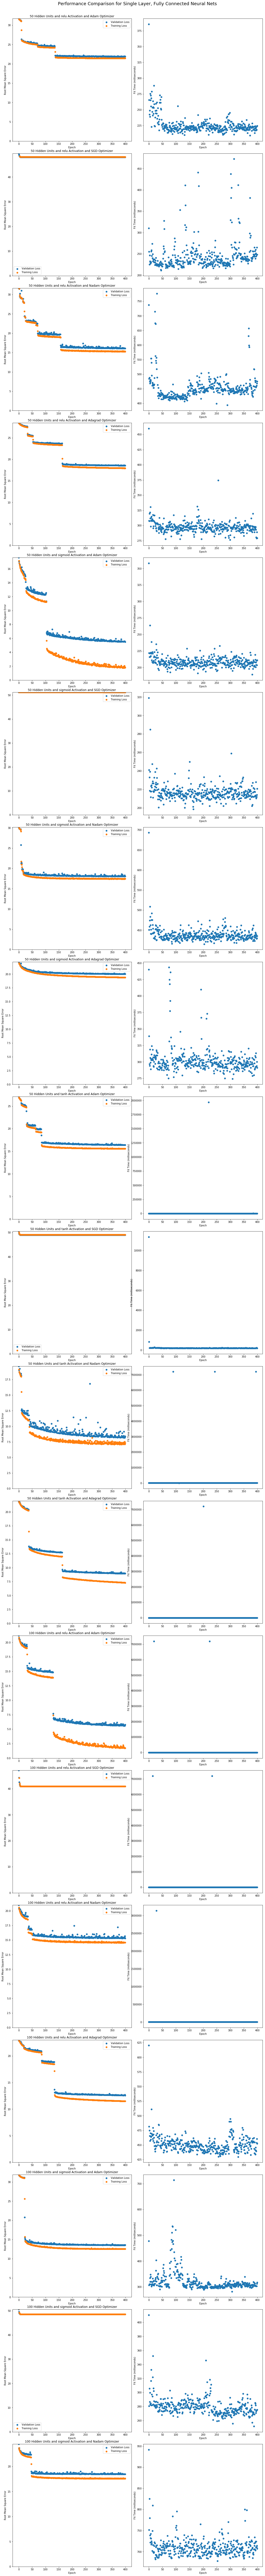

In [28]:
fig, axes = plt.subplots(len(base_model_results), 2, figsize=(15, len(base_model_results)*10))
for i, (key, value) in enumerate(base_model_results.items()):
    axes[i,0].scatter(value.epoch, value.val_RMSE, label='Validation Loss')
    axes[i,0].scatter(value.epoch, value.RMSE, label='Training Loss')
    axes[i,1].scatter(value.epoch, value.times*1000, label='Fit Time')
    axes[i,0].set_xlabel('Epoch')
    axes[i,0].set_ylabel('Root Mean Square Error')
    axes[i,1].set_xlabel('Epoch')
    axes[i,1].set_ylabel('Fit Time (milliseconds)')
    axes[i,0].set_ylim([0,value.val_RMSE.max()])
    axes[i,0].legend()
    axes[i,0].set_title("{} Hidden Units and {} Activation and {} Optimizer".format(key[0], key[1], key[2]._name))
    
# Adjust the spacing of the subplots
fig.subplots_adjust(left=0.03, right=0.97, hspace=0.1, wspace=0.1)

# Add an overarching title for these plots
fig.suptitle("Performance Comparison for Single Layer, Fully Connected Neural Nets",
             fontsize=18, y=0.885)


#### Retain data for further analysis
Let's make sure not to lose any of this data. Add some metadata to the tables, concatenate the dataframes and pickle for later.

In [33]:
single_layer_base_df = pd.DataFrame()
for key, value in base_model_results.items():
    value['hunits'] = key[0]
    value['activation'] = key[1]
    value['optimizer'] = key[2]._name
    value['lrate'] = key[2].get_config()['learning_rate']
    single_layer_base_df = pd.concat([single_layer_base_df,value])
single_layer_base_df.to_pickle("OutputData/single_layer_df.pkl") 

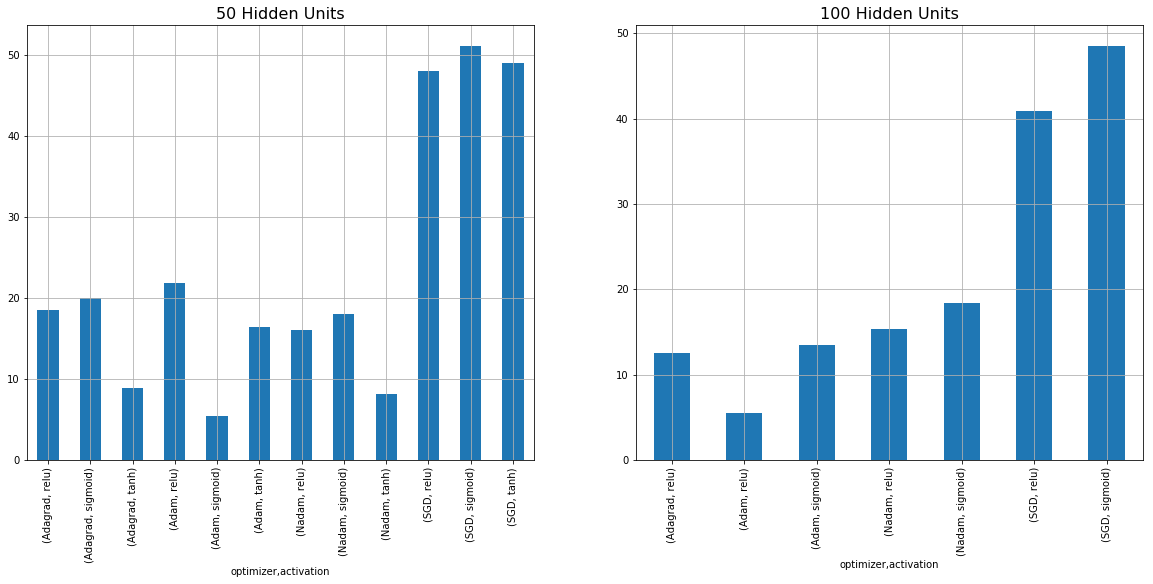

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(20,8))
axes = axes.flatten()
for hh, h in enumerate([50,100]):
    data = single_layer_base_df[single_layer_base_df['hunits'] == h] \
        .groupby(['optimizer','activation']) \
        .val_RMSE.min()
    data.plot.bar(ax=axes[hh])
    axes[hh].set_title("{} Hidden Units".format(h), fontsize=16)
    axes[hh].grid()
    

### Single Layer Neural Net Initial Results
From the above analysis, we did not see much, if any, improvement over our KNN model. However we did learn some things.

1. The SGD optimizer did not work well in any case. We will not continue to test with this optimizer.
2. The number of hidden units increasing seemed to increase our accuracy when using the Recitified linear unit activation function.
3. The Nadam optimizer was insensitive to hidden unit number

We need to now do a sensitivity to number of layers and learning rate. We will start with learning rate and then stack more layers. 

### Parameterize the optimizers and run DOE with 50 and 100 hidden units

We will run one optimizer at a time. For a set of three learning rates.

In [ ]:
# We already have the default learning rate for adam. So let's move up and down to determine accuracy sensitivity
adam_005 = optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999)
adam_0005 = optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

# We already have the default learning rate for nadam. So let's move up and down to determine accuracy sensitivity
nadam_001 = optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
nadam_01 = optimizers.Nadam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)

# We already have the default learning rate for adagrad. So let's move up and down to determine accuracy sensitivity
adagrad_02 = optimizers.Adagrad(lr=0.02, epsilon=None, decay=0.0)
adagrad_005 = optimizers.Adagrad(lr=0.05, epsilon=None, decay=0.0)

opt_list_adam = {'adam_005':adam_005, 'adam_0005':adam_0005}
opt_list_nadam = {'nadam_001':nadam_001, 'nadam_01':nadam_01}
opt_list_adagrad = {'adagrad_02':adagrad_02, 'adagrad_005':adagrad_005}

In [ ]:
plot_history(history)

In [ ]:
len(times)

In [ ]:
model.predict(train_X[0:2])